In [1]:
import polars as pl
import pandas as pd
pd.set_option('display.max_colwidth', None)
import requests
import csv
import time
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


# ESTRUTURA PROPOSTA:


###    1. Introdução

###    2. Project Understanding

###    3. Data Understanding
#####  3.1. Descrição
#####  3.2. EDA
#####  3.3. Correlações
#####  3.4. Qualidade dos dados

###    4. Data Preparation
#####  4.1. Limpeza
#####  4.2. Transformações
#####  4.3. Feature Engineering

###    5. Modeling
#####  5.1. Clustering
#####  5.2. Modelos de previsão
#####  5.3. Normalização

###    6. Evaluation

###    7. Conclusion

###    8. References

# 3. Data Understanding
 
O dataset utilizado corresponde ao registo contínuo de consumos energéticos de vários edifícios municipais da Maia, recolhidos através de sistemas de telemetria. As medições são efetuadas em intervalos regulares de 15 minutos, permitindo caracterizar com grande detalhe os padrões de utilização energética ao longo do tempo.
 ## 3.1 Descrição do Dataset
Cada registo do Dataset, incluí:
 - Código do local (CPE);
 - Timestamp da medição (tstamp);
 - DadosDeConsumo (kW/h);
 - Potência Ativa (kW/h);
 - Potência Reativa Indutiva (VAR);
 - Potência Reativa Capacitiva (VAR).



In [2]:
df = pl.read_csv(
    "consumo15m_11_2025.csv",
    null_values="NULL"
)

df

shape: (5_940_182, 6)
┌────────────────────────┬────────────┬────────────────┬───────────┬───────────────┬───────────────┐
│ CPE                    ┆ tstamp     ┆ DadosdeConsumo ┆ PotActiva ┆ PotReactIndut ┆ PotReactCapac │
│ ---                    ┆ ---        ┆ ---            ┆ ---       ┆ ---           ┆ ---           │
│ str                    ┆ str        ┆ str            ┆ f64       ┆ str           ┆ str           │
╞════════════════════════╪════════════╪════════════════╪═══════════╪═══════════════╪═══════════════╡
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.296     ┆ null          ┆ null          │
│                        ┆ 00:15:00   ┆                ┆           ┆               ┆               │
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.292     ┆ null          ┆ null          │
│                        ┆ 00:30:00   ┆                ┆           ┆               ┆               │
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.284     ┆ null          ┆ null          │
│                        ┆ 00:45:00   ┆                ┆           ┆               ┆               │
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.28      ┆ null          ┆ null          │
│                        ┆ 01:00:00   ┆                ┆           ┆               ┆               │
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.272     ┆ null          ┆ null          │
│                        ┆ 01:15:00   ┆                ┆           ┆               ┆               │
│ …                      ┆ …          ┆ …              ┆ …         ┆ …             ┆ …             │
│ PT0002000110607652SB   ┆ 2025-04-30 ┆ null           ┆ 3.0       ┆ 1.000         ┆ 0.000         │
│                        ┆ 23:00:00   ┆                ┆           ┆               ┆               │
│ PT0002000110607652SB   ┆ 2025-04-30 ┆ null           ┆ 3.0       ┆ 2.000         ┆ 0.000         │
│                        ┆ 23:15:00   ┆                ┆           ┆               ┆               │
│ PT0002000110607652SB   ┆ 2025-04-30 ┆ null           ┆ 3.0       ┆ 1.000         ┆ 0.000         │
│                        ┆ 23:30:00   ┆                ┆           ┆               ┆               │
│ PT0002000110607652SB   ┆ 2025-04-30 ┆ null           ┆ 2.0       ┆ 1.000         ┆ 0.000         │
│                        ┆ 23:45:00   ┆                ┆           ┆               ┆               │
│ PT0002000110607652SB   ┆ 2025-05-01 ┆ null           ┆ 3.0       ┆ 1.000         ┆ 0.000         │
│                        ┆ 00:00:00   ┆                ┆           ┆               ┆               │
└────────────────────────┴────────────┴────────────────┴───────────┴───────────────┴───────────────┘

Foi também possivel obter do site D4Maia / BaZe os edificios associados aos CPEs através do seguinte código.

In [3]:
CPE_LIST_URL = "https://baze.cm-maia.pt/BaZe/api/cpelist.php"
SUMAC_URL = "http://baze2.cm-maia.pt/D4CMMaia/api/sumac.php?cpe={cpe}&ano=2023&cate=BTE"

def obter_cpes():
    resp = requests.get(CPE_LIST_URL)
    resp.raise_for_status()
    return resp.json()

def obter_descricao(cpe):
    url = SUMAC_URL.format(cpe=cpe)
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()

    return data.get("metadata", {}).get("Descrição", "--")

def gerar_csv(ficheiro="cpes_descricao.csv"):
    cpes = obter_cpes()
    print(f"Encontrados {len(cpes)} CPEs.\n")

    caminho_ficheiro = os.path.join(os.path.dirname(os.path.abspath("Projeto.ipynb")), ficheiro)

    with open(caminho_ficheiro, "w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["CPE", "Descrição"])

        for cpe in cpes:
            descricao = obter_descricao(cpe)
            writer.writerow([cpe, descricao])
            print(f"{cpe} → {descricao}")
            time.sleep(0.2)  # poupa servidor

    print(f"\nCSV gerado: {ficheiro}")

In [4]:
#gerar_csv()

In [5]:
df_desc = pl.read_csv("cpes_descricao.csv")
df_cpe = df["CPE"].unique(maintain_order=True).clone().to_frame()
df_compare = df_cpe.join(df_desc, on="CPE", how="left")
df_compare

shape: (91, 2)
┌──────────────────────┬─────────────────────────────────┐
│ CPE                  ┆ Descrição                       │
│ ---                  ┆ ---                             │
│ str                  ┆ str                             │
╞══════════════════════╪═════════════════════════════════╡
│ PT0002000089069203YG ┆ POSTO TURISMO Maia              │
│ PT0002000068856906VS ┆ Quinta dos Cónegos              │
│ PT0002000078441876HB ┆ Torre do Lidador (e/ou Paços d… │
│ PT0002000081997398TD ┆ Parque Central da Maia          │
│ PT0002000100113293JT ┆ Complexo Municipal das Piscina… │
│ …                    ┆ …                               │
│ PT0002000033039837ZH ┆ --                              │
│ PT0002000114685657JR ┆ --                              │
│ PT0002000079901964CJ ┆ PT0618                          │
│ PT0002000131605602FL ┆ AG PT0676                       │
│ PT0002000033085062AW ┆ JARDIMCOOPE - SOLIDERIEDADE SO… │
└──────────────────────┴─────────────────────────────────┘


# 3.2 Limpeza Inicial e Conversão de Tipos
 Antes de proceder à análise, é essencial garantir:
 - conversão do timestamp para formato datetime;
 - conversão das colunas numéricas para float;
 - eliminação/tratamento dos valores "NULL".
 
Estas etapas são fundamentais, pois garantem a consistência do dataset e permitem realizar operações estatísticas e temporais de forma correta. Após esta limpeza, os dados ficam prontos para uma exploração detalhada e fiável.

In [6]:
df = df.with_columns(
    pl.col("tstamp").str.to_datetime("%Y-%m-%d %H:%M:%S")
)

df = df.with_columns([
    pl.col("DadosdeConsumo").cast(pl.Float64),
    pl.col("PotReactIndut").cast(pl.Float64),
    pl.col("PotReactCapac").cast(pl.Float64),
])

df.dtypes

[String,
 Datetime(time_unit='us', time_zone=None),
 Float64,
 Float64,
 Float64,
 Float64]

# 3.3 Análise Descritiva e Visualização

Nesta fase, são calculadas as principais métricas estatísticas, como média, desvio padrão, valores mínimos e máximos. Esta análise, complementada por histogramas, permite uma compreensão inicial da distribuição e da escala das variáveis, sendo fundamental para detetar anomalias, como outliers ou valores inesperados.

In [7]:
df.describe().transpose(include_header=True, header_name="statistic", column_names="statistic")

shape: (6, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ count     ┆ null_coun ┆ mean      ┆ … ┆ 25%       ┆ 50%       ┆ 75%       ┆ max      │
│ ---       ┆ ---       ┆ t         ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ ---       ┆ str       ┆   ┆ str       ┆ str       ┆ str       ┆ str      │
│           ┆           ┆ str       ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ CPE       ┆ 5940182   ┆ 0         ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ PT000200 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 02019361 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 09ME     │
│ tstamp    ┆ 5940182   ┆ 0         ┆ 2024-04-1 ┆ … ┆ 2023-09-2 ┆ 2024-05-1 ┆ 2024-11-0 ┆ 2025-05- │
│           ┆           ┆           ┆ 5 22:32:2 ┆   ┆ 8         ┆ 5         ┆ 8         ┆ 01       │
│           ┆           ┆           ┆ 6.636113  ┆   ┆ 05:00:00  ┆ 14:00:00  ┆ 01:00:00  ┆ 00:00:00 │
│ DadosdeCo ┆ 0.0       ┆ 5940182.0 ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ nsumo     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ PotActiva ┆ 5940182.0 ┆ 0.0       ┆ 8.0939661 ┆ … ┆ 0.12      ┆ 2.0       ┆ 7.0       ┆ 574.0    │
│           ┆           ┆           ┆ 59622719  ┆   ┆           ┆           ┆           ┆          │
│ PotReactI ┆ 3668710.0 ┆ 2271472.0 ┆ 1.7153228 ┆ … ┆ 0.0       ┆ 0.0       ┆ 2.0       ┆ 177.0    │
│ ndut      ┆           ┆           ┆ 246440848 ┆   ┆           ┆           ┆           ┆          │
│ PotReactC ┆ 3668710.0 ┆ 2271472.0 ┆ 0.6525601 ┆ … ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ 124.0    │
│ apac      ┆           ┆           ┆ 641994052 ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [8]:
df.select(pl.col("CPE").n_unique())

shape: (1, 1)
┌─────┐
│ CPE │
│ --- │
│ u32 │
╞═════╡
│ 91  │
└─────┘

O conjunto de dados contém 91 CPEs distintos.

In [9]:
# missing por coluna
df.null_count()

shape: (1, 6)
┌─────┬────────┬────────────────┬───────────┬───────────────┬───────────────┐
│ CPE ┆ tstamp ┆ DadosdeConsumo ┆ PotActiva ┆ PotReactIndut ┆ PotReactCapac │
│ --- ┆ ---    ┆ ---            ┆ ---       ┆ ---           ┆ ---           │
│ u32 ┆ u32    ┆ u32            ┆ u32       ┆ u32           ┆ u32           │
╞═════╪════════╪════════════════╪═══════════╪═══════════════╪═══════════════╡
│ 0   ┆ 0      ┆ 5940182        ┆ 0         ┆ 2271472       ┆ 2271472       │
└─────┴────────┴────────────────┴───────────┴───────────────┴───────────────┘

In [10]:
# percentagem de zeros na PotActiva
total = df.height
zeros = df.filter(pl.col("PotActiva") == 0).height
print(f"Percentagem de PotActiva = 0: {zeros / total * 100} %")

Percentagem de PotActiva = 0: 14.897220320858857 %


A análise inicial revelou que a variável DadosdeConsumo se encontra totalmente nula, pelo que não será útil na modelação inicial. Verificou-se ainda que cerca de 15% dos valores de PotActiva são zero, o que indica longos períodos de baixa atividade energética. Também é possivel reparar na falta de valores de potência reativa indutiva e condutiva para ~~certas secções das séries temporais~~ criando buracos na informação

## Outlier

## Análise de Histogramas


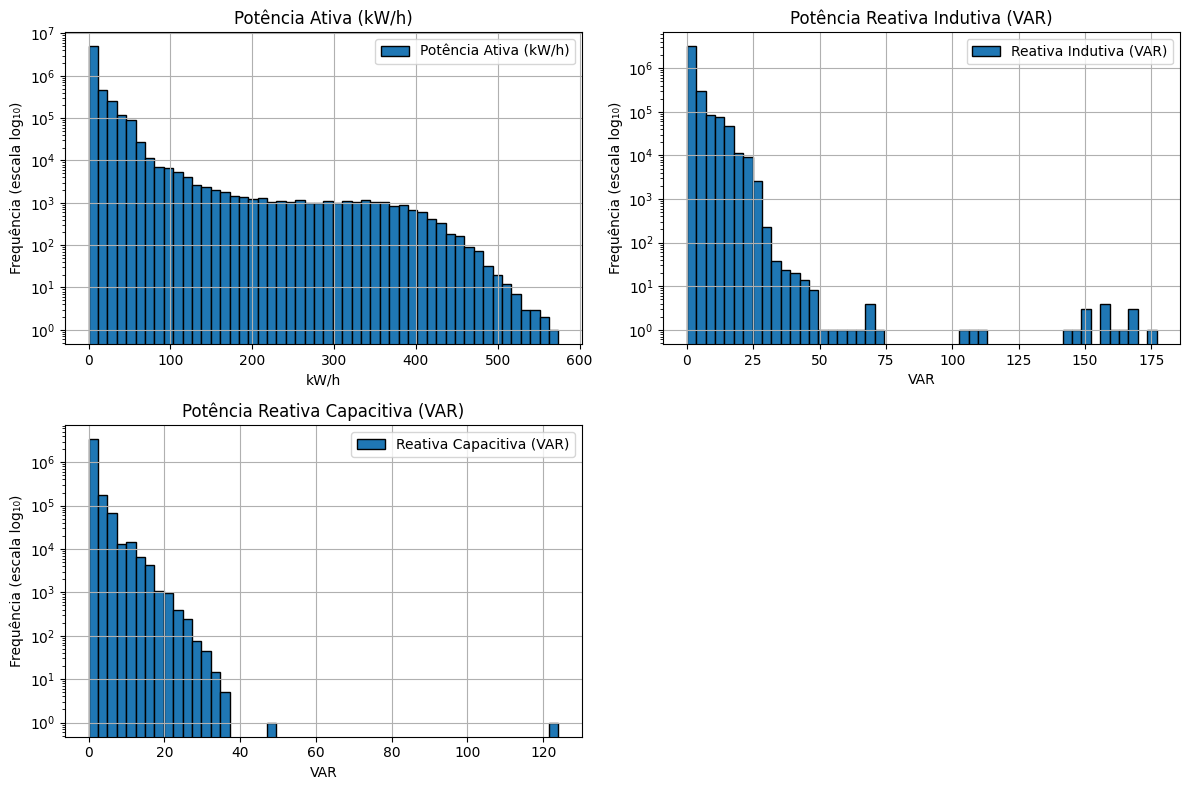

In [11]:
histo = df.select([
    "PotActiva",
    "PotReactIndut",
    "PotReactCapac"
]).to_pandas()

axes = histo.hist(
    bins=50,
    figsize=(12, 8),
    log=True,
    color="#1f77b4",
    edgecolor="black"
)

# Etiquetas e legendas
for ax in axes.flatten():
    col = ax.get_title()

    # Ajustar legendas e unidades
    if col == "PotActiva":
        ax.set_title("Potência Ativa (kW/h)")
        ax.legend(["Potência Ativa (kW/h)"])
        ax.set_xlabel("kW/h")

    elif col == "PotReactIndut":
        ax.set_title("Potência Reativa Indutiva (VAR)")
        ax.legend(["Reativa Indutiva (VAR)"])
        ax.set_xlabel("VAR")

    elif col == "PotReactCapac":
        ax.set_title("Potência Reativa Capacitiva (VAR)")
        ax.legend(["Reativa Capacitiva (VAR)"])
        ax.set_xlabel("VAR")

    # Eixo Y (frequência em escala log)
    ax.set_ylabel("Frequência (escala log₁₀)")

plt.tight_layout()
plt.show()

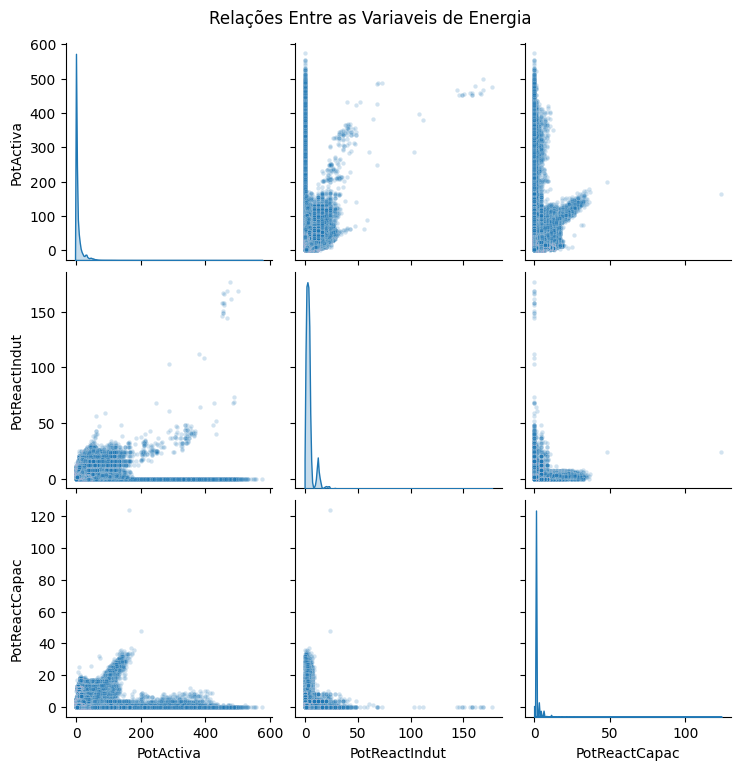

In [12]:
sns.pairplot(
    histo,
    diag_kind="kde",
    plot_kws={"alpha": 0.2, "s": 10} 
)
plt.suptitle("Relações Entre as Variaveis de Energia", y=1.02)
plt.show()

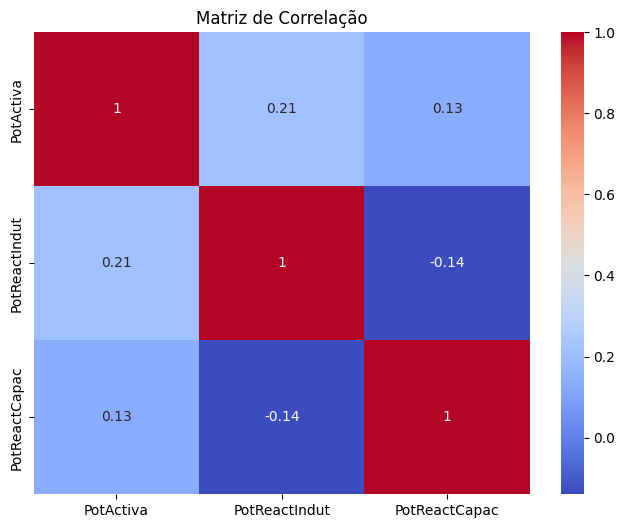

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(histo.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

A matriz de correlação mostra que as três variáveis energéticas analisadas têm uma relação fraca entre si. A potência ativa apresenta apenas uma correlação ligeiramente positiva com a potência reativa indutiva (0.21) e uma ainda mais baixa com a componente capacitiva (0.13). Isto significa que, mesmo quando a potência ativa aumenta, as componentes reativas nem sempre acompanham esse aumento de forma clara ou consistente. Também se observa uma correlação fraca e negativa entre a potência reativa indutiva e capacitiva (-0.14).
No geral, estes valores mostram que as variáveis não são redundantes e captam dimensões distintas do comportamento elétrico dos edifícios, o que as torna úteis para as fases seguintes de preparação e modelação dos dados.

## Análise Temporal
Como o dataset inclui timestamps, é útil analisar o comportamento das variáveis ao longo do tempo permitindo:
<p>-identificar padrões diários e semanais;<p>
-ajudar a perceber períodos de maior e menor atividade; <p>
-facilitar a deteção de picos, anomalias e variações sazonais;



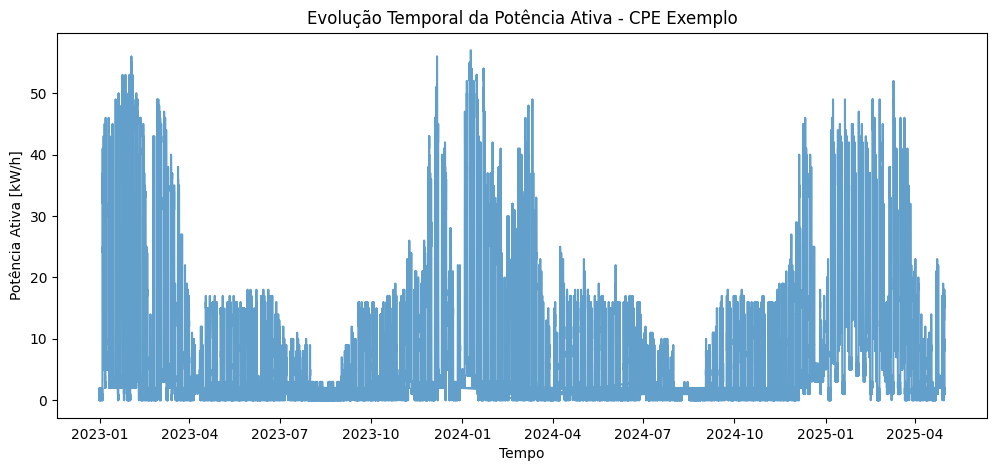

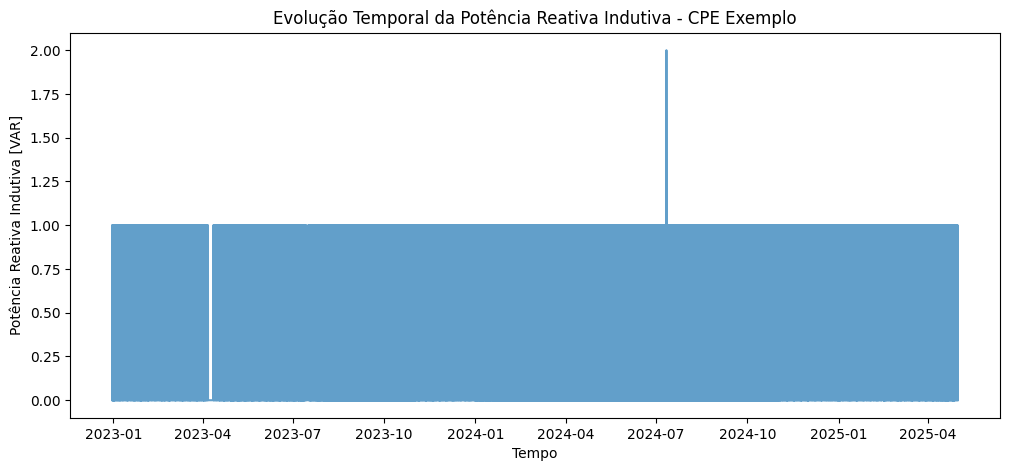

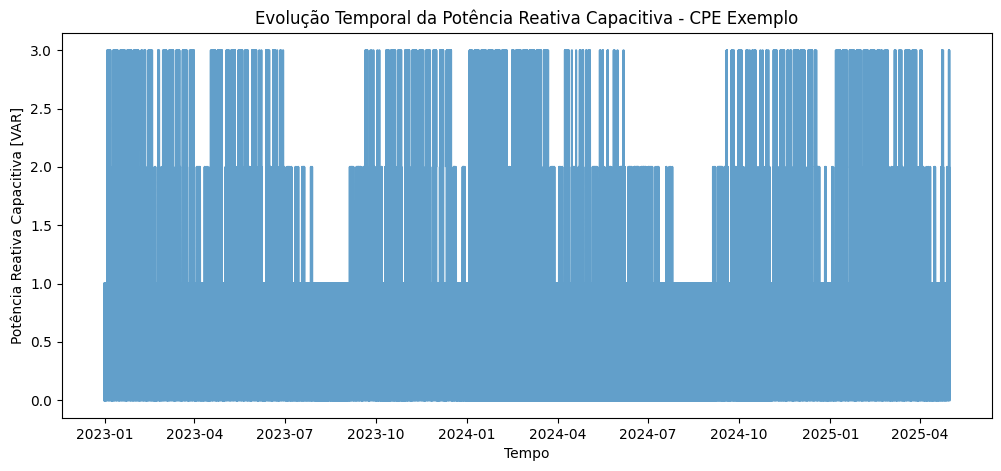

In [14]:
sample_cpe = df.filter(pl.col("CPE") == df["CPE"][1000000])  # escolher 1 edificio
pdf = sample_cpe.to_pandas()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotActiva"], alpha=0.7)
plt.title("Evolução Temporal da Potência Ativa - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa [kW/h]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactIndut"], alpha=0.7)
plt.title("Evolução Temporal da Potência Reativa Indutiva - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Reativa Indutiva [VAR]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactCapac"], alpha=0.7)
plt.title("Evolução Temporal da Potência Reativa Capacitiva - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Reativa Capacitiva [VAR]")
plt.show()

### Perfis Diários, semanais e mensais

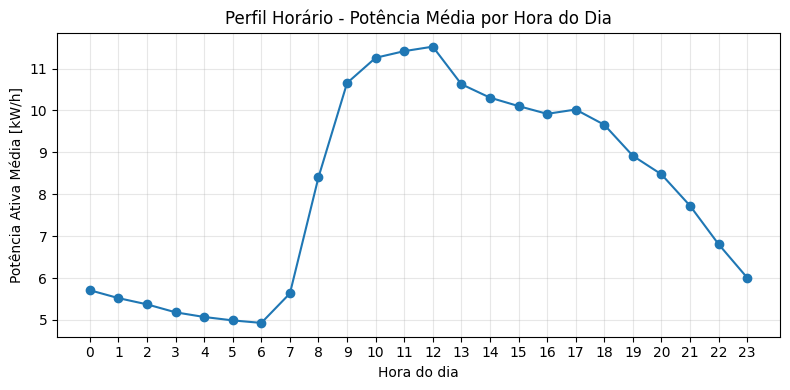

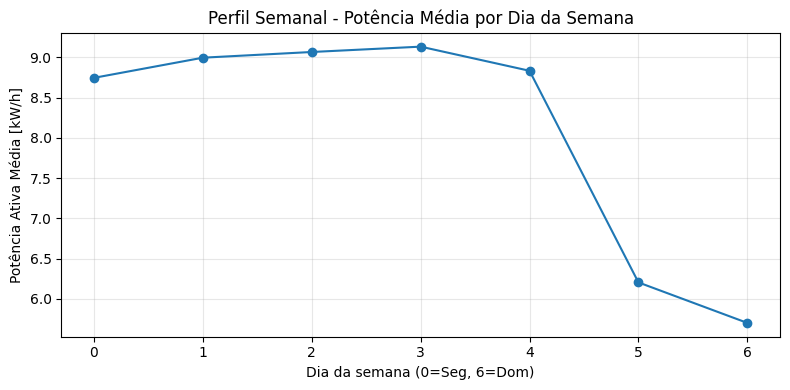

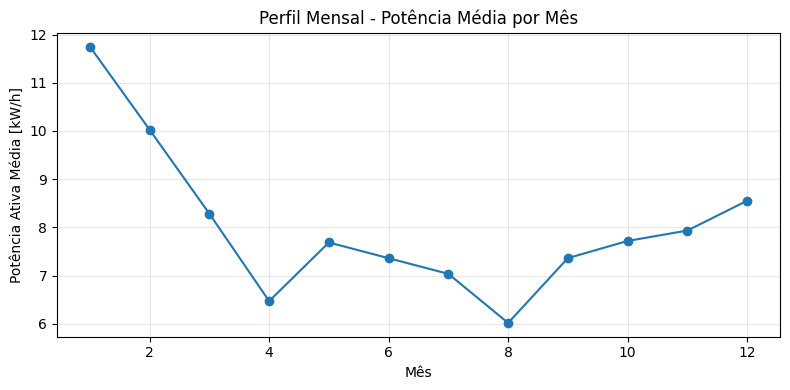

In [15]:
# Perfil Diário
pdf = df.to_pandas()
pdf["hour"] = pdf["tstamp"].dt.hour

hourly = pdf.groupby("hour")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(hourly["hour"], hourly["PotActiva"], marker="o")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Horário - Potência Média por Hora do Dia")
plt.xticks(range(0,24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Semanal
pdf["weekday"] = pdf["tstamp"].dt.weekday  

weekly = pdf.groupby("weekday")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(weekly["weekday"], weekly["PotActiva"], marker="o")
plt.xlabel("Dia da semana (0=Seg, 6=Dom)")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Semanal - Potência Média por Dia da Semana")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Mensal
pdf["month"] = pdf["tstamp"].dt.month

monthly = pdf.groupby("month")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(monthly["month"], monthly["PotActiva"], marker="o")
plt.xlabel("Mês")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Mensal - Potência Média por Mês")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



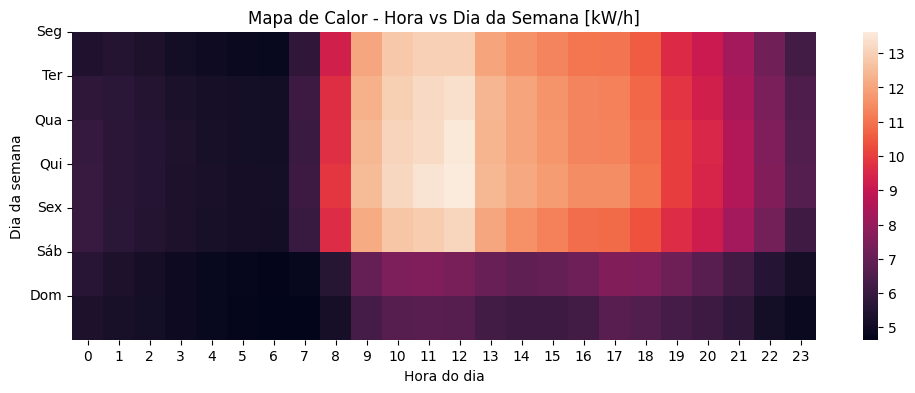

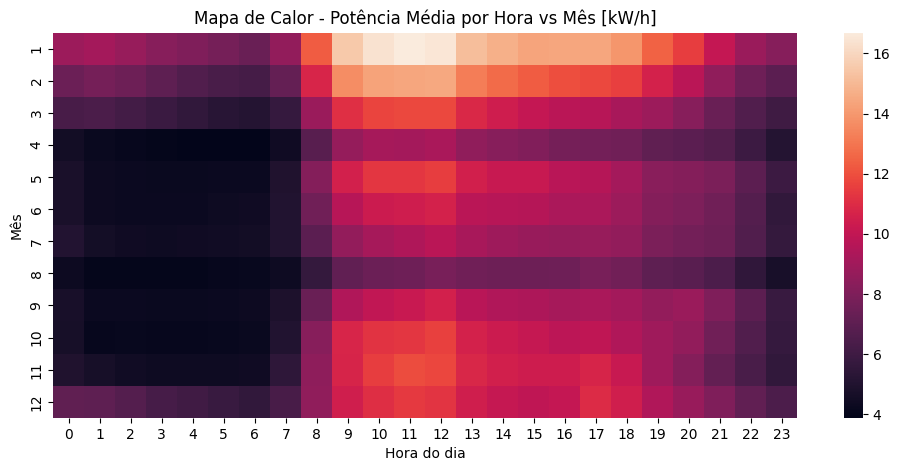

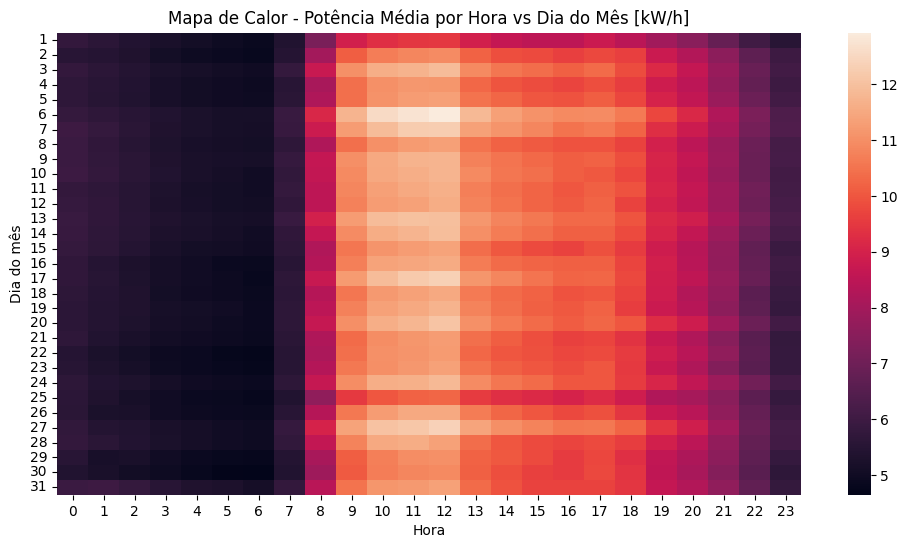

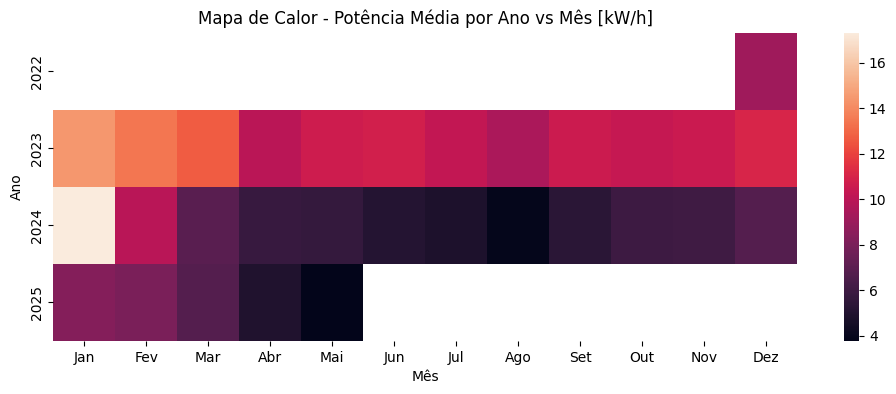

In [16]:

pdf["year"] = pdf["tstamp"].dt.year
pdf["month"] = pdf["tstamp"].dt.month
pdf["weekday"] = pdf["tstamp"].dt.weekday
pdf["hour"] = pdf["tstamp"].dt.hour
pdf["day"] = pdf["tstamp"].dt.day
pivot = pdf.pivot_table(
    values="PotActiva",
    index="weekday",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap="rocket")

# Títulos
plt.title("Mapa de Calor - Hora vs Dia da Semana [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Dia da semana")

# Substituir 0..6 pelos nomes
dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
plt.yticks(ticks=range(7), labels=dias, rotation=0)

pivot_month_hour = pdf.pivot_table(
    values="PotActiva",
    index="month",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,5))
sns.heatmap(pivot_month_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Mês [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Mês")
plt.show()


pivot_day_hour = pdf.pivot_table(
    values="PotActiva",
    index="day",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_day_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Dia do Mês [kW/h]")
plt.xlabel("Hora")
plt.ylabel("Dia do mês")
plt.show()



pivot_year_month = pdf.pivot_table(
    values="PotActiva",
    index="year",
    columns="month",
    aggfunc="mean"
)
meses = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun",
         "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

plt.figure(figsize=(12,4))
sns.heatmap(pivot_year_month, cmap="rocket", 
            xticklabels=meses)
plt.title("Mapa de Calor - Potência Média por Ano vs Mês [kW/h]")
plt.xlabel("Mês")
plt.ylabel("Ano")
plt.show()

Top 3 CPE com maior consumo total: ['PT0002000078441876HB', 'PT0002000100113293JT', 'PT0002000068856781NM']


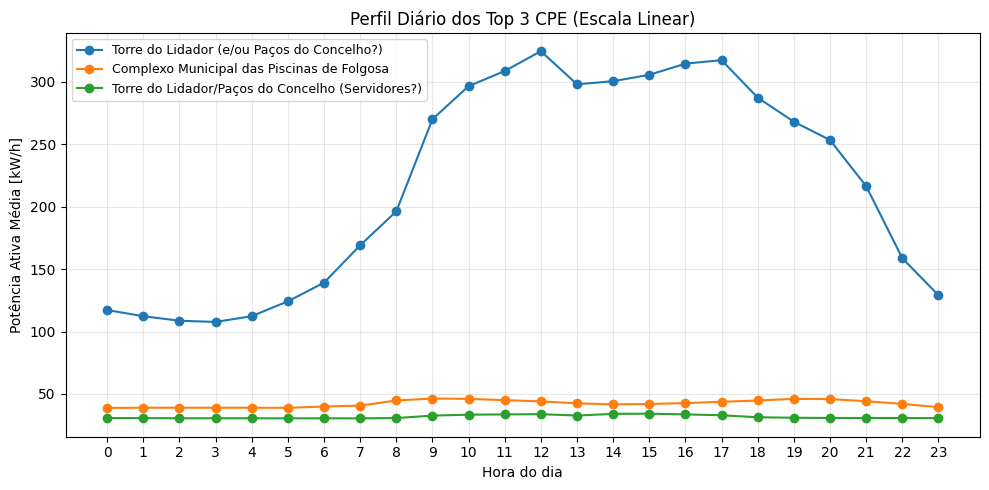

In [17]:
top3 = (
    df.group_by("CPE")
      .agg(pl.col("PotActiva").sum().alias("total"))
      .sort("total", descending=True)
      .head(3)
      .to_pandas()
)

top3_list = top3["CPE"].tolist()
print("Top 3 CPE com maior consumo total:", top3_list)

# Filtrar apenas CPE do Top 3
pdf_top = pdf[pdf["CPE"].isin(top3_list)]

perfis = (
    pdf_top.groupby(["CPE", "hour"])["PotActiva"]
           .mean()
           .reset_index()
)

map_desc = (
    df_compare
    .to_pandas()
    .set_index("CPE")["Descrição"]
    .to_dict()
)

label_map = {cpe: map_desc.get(cpe, cpe) for cpe in top3_list}

plt.figure(figsize=(10,5))

for cpe in top3_list:
    subset = perfis[perfis["CPE"] == cpe]
    plt.plot(
        subset["hour"],
        subset["PotActiva"],
        marker='o',
        label=label_map[cpe]
    )

plt.title("Perfil Diário dos Top 3 CPE (Escala Linear)")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.xticks(range(24))
plt.grid(alpha=0.3)
plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

# 4. Data Preparation
Nesta fase o objetivo é transformar os dados brutos num formato adequado para análise e modelação. São aplicados procedimentos de limpeza, tratamento de valores em falta, criação de novas features temporais e filtragem de valores anómalos.

As principais tarefas realizadas foram:

- Tratamento de valores ausentes.

- Remoção de registos inválidos (potências negativas, duplicados, etc.).

- Criação de variáveis temporais (hora, dia da semana, mês, ano…).

- Verificação de outliers na potência ativa.

In [18]:
prep_df = df.clone()
prep_df.head(1)

shape: (1, 6)
┌──────────────────────┬──────────────┬────────────────┬───────────┬───────────────┬───────────────┐
│ CPE                  ┆ tstamp       ┆ DadosdeConsumo ┆ PotActiva ┆ PotReactIndut ┆ PotReactCapac │
│ ---                  ┆ ---          ┆ ---            ┆ ---       ┆ ---           ┆ ---           │
│ str                  ┆ datetime[μs] ┆ f64            ┆ f64       ┆ f64           ┆ f64           │
╞══════════════════════╪══════════════╪════════════════╪═══════════╪═══════════════╪═══════════════╡
│ PT0002000089069203YG ┆ 2022-12-31   ┆ null           ┆ 0.296     ┆ null          ┆ null          │
│                      ┆ 00:15:00     ┆                ┆           ┆               ┆               │
└──────────────────────┴──────────────┴────────────────┴───────────┴───────────────┴───────────────┘

## 4.1 Remove coluna "DadosdeConsumo"

In [19]:
prep_df = prep_df.drop("DadosdeConsumo")
prep_df.head(1)

shape: (1, 5)
┌──────────────────────┬─────────────────────┬───────────┬───────────────┬───────────────┐
│ CPE                  ┆ tstamp              ┆ PotActiva ┆ PotReactIndut ┆ PotReactCapac │
│ ---                  ┆ ---                 ┆ ---       ┆ ---           ┆ ---           │
│ str                  ┆ datetime[μs]        ┆ f64       ┆ f64           ┆ f64           │
╞══════════════════════╪═════════════════════╪═══════════╪═══════════════╪═══════════════╡
│ PT0002000089069203YG ┆ 2022-12-31 00:15:00 ┆ 0.296     ┆ null          ┆ null          │
└──────────────────────┴─────────────────────┴───────────┴───────────────┴───────────────┘

## 4.2 Remove registos duplicados

In [20]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.unique(subset=["CPE", "tstamp"], maintain_order=True)
depois = prep_df.count().get_column("CPE")[0]

print("Registos duplicados removidos:", antes - depois)

Registos duplicados removidos: 1230


## 4.3 Remove registos com potências negativas 

In [21]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(pl.col("PotActiva") >= 0)
depois = prep_df.count().get_column("CPE")[0]

print("Registos com potências inválidas removidas:", antes - depois)

Registos com potências inválidas removidas: 0


## 4.4 Remove registos sem valores de potência 

In [22]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(~pl.all_horizontal(pl.all().is_null()))
depois = prep_df.count().get_column("CPE")[0]

print("Registos sem potências:", antes - depois)

Registos sem potências: 0


## 4.5 Criar variáveis temporais

In [23]:
prep_pdf = prep_df.to_pandas()

# Extração temporal
prep_pdf["hour"] = prep_pdf["tstamp"].dt.hour
prep_pdf["weekday"] = prep_pdf["tstamp"].dt.weekday
prep_pdf["month"] = prep_pdf["tstamp"].dt.month
prep_pdf["year"] = prep_pdf["tstamp"].dt.year
prep_pdf["date"] = prep_pdf["tstamp"].dt.date

# Período do dia
def periodo(h):
    if 6 <= h < 12: return "morning"
    if 12 <= h < 17: return "afternoon"
    if 17 <= h < 22: return "evening"
    return "night"

prep_pdf["period"] = prep_pdf["hour"].apply(periodo)


period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotActiva"]
    .agg(["max","mean","sum"])
    .rename(columns={
        "max":"peak_power",
        "mean":"mean_power",
        "sum":"total_power"
    })
    .unstack(fill_value=0)
)

# Flatten das colunas
period_features.columns = [
    f"{metric}_{period}"
    for metric, period in period_features.columns
]

period_features = period_features.reset_index().set_index("CPE")


inductive_period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotReactIndut"]
    .agg(["max","mean","sum"])
    .fillna(0)
    .rename(columns={
        "max":"inductive_peak_power",
        "mean":"inductive_mean_power",
        "sum":"inductive_total_power"
    })
    .unstack(fill_value=0)
)

# Flatten das colunas
inductive_period_features.columns = [
    f"{metric}_{period}"
    for metric, period in inductive_period_features.columns
]

inductive_period_features = inductive_period_features.reset_index().set_index("CPE")


capacitive_period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotReactCapac"]
    .agg(["max","mean","sum"])
    .fillna(0)
    .rename(columns={
        "max":"capacitive_peak_power",
        "mean":"capacitive_mean_power",
        "sum":"capacitive_total_power"
    })
    .unstack(fill_value=0)
)

# Flatten das colunas
capacitive_period_features.columns = [
    f"{metric}_{period}"
    for metric, period in capacitive_period_features.columns
]

capacitive_period_features = capacitive_period_features.reset_index().set_index("CPE")


daily = (
    prep_pdf
    .groupby(["CPE","date"])["PotActiva"]
    .agg(["max","std","mean"])
    .rename(columns={
        "max":"daily_peak",
        "std":"daily_std",
        "mean":"daily_mean",
    })
    .reset_index()
)

# time_below50
time_below50 = (
    prep_pdf.groupby(["CPE","date"])
    .apply(lambda x: (x["PotActiva"] < x["PotActiva"].mean() * 0.5).sum(),
           include_groups=False)
    .reset_index(name="time_below50")
)

# merge no daily
daily = daily.merge(time_below50, on=["CPE","date"]).set_index(["CPE","date"])

# agregação final por CPE
daily_features = (
    daily.groupby("CPE").mean()
    .rename(columns={
        "daily_peak":"avg_daily_peak",
        "daily_std":"avg_daily_std",
        "daily_mean":"avg_daily_mean",
        "time_below50":"avg_time_below50"
    })
)


weekly = (
    prep_pdf.groupby(["CPE","weekday"])["PotActiva"]
    .mean()
    .rename("weekday_mean")
)

weekday_table = weekly.unstack()

weekly_ratio = pd.DataFrame({
    "avg_weekday": weekday_table.loc[:,0:4].mean(axis=1),
    "avg_weekend": weekday_table.loc[:,5:6].mean(axis=1),
})

weekly_ratio["weekend_weekday_ratio"] = (
    weekly_ratio["avg_weekend"] / (weekly_ratio["avg_weekday"])
)

weekly_ratio["weekend_weekday_ratio"].fillna(0, inplace=True)

weekly_max = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .max()
    .rename("weekly_max")
)


prep_pdf = prep_pdf.sort_values(["CPE","tstamp"])

lags = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(lambda x: pd.DataFrame({
        "lag_1day": x.shift(96),
        "lag_1week": x.shift(96*7),
        "roll_1day": x.rolling(96).mean(),
        "roll_1week": x.rolling(96*7).mean(),
    }))
)


period_totals = (
    prep_pdf.groupby(["CPE", "period"])["PotActiva"]
    .sum()
    .unstack(fill_value=0)
)

period_totals["night_day_ratio"] = (
    period_totals["night"] /
    (period_totals["morning"] + period_totals["afternoon"] + 1e-6)
)

night_day_ratio = period_totals["night_day_ratio"]


def calc_entropy(series):
    p = series.values
    p = p[p > 0]
    if len(p) == 0:
        return 0.0
    p = p / p.sum()
    return entropy(p)

entropy_feature = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(calc_entropy)
    .rename("entropy")
)


prep_pdf["has_Q"] = np.where(
    prep_pdf["PotReactIndut"].notna() | prep_pdf["PotReactCapac"].notna(),
    1.0,
    -1.0
)

mask_Q = prep_pdf["PotReactIndut"].notna() | prep_pdf["PotReactCapac"].notna()

prep_pdf.loc[mask_Q, "Q_total"] = (
    prep_pdf["PotReactIndut"].fillna(0)
    - prep_pdf["PotReactCapac"].fillna(0)
)

mask_PQ = mask_Q & prep_pdf["PotActiva"].notna()
P = prep_pdf.loc[mask_PQ, "PotActiva"]
Q = prep_pdf.loc[mask_PQ, "Q_total"]

prep_pdf.loc[mask_PQ, "PF"] = P / np.sqrt(P**2 + Q**2)

react_features = (
    prep_pdf.groupby("CPE")
    .agg({
        "has_Q": "mean",
        "Q_total": ["mean", "std"],
        "PF": ["mean", "std"],
    })
)

react_features.columns = [
    "has_Q_mean",
    "Q_mean",
    "Q_std",
    "pf_mean",
    "pf_std",
]

react_features = react_features.fillna({
    "has_Q_mean": -1.0,
    "Q_mean": 0.0,
    "Q_std": 0.0,
    "pf_mean": 1.0,
    "pf_std": 0.0,
})


features_final = (
      daily_features
    .join(period_features, how="left")
    #.join(inductive_period_features, how="left")
    #.join(capacitive_period_features, how="left")
    .join(weekly_ratio, how="left")
    .join(weekly_max, how="left")
    .join(night_day_ratio, how="left")
    .join(entropy_feature, how="left")
    #.join(react_features, how="left")
)

features_final.head()

C:\Users\João Oliveira\AppData\Local\Temp\ipykernel_29832\1069342463.py:137: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weekly_ratio["weekend_weekday_ratio"].fillna(0, inplace=True)


avg_daily_peak  avg_daily_std  avg_daily_mean  \
CPE                                                                   
PT0002000032936306KX        5.334452       2.546508        2.451701   
PT0002000032942455NH        0.257027       0.054953        0.090997   
PT0002000032959511HP        0.000000       0.000000        0.000000   
PT0002000032966446CC        0.322175       0.066023        0.099622   
PT0002000032968749YT       11.542965       2.627443        3.636439   

                      avg_time_below50  peak_power_afternoon  \
CPE                                                            
PT0002000032936306KX         47.155779                 5.320   
PT0002000032942455NH         20.579104                 1.724   
PT0002000032959511HP          0.000000                 0.000   
PT0002000032966446CC         22.942623                 2.100   
PT0002000032968749YT         23.951754                26.524   

                      peak_power_evening  peak_power_morning  \
CPE                                                            
PT0002000032936306KX              22.324              28.584   
PT0002000032942455NH               2.860               1.656   
PT0002000032959511HP               0.000               0.000   
PT0002000032966446CC               2.132               2.244   
PT0002000032968749YT              13.508              31.496   

                      peak_power_night  mean_power_afternoon  \
CPE                                                            
PT0002000032936306KX            30.756              0.004103   
PT0002000032942455NH             2.312              0.097075   
PT0002000032959511HP             0.000              0.000000   
PT0002000032966446CC             2.056              0.098169   
PT0002000032968749YT            14.264              5.214901   

                      mean_power_evening  ...  total_power_afternoon  \
CPE                                       ...                          
PT0002000032936306KX            2.229179  ...                 32.496   
PT0002000032942455NH            0.102223  ...                648.460   
PT0002000032959511HP            0.000000  ...                  0.000   
PT0002000032966446CC            0.120989  ...                716.632   
PT0002000032968749YT            2.232900  ...              47455.600   

                      total_power_evening  total_power_morning  \
CPE                                                              
PT0002000032936306KX            17655.100             9326.136   
PT0002000032942455NH              682.848              626.652   
PT0002000032959511HP                0.000                0.000   
PT0002000032966446CC              883.220              735.128   
PT0002000032968749YT            20319.388            60425.972   

                      total_power_night  avg_weekday  avg_weekend  \
CPE                                                                 
PT0002000032936306KX          65565.964     2.446861     2.410955   
PT0002000032942455NH            955.300     0.101119     0.065112   
PT0002000032959511HP              0.000     0.000000     0.000000   
PT0002000032966446CC           1160.412     0.103228     0.090993   
PT0002000032968749YT          30729.356     4.370737     1.811569   

                      weekend_weekday_ratio  weekly_max  night_day_ratio  \
CPE                                                                        
PT0002000032936306KX               0.985326      30.756         7.005935   
PT0002000032942455NH               0.643920       2.860         0.749189   
PT0002000032959511HP               0.000000       0.000         0.000000   
PT0002000032966446CC               0.881472       2.244         0.799314   
PT0002000032968749YT               0.414477      31.496         0.284843   

                        entropy  
CPE                              
PT0002000032936306KX   9.745128  
PT0002000032942455NH   9.732032  
PT0002000032959511HP   0.000000  
PT0002000032966446CC  

# Dicionário de Features

## 1. Métricas Diárias
- **avg_daily_peak** - Pico diário médio da Potência Ativa.
- **avg_daily_mean** - Consumo médio diário típico.
- **avg_daily_std** - Variabilidade média diária.
- **avg_time_below50** - Nº médio de registos/dia abaixo de 50% do consumo diário.


## 2. Métricas por Período do Dia
Períodos:
**morning (06–12)** · **afternoon (12–17)** · **evening (17–22)** · **night (22–06)**

Para cada período existem 3 features:

- **mean_power_<period>** - Consumo médio.
- **peak_power_<period>** - Pico máximo.
- **total_power_<period>** - Consumo acumulado.

*Ex.: `mean_power_afternoon`, `peak_power_evening`, `total_power_night`*


## 3. Padrões Semanais
- **avg_weekday** - Consumo médio de 2ª a 6ª.
- **avg_weekend** - Consumo médio ao fim de semana.
- **weekend_weekday_ratio** - Relação fim de semana / dias úteis.
- **weekly_max** - Máximo absoluto de Potência Ativa registado para cada CPE.


## 4. Lag & Rolling (Séries Temporais)
- **lag_1day** - Valor de Potência Ativa de 1 dia antes (96 amostras).
- **lag_1week** - Valor de 1 semana antes (96×7 amostras).
- **roll_1day** - Média móvel de 1 dia (suaviza ruído diário).
- **roll_1week** - Média móvel de 1 semana (suaviza padrões semanais).


## 6. Night–Day Ratio
- **night_day_ratio** - Mede o quão “noturno” é o padrão de consumo.


## 7. Entropia de Consumo
- **entropy** - Mede a dispersão do consumo ao longo do tempo.

*Ex.: `Valores altos → padrão irregular`, `Valores baixos → padrão consistente`*


## 8. Potência Reativa e Fator de Potência
- **frac_Q_ind** - Percentagem de medições com Potência Reativa Indutiva disponível.
- **frac_Q_cap** - Percentagem de medições com Potência Reativa Capacitiva disponível.
- **Q_mean** - Média da Potência Reativa (Indutiva – Capacitiva).
- **Q_std** - Variabilidade da Potência Reativa.
- **pf_mean** - Fator de Potência médio.
- **pf_std** - Desvio padrão do Fator de Potência.

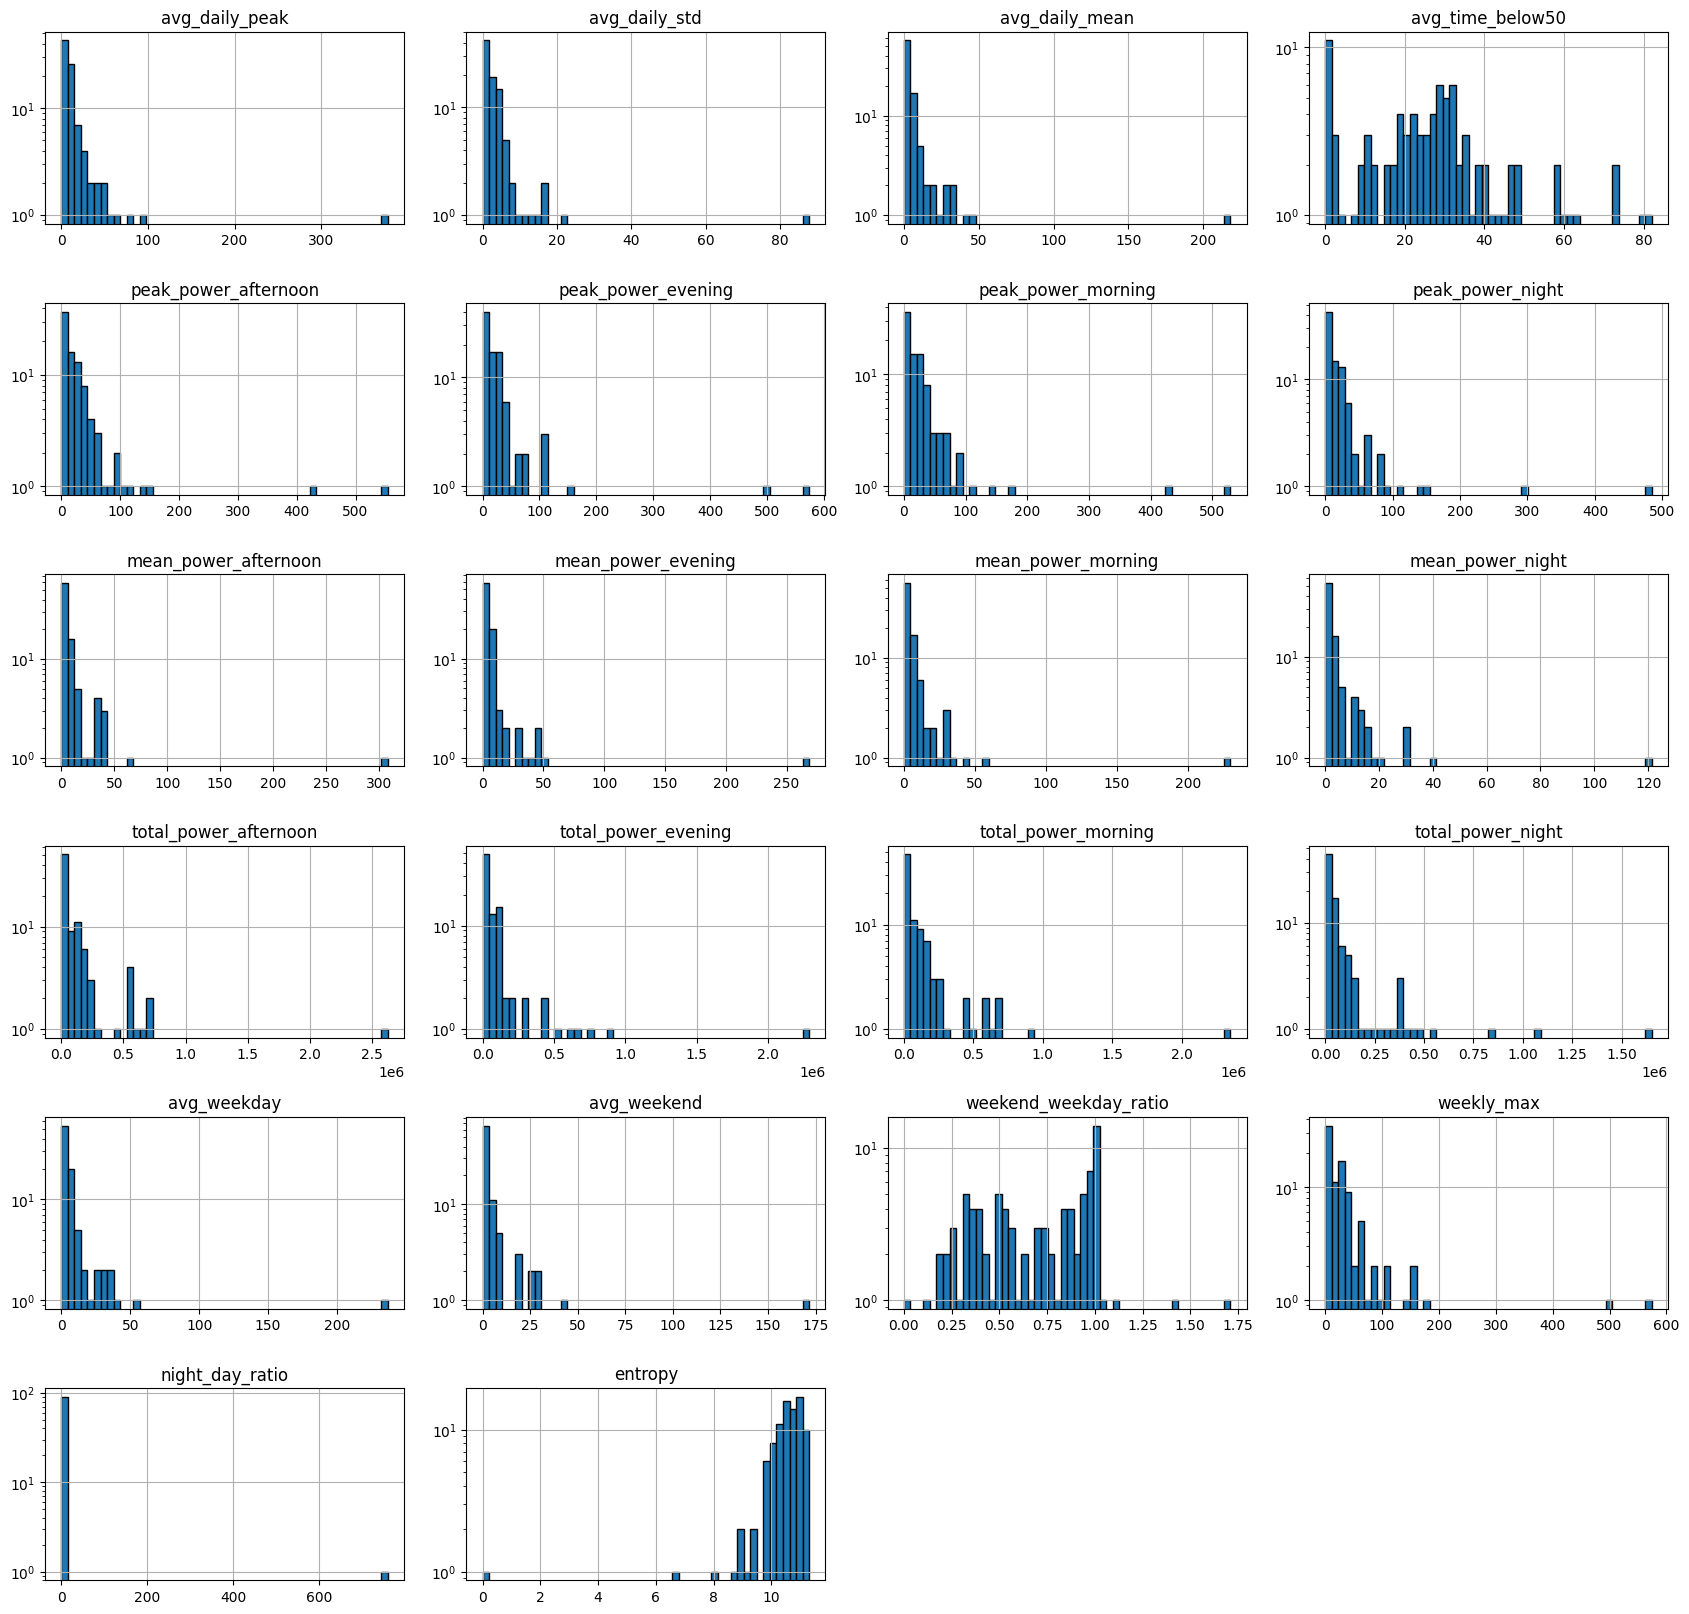

In [24]:
feat = features_final.copy()
feat = feat.reset_index()

feat.select_dtypes(include=["float","int"]).hist(
    bins=50,
    figsize=(17,35),
    log=True,
    color="#1f77b4",
    edgecolor="black",
    layout=(13,4)
)

plt.tight_layout()
plt.show()

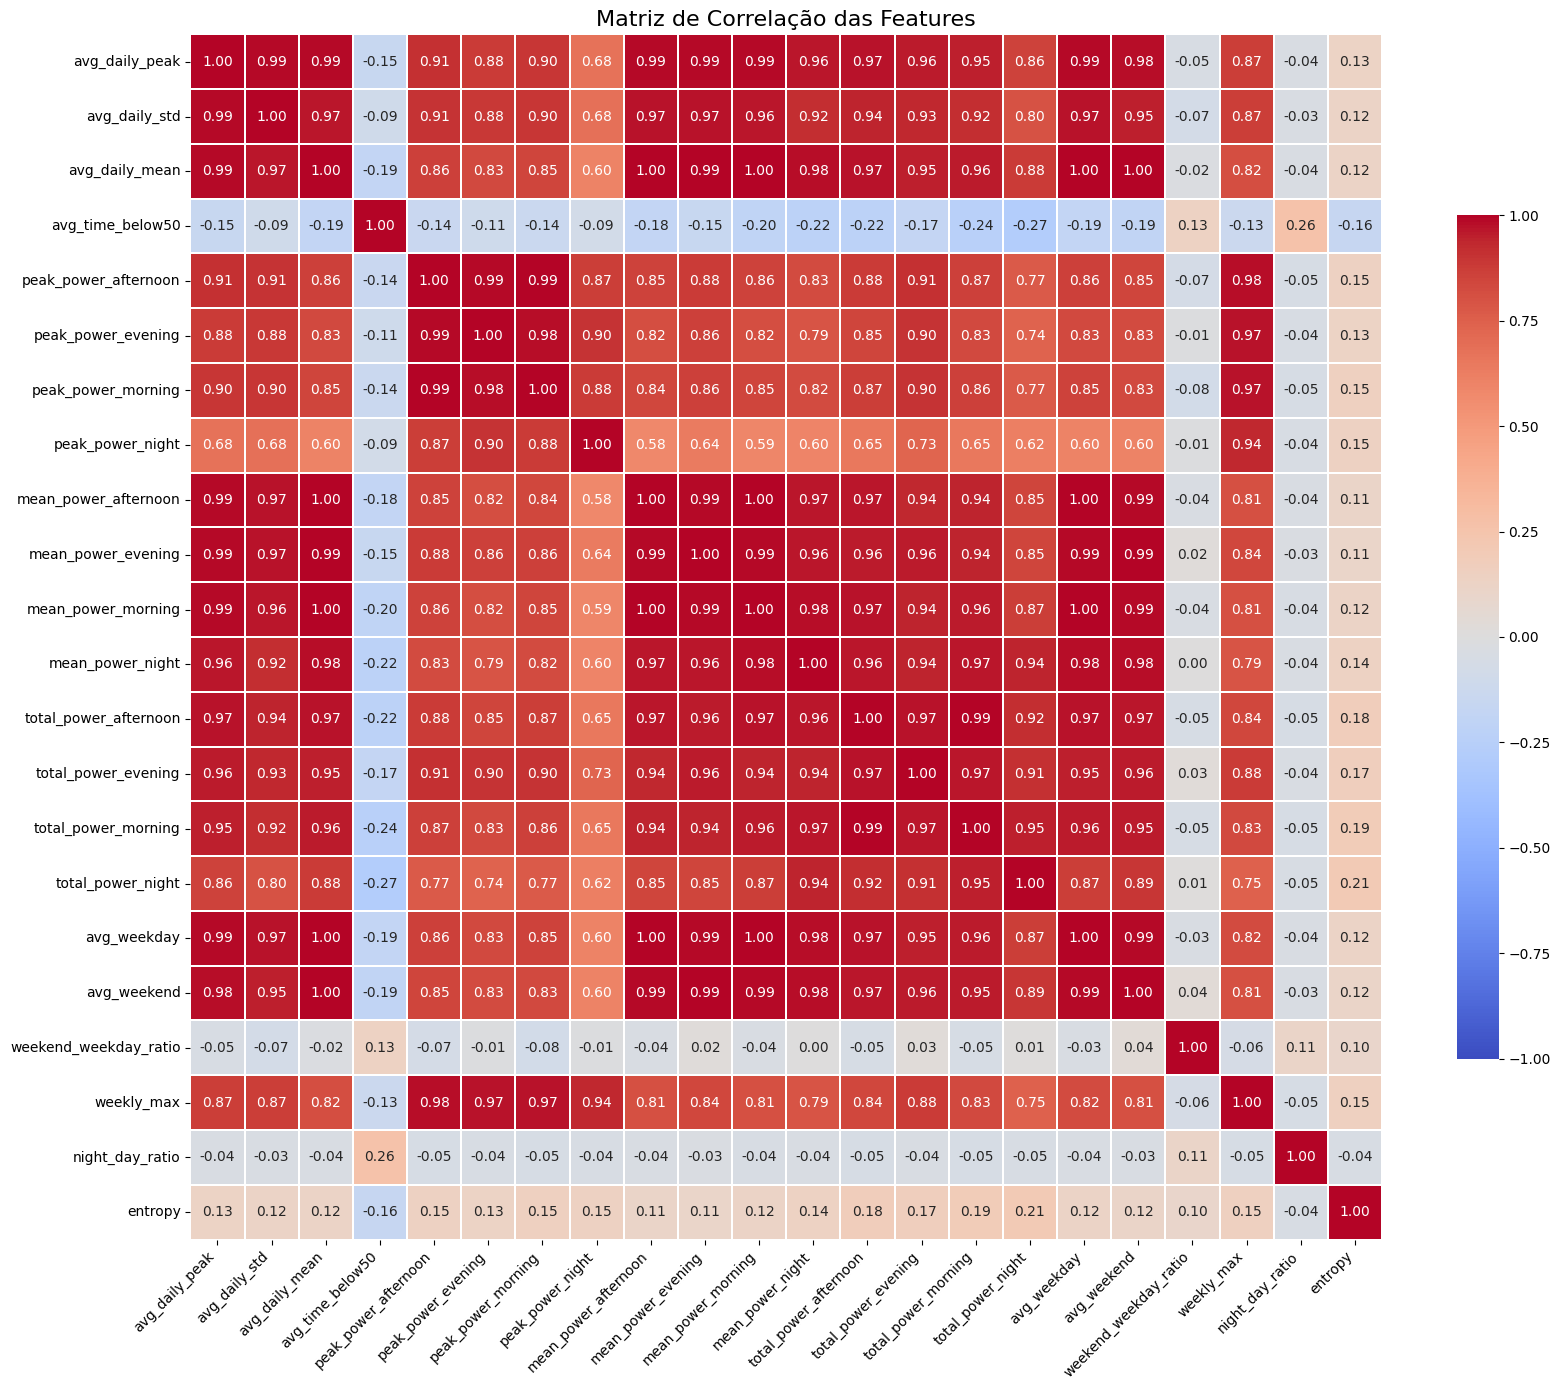

In [25]:
feat_num = feat.select_dtypes(include=["float", "int"])

plt.figure(figsize=(17,14))

sns.heatmap(
    feat_num.corr(),
    cmap="coolwarm",
    annot=True,           
    fmt=".2f",             
    annot_kws={"size": 10}, 
    linewidths=0.3,
    cbar_kws={"shrink": 0.7},
    vmin=-1.0,
    vmax=1.0
)

plt.title("Matriz de Correlação das Features", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
corr = feat_num.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

redundantes = [col for col in upper.columns if any(upper[col] > 0.95)]
redundantes

['avg_daily_std',
 'avg_daily_mean',
 'peak_power_evening',
 'peak_power_morning',
 'mean_power_afternoon',
 'mean_power_evening',
 'mean_power_morning',
 'mean_power_night',
 'total_power_afternoon',
 'total_power_evening',
 'total_power_morning',
 'total_power_night',
 'avg_weekday',
 'avg_weekend',
 'weekly_max']

In [27]:
features_raw = features_final.copy()
feat_num = features_raw.select_dtypes(include=["float", "int"])
corr = feat_num.corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

to_drop = [
    column 
    for column in upper.columns 
    if any(upper[column] > 0.95)
]

# Manter apenas features que não estão na lista to_drop
features_clean = features_raw.drop(columns=to_drop)

print("Removidas:", to_drop)
print("Total antes:", features_raw.shape[1])
print("Total depois:", features_clean.shape[1])

Removidas: ['avg_daily_std', 'avg_daily_mean', 'peak_power_evening', 'peak_power_morning', 'mean_power_afternoon', 'mean_power_evening', 'mean_power_morning', 'mean_power_night', 'total_power_afternoon', 'total_power_evening', 'total_power_morning', 'total_power_night', 'avg_weekday', 'avg_weekend', 'weekly_max']
Total antes: 22
Total depois: 7


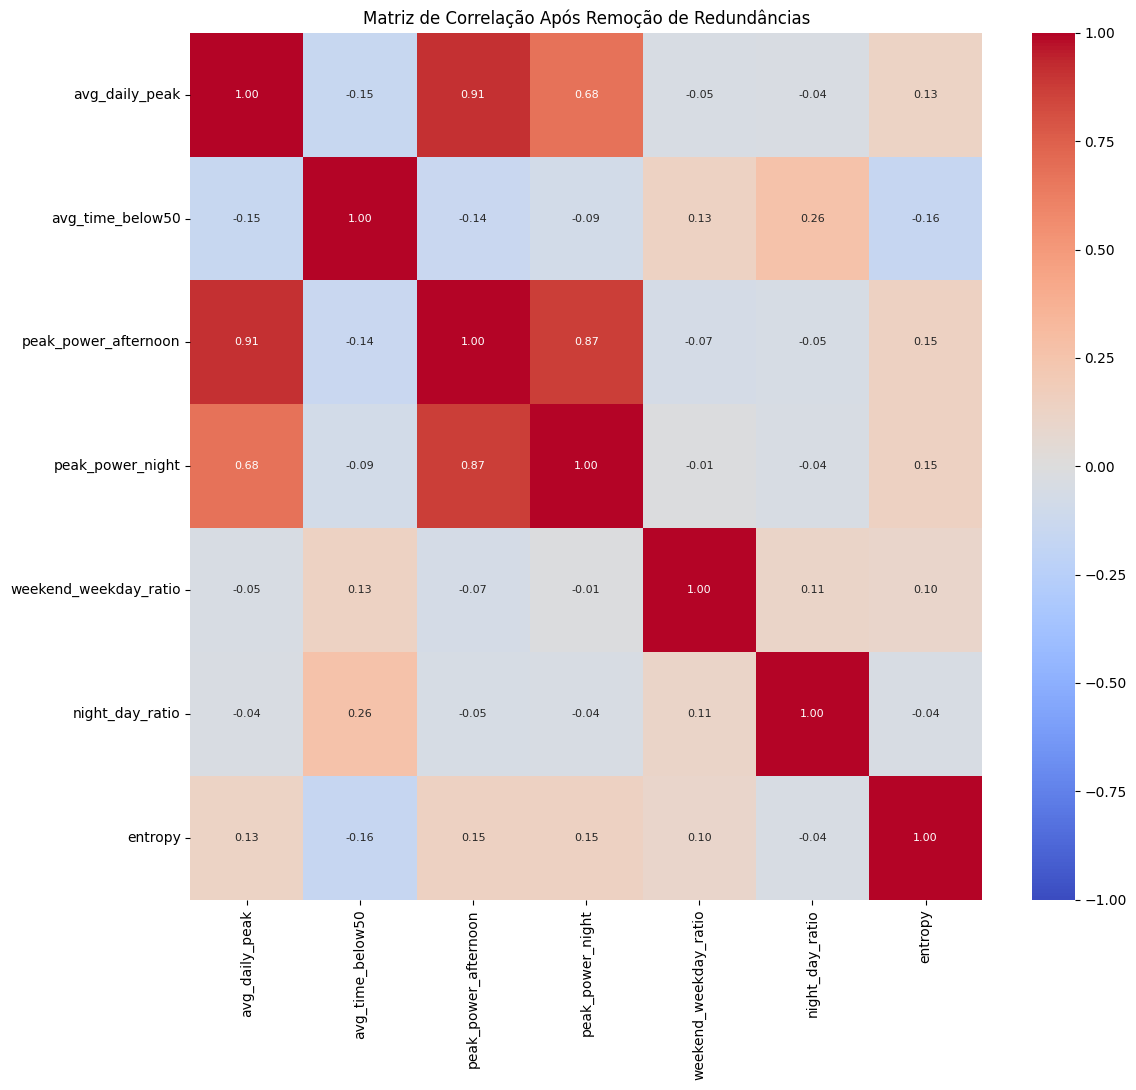

In [28]:
feat_num_clean = features_clean.select_dtypes(include=["float", "int"])

plt.figure(figsize=(12,11))
sns.heatmap(
    feat_num_clean.corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size":8},
    vmin=-1.0,
    vmax=1.0
)
plt.title("Matriz de Correlação Após Remoção de Redundâncias")
plt.tight_layout()
plt.show()

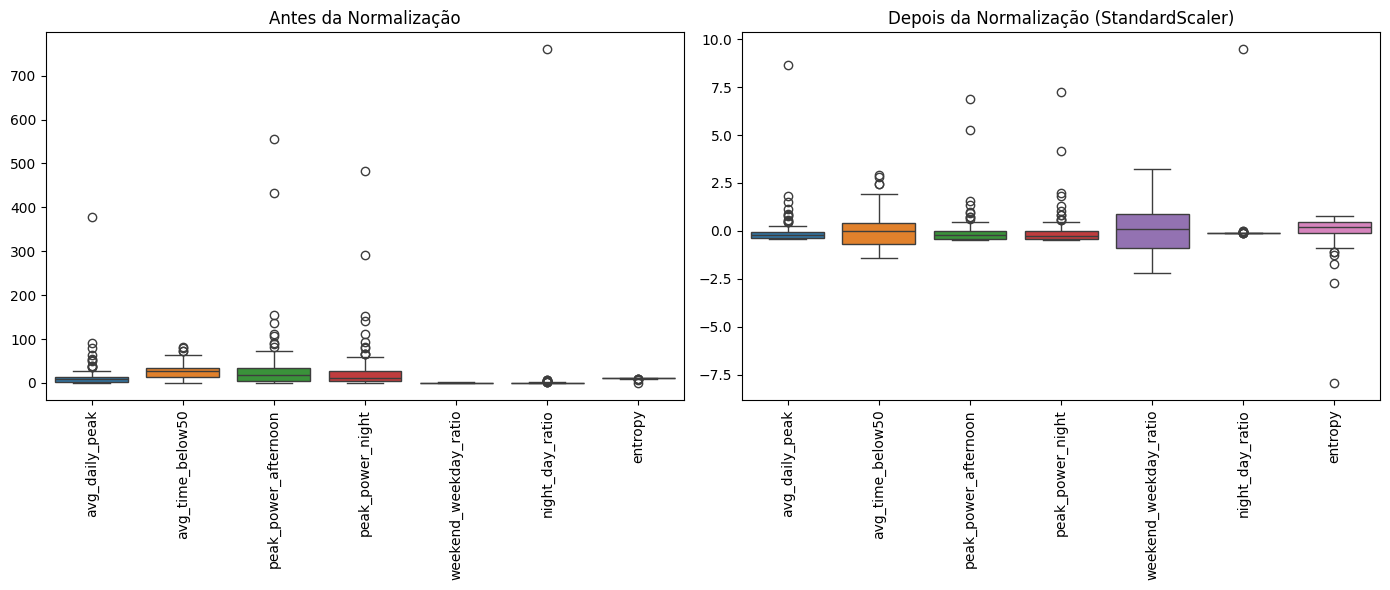

In [29]:
# Selecionar apenas features numéricas
feat = feat_num_clean.copy()
feat_num = feat.select_dtypes(include=["float", "int"])

# Remover linhas com NaN (necessário para o PCA)
feat_pca = feat_num.dropna()

# Normalização correta
scaler = StandardScaler()
feat_scaled = pd.DataFrame(
    scaler.fit_transform(feat_pca),
    index=feat_pca.index,
    columns=feat_pca.columns
)

# BOX-PLOT ANTES E DEPOIS

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(data=feat_pca)
plt.title("Antes da Normalização")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.boxplot(data=feat_scaled)
plt.title("Depois da Normalização (StandardScaler)")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

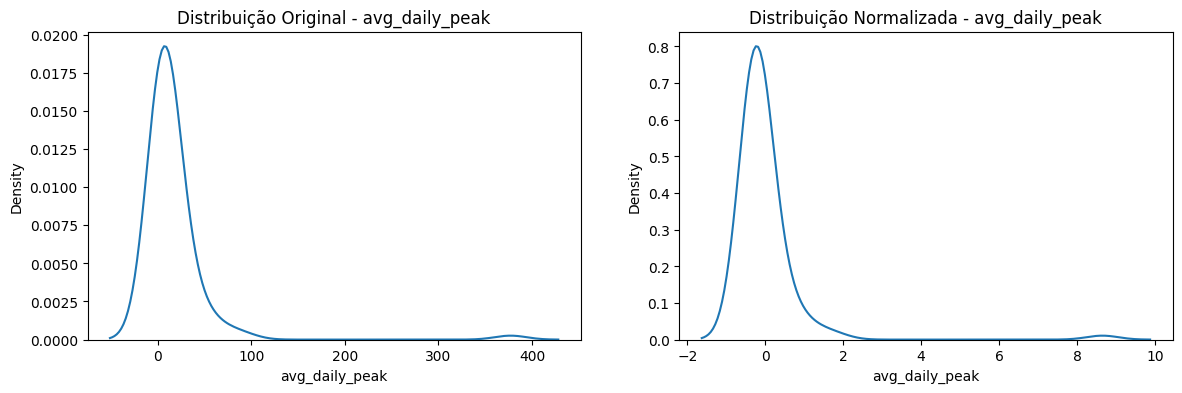

In [30]:
# distribuições antes e depois da normalização do avg_daily_peak

fig, ax = plt.subplots(1, 2, figsize=(14,4))

sns.kdeplot(feat_pca["avg_daily_peak"], ax=ax[0])
sns.kdeplot(feat_scaled["avg_daily_peak"], ax=ax[1])

ax[0].set_title("Distribuição Original - avg_daily_peak")
ax[1].set_title("Distribuição Normalizada - avg_daily_peak")

plt.show()

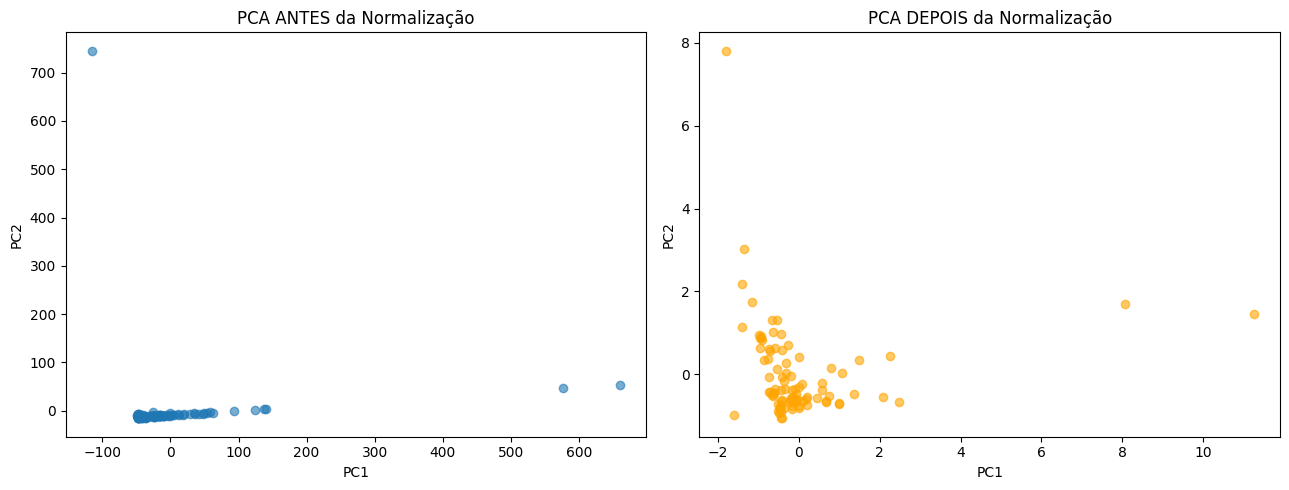

In [31]:
# PCA ANTES E DEPOIS 

pca1 = PCA(n_components=2)
pca_before = pca1.fit_transform(feat_pca)

pca2 = PCA(n_components=2)
pca_after  = pca2.fit_transform(feat_scaled)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(pca_before[:,0], pca_before[:,1], alpha=0.6)
plt.title("PCA ANTES da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(pca_after[:,0], pca_after[:,1], alpha=0.6, color="orange")
plt.title("PCA DEPOIS da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.tight_layout()
plt.show()

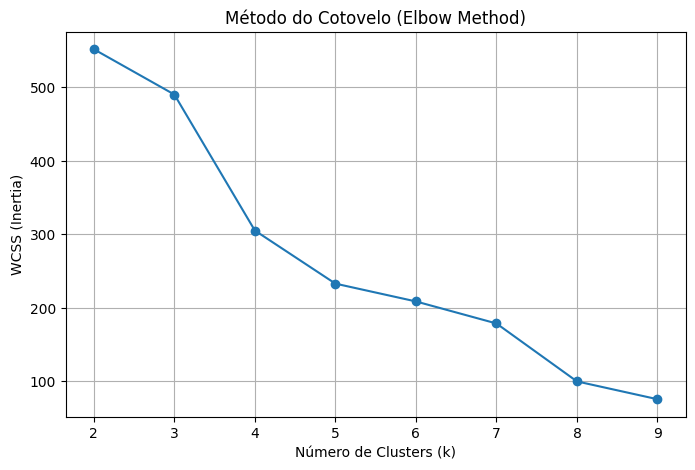

In [32]:
wcss = []  # Within-cluster sum of squares

K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(feat_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, wcss, marker='o')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Método do Cotovelo (Elbow Method)")
plt.grid(True)
plt.show()


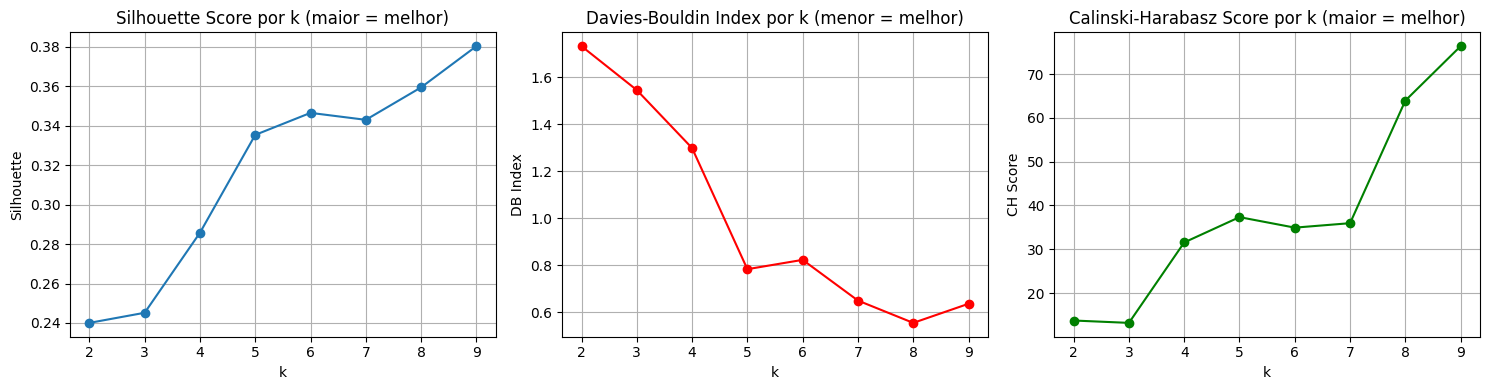

In [33]:
sil_scores = {}
dbi_scores = {}
chi_scores = {}

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(feat_scaled)

    # Silhouette
    sil_scores[k] = silhouette_score(feat_scaled, labels)

    # Davies-Bouldin (menor = melhor)
    dbi_scores[k] = davies_bouldin_score(feat_scaled, labels)

    # Calinski-Harabasz (maior = melhor)
    chi_scores[k] = calinski_harabasz_score(feat_scaled, labels)



plt.figure(figsize=(15,4))

# Silhouette
plt.subplot(1,3,1)
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score por k (maior = melhor)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)

# Davies–Bouldin
plt.subplot(1,3,2)
plt.plot(list(dbi_scores.keys()), list(dbi_scores.values()), marker='o', color='red')
plt.title("Davies-Bouldin Index por k (menor = melhor)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.grid(True)

# Calinski-Harabasz
plt.subplot(1,3,3)
plt.plot(list(chi_scores.keys()), list(chi_scores.values()), marker='o', color='green')
plt.title("Calinski-Harabasz Score por k (maior = melhor)")
plt.xlabel("k")
plt.ylabel("CH Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
w_sil = 0.8
w_db = 0.2
w_ch = 0.0

db_inverted = {k: 1/v for k, v in dbi_scores.items()}

weighted_score = {}
for k in sil_scores.keys():
    score = (w_sil * sil_scores[k] + w_db * db_inverted[k] + w_ch * chi_scores[k])
    weighted_score[k] = score

# Find best k
best_k = max(weighted_score, key=weighted_score.get)

# Mostrar valores numéricos
print("Silhouette:")
print(sil_scores)
print("Davies-Bouldin:")
print(dbi_scores)
print("Calinski-Harabasz:")
print(chi_scores)
print("Média ponderada por k:")
print(weighted_score)
print("Melhor k:", best_k)

Silhouette:
{2: 0.24003235861663122, 3: 0.24516549850891306, 4: 0.2857391923361881, 5: 0.3353554318274363, 6: 0.34651566238765275, 7: 0.3429865026741089, 8: 0.3594435138813413, 9: 0.38033477603893073}
Davies-Bouldin:
{2: 1.7312339160337005, 3: 1.5444843874369836, 4: 1.2976373461858446, 5: 0.7822601658947117, 6: 0.8219657831009285, 7: 0.6487517999306875, 8: 0.5537483380455273, 9: 0.6350679903387831}
Calinski-Harabasz:
{2: 13.713267919522998, 3: 13.171113006446411, 4: 31.555943676084475, 5: 37.341266719908056, 6: 34.93857560769413, 7: 35.95934718070592, 8: 63.97760622672742, 9: 76.41251690652305}
Média ponderada por k:
{2: 0.30755042586387055, 3: 0.325625452687651, 4: 0.3827176208015889, 5: 0.5239537617503902, 6: 0.5205316608421724, 7: 0.5826735105934109, 8: 0.6487297099876711, 9: 0.6191947310873332}
Melhor k: 8


In [35]:
#best_k = 3

kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(feat_scaled)

feat_clust = feat_scaled.copy()
feat_clust.loc[:, "cluster"] = cluster_labels

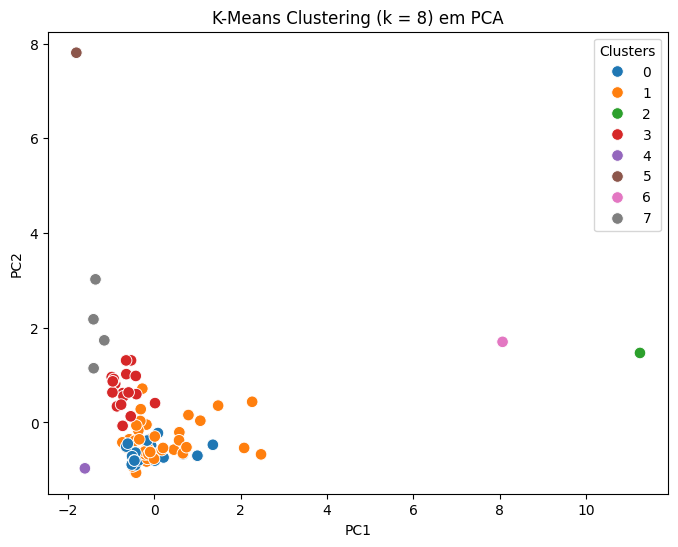

In [36]:
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=cluster_labels,
    palette='tab10',
    s=70
)

plt.title(f"K-Means Clustering (k = {best_k}) em PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clusters")
plt.show()

In [37]:
pca = PCA(n_components=3)
coords = pca.fit_transform(feat_scaled)

coords = coords.T

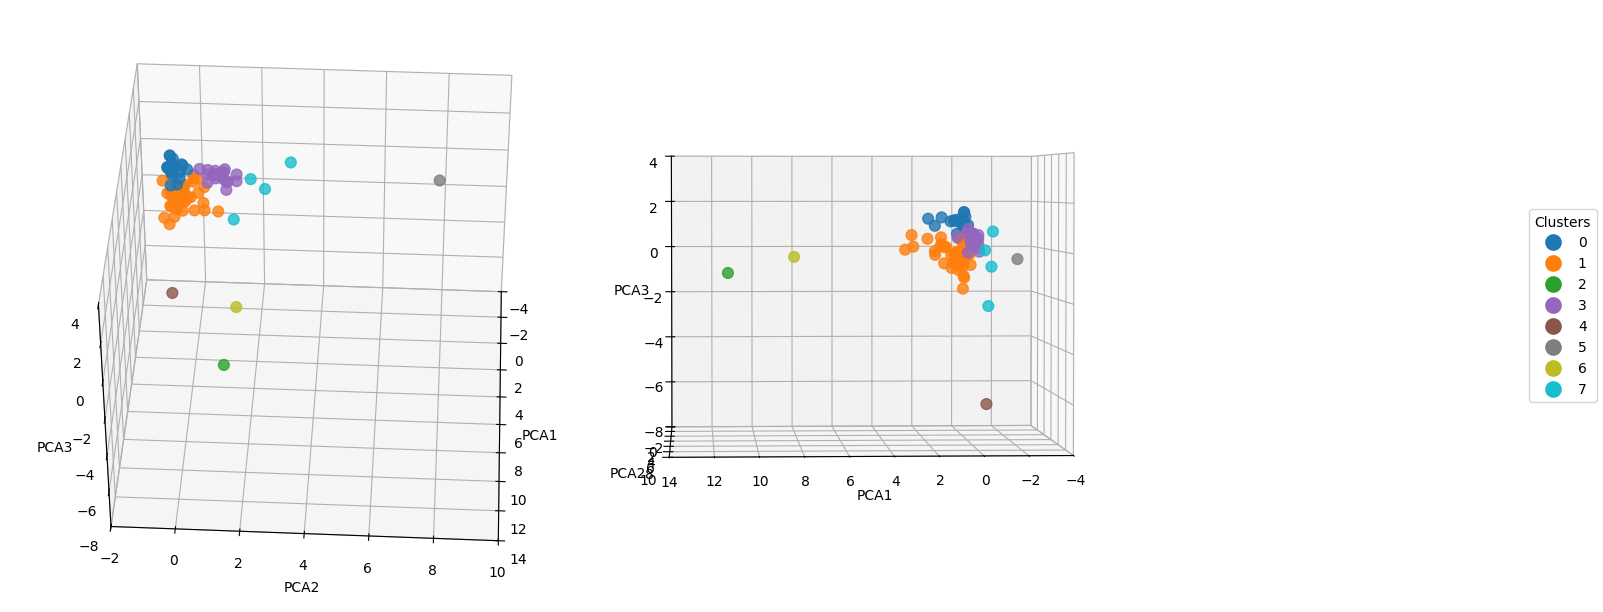

In [38]:
fig = plt.figure(figsize=(20, 10))

# Define the views you want
views = [
    (40, 3),
    (2, 87)
]

unique_clusters = np.unique(cluster_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

point_colors = [cluster_to_color[c] for c in cluster_labels]

for i, (elev, azim) in enumerate(views, start=1):
    ax = fig.add_subplot(1, 3, i, projection="3d")


    ax.scatter(
        coords[0],
        coords[1],
        coords[2],
        c=point_colors,
        s=60,
        alpha=0.8
    )

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")

    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_zticks(ax.get_zticks())

    ax.view_init(elev=elev, azim=azim)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label=f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

fig.legend(handles=handles, loc="center right", title="Clusters")

for ax in fig.axes:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 2, pos.height * 1.3])

plt.show()

In [39]:
df_compare_pd = df_compare.to_pandas()
df_compare2 = feat_clust.join(df_compare_pd.set_index("CPE"), on="CPE", how="left")
df_compare2 = df_compare2[["Descrição","cluster"]]

In [40]:
df_compare2[df_compare2['cluster'] == 0]

Descrição  \
CPE                                                                      
PT0002000033186037TF                        OFICINAS GERAIS - OFICINAS   
PT0002000053093191SV                                   Fórum Jovem - C   
PT0002000066469574LZ                  POLIDESPORTIVO Municipal Lidador   
PT0002000068856781NM  Torre do Lidador/Paços do Concelho (Servidores?)   
PT0002000068856906VS                                Quinta dos Cónegos   
PT0002000069698702RB                       ARMAZÉNS do BAIRRO SOBREIRO   
PT0002000077394934QY                         Aeródromo de Vilar de Luz   
PT0002000082549706RH    Complexo de Educação Ambiental da Quinta Gruta   
PT0002000084414998AX               Centro DOCUMENTAL JOÃO ÁLVARO ROCHA   
PT0002000085641795MX                         LOJA da JUVENTUDE GEMUNDE   
PT0002000100113293JT        Complexo Municipal das Piscinas de Folgosa   
PT0002000102936404ME                         Parque Urbano de Moutidos   
PT0002000106237165CF                    LOJA JUVENTUDE VILA NOVA TELHA   
PT0002000107172384HT                              Quinta da Caverneira   
PT0002000107332489XW               SEMÁFOROS IGREJA Santa MARIA Avioso   
PT0002000120320157HF  SEMÁFOROS ECOCAMINHO - R CONSELHEIRO COSTA AROSO   
PT0002000123801456QA                       LAGO COOPERATIVA SIDERURGIA   
PT0002000133505542CK                         SEMÁFOROS ALTINO COELHO I   

                      cluster  
CPE                            
PT0002000033186037TF        0  
PT0002000053093191SV        0  
PT0002000066469574LZ        0  
PT0002000068856781NM        0  
PT0002000068856906VS        0  
PT0002000069698702RB        0  
PT0002000077394934QY        0  
PT0002000082549706RH        0  
PT0002000084414998AX        0  
PT0002000085641795MX        0  
PT0002000100113293JT        0  
PT0002000102936404ME        0  
PT0002000106237165CF        0  
PT0002000107172384HT        0  
PT0002000107332489XW        0  
PT0002000120320157HF        0  
PT0002000123801456QA        0  
PT0002000133505542CK        0

In [41]:
df_compare2[df_compare2['cluster'] == 1]

Descrição  \
CPE                                                                          
PT0002000032942455NH                       EB1/JI de Gueifães - EDIFÍCIO 2   
PT0002000032968749YT                                          EB1/JI ARCOS   
PT0002000032969229AC                                       EB1/JI FERREIRÓ   
PT0002000032976997LZ                                        EB1/JI PROZELA   
PT0002000032990792KD                  EB1/JI PEDRAS RUBRAS - EDIFÍCIO NOVO   
PT0002000032993611ME               Centro Escolar GUARDA - EDIFÍCIO ANTIGO   
PT0002000033016394FN                             CONSERVATÓRIO MÚSICA Maia   
PT0002000033039837ZH                                                    --   
PT0002000033074862LZ                              Centro Escolar de Mandim   
PT0002000033085062AW       JARDIMCOOPE - SOLIDERIEDADE SOCIAL / 2122782359   
PT0002000033094187PL                           OFICINAS GERAIS - GABINETES   
PT0002000033171958DG                                             CPCJ Maia   
PT0002000033254603ZX                                           EB1/JI PAÇO   
PT0002000065523872AA                                       Fórum Jovem - A   
PT0002000068856655YV                                   Fórum Jovem da Maia   
PT0002000068857099AR                 Campo Municipal de Jogos de Milheirós   
PT0002000068857897ZV                                                    --   
PT0002000068857909SY                         Pavilhão Municipal de Moreira   
PT0002000068859187RL                                   EB1/JI D. Manuel II   
PT0002000068859382XF                                                    --   
PT0002000068859393XH                           Complexo Municipal de Ténis   
PT0002000068859597LS                                                    --   
PT0002000071896778MT                                     EB1/JI do Lidador   
PT0002000073231742VK                            Centro Escolar de Moutidos   
PT0002000073481266XH                                          Casa do Alto   
PT0002000075637532JB                       EB1/JI de Gueifães (Edifício I)   
PT0002000077647404EM                        Pavilhão Municipal de Crestins   
PT0002000078207354XC  Pavilhão Municipal de Águas Santas III - Formigueiro   
PT0002000078294957RQ                                        EB1/JI da Maia   
PT0002000081997398TD                                Parque Central da Maia   
PT0002000082592498EF                         LOJA JUVENTUDE SÃO PEDRO FINS   
PT0002000089069203YG                                    POSTO TURISMO Maia   
PT0002000100742616GC                                      EB1/JI PORTO BOM   
PT0002000101964938LF                                                    --   
PT0002000107046231FW                              EB1/JI de Santa Cristina   
PT0002000109837807PE                        Pavilhão Municipal de Nogueira   
PT0002000110607652SB                                                    --   
PT0002000112989585PH                                                    --   
PT0002000114685657JR                                                    --   
PT0002000115031201VQ                             EB1/JI do Castêlo da Maia   
PT0002000115673389QK                           Centro Escolar Maia-Estação   
PT0002000115673471CB                    Centro Escolar de Vermoim-Gueifães   
PT0002000115700602GW                              Centro Escolar da Gandra   
PT0002000119303492KB                               Centro Escolar da Pícua   
PT0002000120237616VJ                             Centro Escolar de Folgosa   
PT0002000123648159KR                                    EB1/JI de Currrais   

                      cluster  
CPE                            
PT0002000032942455NH        1  
PT0002000032968749YT        1  
PT0002000032969229AC        1  
PT0002000032976997LZ        1  
PT0002000032990792KD        1  
PT0002000032993611ME        1  
PT0002000033016394FN        1  
PT0002000033039837ZH        1  


In [42]:
df_compare2[df_compare2['cluster'] == 2]

Descrição  cluster
CPE                                                                      
PT0002000078441876HB  Torre do Lidador (e/ou Paços do Concelho?)        2

In [43]:
df_compare2[df_compare2['cluster'] == 3]

Descrição  cluster
CPE                                                                           
PT0002000032936306KX                                           PT0195        3
PT0002000032966446CC                                       EB1 PADRÃO        3
PT0002000068856952LS                                Parque das Fontes        3
PT0002000069803182JW           SISTEMA DE REGA do Monumento PIRÂMIDES        3
PT0002000073598156DE                                    LAGO MANINHOS        3
PT0002000073717386HC                    Fonte Decorativa de Pedrouços        3
PT0002000078233981HJ    Pavilhão Municipal de Águas Santas II - Corim        3
PT0002000079901964CJ                                           PT0618        3
PT0002000081344542CP  Pavilhão da Associação Atlética de Águas Santas        3
PT0002000085555547GN                                  HORTO Municipal        3
PT0002000108315818YN                                    LAGO LAVRADOR        3
PT0002000110090564GD                Pavilhão Municipal de Gueifães II        3
PT0002000112026362NN       ILUMINAÇÃO DECORATIVA da RUA SIMÃO BOLÍVAR        3
PT0002000112171317NK      ILUMINAÇÃO DECORATIVA da RUA NICOLAU NASONI        3
PT0002000117822355RM             Complexo Municipal DE SÃO PEDRO FINS        3
PT0002000125379984SH            Pavilhão Gimnodesportivo de Pedrouços        3
PT0002000131605602FL                                        AG PT0676        3
PT0002000133685986TF       ILUMINAÇÃO DECORATIVA RUA CENTRAL SOBREIRO        3
PT0002000201936109ME                                               --        3

In [44]:
df_compare2[df_compare2['cluster'] == 4]

Descrição  cluster
CPE                                    
PT0002000032959511HP        --        4

In [45]:
df_compare2[df_compare2['cluster'] == 5]

Descrição  cluster
CPE                                                             
PT0002000103647515BL  Monumento da Avenida D. Manuel II        5

In [46]:
df_compare2[df_compare2['cluster'] == 6]

Descrição  \
CPE                                                                         
PT0002000068859325FL  Estádio Municipal Prof. Dr. José Vieira de Carvalho   

                      cluster  
CPE                            
PT0002000068859325FL        6

In [47]:
df_compare2[df_compare2['cluster'] == 7]

Descrição  cluster
CPE                                                                    
PT0002000065256275YB                        FONTENÁRIO GEMUNDE        7
PT0002000068856872QG                         Auditório Venepor        7
PT0002000105483259QH        Parque de Avioso - Serviços Comuns        7
PT0002000109942242HZ  ILUMINAÇÃO DECORATIVA ROTUNDA EMPRESÁRIO        7

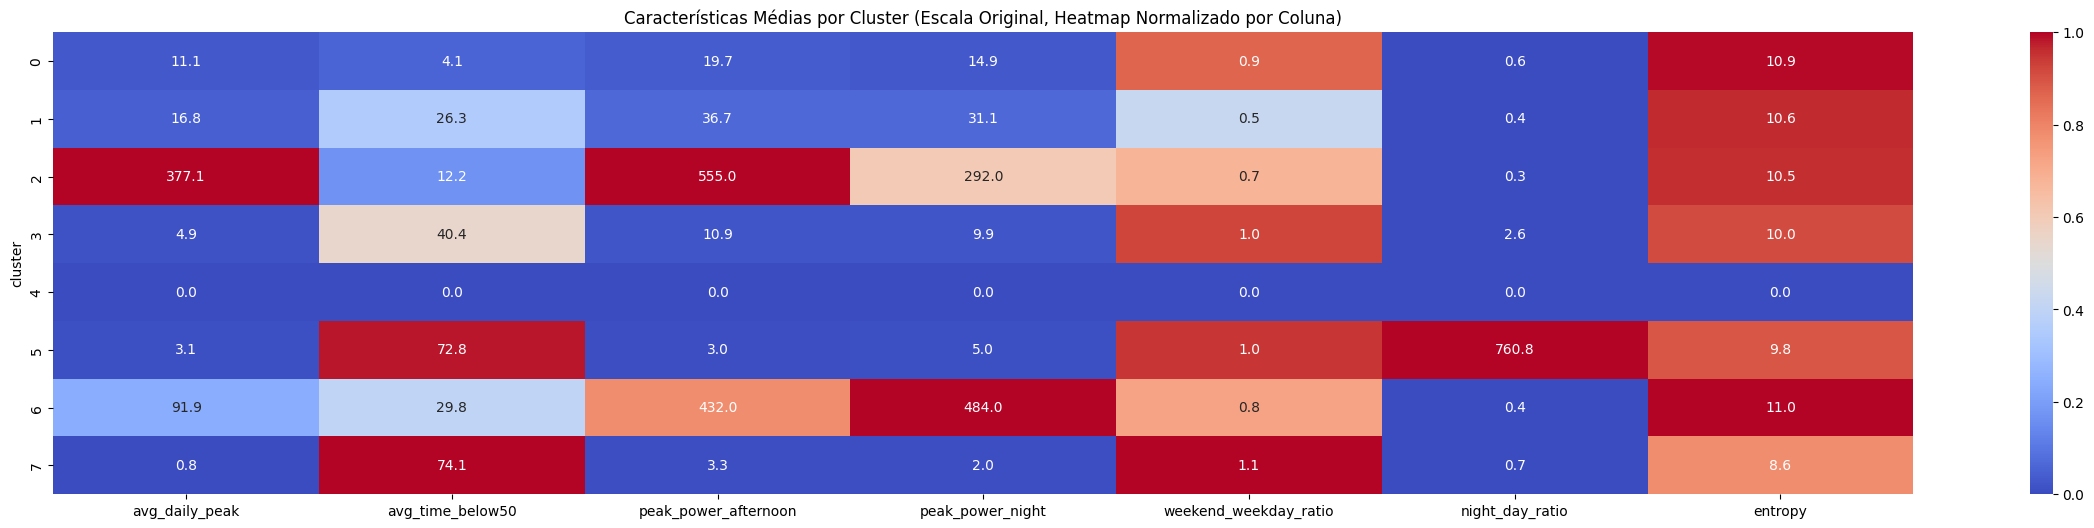

In [48]:
cluster_summary = feat_clust.groupby("cluster").mean()

cluster_summary_raw = pd.DataFrame(
    scaler.inverse_transform(cluster_summary),
    index=cluster_summary.index,
    columns=cluster_summary.columns
)

viz_scaled = (cluster_summary_raw - cluster_summary_raw.min()) / (cluster_summary_raw.max() - cluster_summary_raw.min())

plt.figure(figsize=(30,6))
sns.heatmap(viz_scaled, cmap="coolwarm", annot=cluster_summary_raw.round(1), fmt="", cbar=True)
plt.title("Características Médias por Cluster (Escala Original, Heatmap Normalizado por Coluna)")
plt.show()

| Cluster | Perfil energético                               | Tipo de instalações                      |
|---------|--------------------------------------------------|--------------------------------------------------------|
| 0       | Baixo consumo, constante e equilibrado entre semana e fim de semana | parques, oficinas, serviços moderados                 |
| 1       | Consumo baixo/médio, muito uso diurno           | escolas, pavilhões, centros sociais                   |
| 2       | Consumo extremamente elevado, consumo predominantemente diurno   | Torre do Lidador / Paços do Concelho |
| 3       | Consumo leve e intermitente                     | fontes, lagos, iluminação decorativa                  |
| 4       | Provável erro / outlier isolado                 | 1 único CPE sem padrão                                |
| 5       | Uso quase exclusivamente noturno                | Monumento da Avenida D. Manuel II                     |
| 6       | Consumo muito elevado, com picos tarde/noite    | Estádio Municipal                                     |
| 7       | Consumo baixo mas com picos de consumo          | auditório, parque, fontes                             |


O PCA permite representar os dados num espaço de 2 dimensões maximizando a variância, mas não preserva relações de proximidade entre os pontos.
Por isso, pode distorcer a estrutura real dos clusters.

Para avaliar se os clusters encontrados são realmente separados no espaço original, é preferível usar métodos não lineares como o t-SNE, que preservam vizinhanças e evidenciam agrupamentos naturais.

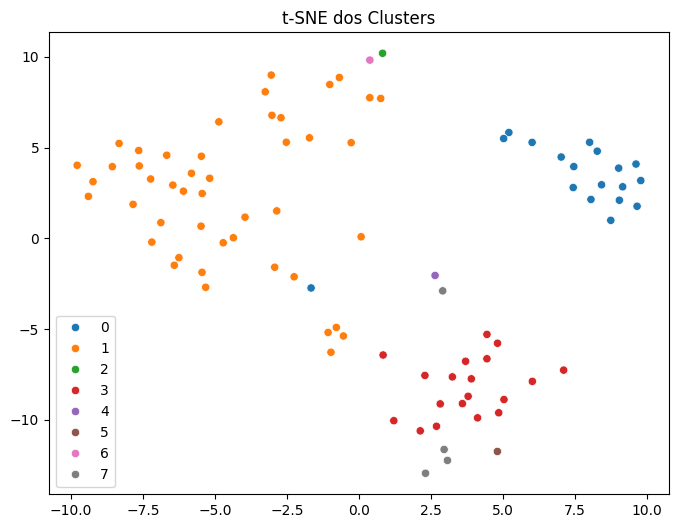

In [49]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=42)
coords_tsne = tsne.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords_tsne[:,0], y=coords_tsne[:,1],
    hue=cluster_labels, palette="tab10"
)
plt.title("t-SNE dos Clusters")
plt.show()

### Testar Subset de Features

Utilizar todas as variáveis nem sempre é o melhor

A pesquisa por subconjuntos ajuda a evitar ruído, redundância e variância irrelevante

Podem existir estruturas de clusters apenas em subespaços específicos

As distâncias degradam-se em alta dimensionalidade

Subconjuntos de variáveis tendem a produzir clusters mais claros e mais interpretáveis


Melhorar a qualidade da clusterização

Identificar grupos de variáveis realmente relevantes

Aumentar a separabilidade dos clusters

In [50]:
sil_scores = defaultdict(dict)
chi_scores = defaultdict(dict)
dbi_scores = defaultdict(dict)

cols = feat_scaled.columns.tolist()

for size in range(2, 6):
    for subset in combinations(cols, size):
        subset = list(subset)
        feat_name = ",".join(subset)

        feat_sub = feat_scaled[subset].copy()

        for k in range(2, 6):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(feat_sub)

            sil_scores[feat_name][k] = silhouette_score(feat_sub, labels)
            dbi_scores[feat_name][k] = davies_bouldin_score(feat_sub, labels)
            chi_scores[feat_name][k] = calinski_harabasz_score(feat_sub, labels)

weighted_score = defaultdict(dict)

for features in sil_scores:
    for k in sil_scores[features]:
        sil = sil_scores[features][k]
        dbi = dbi_scores[features][k]
        chi = chi_scores[features][k]

        dbi_inv = 1 / dbi

        weighted_score[features][k] = (w_sil * sil + w_db * dbi_inv + w_ch * chi)

rows = []

for features in sil_scores:
    for k in sil_scores[features]:
        rows.append({
            "Features": features,
            "k": k,
            "Silhouette": sil_scores[features][k],
            "Davies-Bouldin": dbi_scores[features][k],
            "Calinski-Harabasz": chi_scores[features][k],
            "Média Ponderada": weighted_score[features][k]
        })

results_df = pd.DataFrame(rows)
results_df = results_df.sort_values("Média Ponderada", ascending=False).reset_index(drop=True)
results_df.head(10)

Features  k  \
0                                        avg_daily_peak,night_day_ratio  3   
1                                   avg_daily_peak,peak_power_afternoon  2   
2                                        avg_daily_peak,night_day_ratio  2   
3                                               night_day_ratio,entropy  3   
4                                  peak_power_afternoon,night_day_ratio  2   
5                                       avg_daily_peak,peak_power_night  3   
6                                               night_day_ratio,entropy  2   
7                                      peak_power_night,night_day_ratio  2   
8                  avg_daily_peak,peak_power_afternoon,peak_power_night  3   
9  avg_daily_peak,peak_power_afternoon,peak_power_night,night_day_ratio  4   

   Silhouette  Davies-Bouldin  Calinski-Harabasz  Média Ponderada  
0    0.933142        0.030302         479.167842         7.346746  
1    0.926735        0.041596         187.761454         5.549571  
2    0.932923        0.043211          89.160928         5.374761  
3    0.907813        0.044481         250.505002         5.222569  
4    0.924294        0.049135          89.317479         4.809823  
5    0.899872        0.049873         213.521190         4.730052  
6    0.917734        0.050955          89.255494         4.659215  
7    0.922805        0.051210          89.244264         4.643760  
8    0.898368        0.051217         219.251767         4.623631  
9    0.887132        0.052178         203.238630         4.542774

In [51]:
best_row = results_df.iloc[0]
feat_best = feat_scaled[best_row["Features"].split(",")].copy()
#feat_best = feat_scaled[["inductive_peak_power_evening","capacitive_peak_power_morning"]].copy()
best_k = best_row["k"]
#best_k = 2

best_row

Features             avg_daily_peak,night_day_ratio
k                                                 3
Silhouette                                 0.933142
Davies-Bouldin                             0.030302
Calinski-Harabasz                        479.167842
Média Ponderada                            7.346746
Name: 0, dtype: object

In [52]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(feat_best)

feat_clust2 = feat_best.copy()
feat_clust2.loc[:, "cluster"] = cluster_labels

#pca = PCA(n_components=2)
#coords = pca.fit_transform(feat_best)

#coords = coords.T

feat_clust2.sort_values("cluster")

avg_daily_peak  night_day_ratio  cluster
CPE                                                           
PT0002000032936306KX       -0.278166        -0.028494        0
PT0002000107172384HT       -0.093118        -0.107870        0
PT0002000107046231FW       -0.177058        -0.114805        0
PT0002000106237165CF       -0.401432        -0.109241        0
PT0002000105483259QH       -0.381070        -0.104756        0
...                              ...              ...      ...
PT0002000068856906VS       -0.147514        -0.108107        0
PT0002000068859393XH        0.782034        -0.113035        0
PT0002000201936109ME       -0.380701        -0.111896        0
PT0002000103647515BL       -0.330763         9.485351        1
PT0002000078441876HB        8.650690        -0.112731        2

[91 rows x 3 columns]

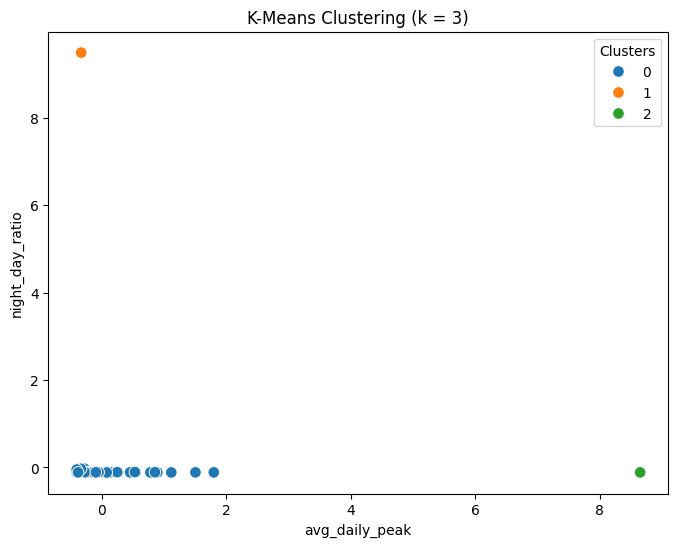

In [53]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=feat_best["avg_daily_peak"],
    y=feat_best["night_day_ratio"],
    hue=cluster_labels,
    palette='tab10',
    s=70
)

plt.title(f"K-Means Clustering (k = {best_k})")
plt.xlabel("avg_daily_peak")
plt.ylabel("night_day_ratio")
plt.legend(title="Clusters")
plt.show()

In [54]:
df_compare_pd = df_compare.to_pandas()
df_compare2 = feat_clust2.join(df_compare_pd.set_index("CPE"), on="CPE", how="left")
df_compare2 = df_compare2[["Descrição","cluster"]]

In [55]:
df_compare2[df_compare2['cluster'] == 0]

Descrição  cluster
CPE                                                                      
PT0002000032936306KX                                      PT0195        0
PT0002000032942455NH             EB1/JI de Gueifães - EDIFÍCIO 2        0
PT0002000032959511HP                                          --        0
PT0002000032966446CC                                  EB1 PADRÃO        0
PT0002000032968749YT                                EB1/JI ARCOS        0
...                                                          ...      ...
PT0002000125379984SH       Pavilhão Gimnodesportivo de Pedrouços        0
PT0002000131605602FL                                   AG PT0676        0
PT0002000133505542CK                   SEMÁFOROS ALTINO COELHO I        0
PT0002000133685986TF  ILUMINAÇÃO DECORATIVA RUA CENTRAL SOBREIRO        0
PT0002000201936109ME                                          --        0

[89 rows x 2 columns]

In [56]:
df_compare2[df_compare2['cluster'] == 1]

Descrição  cluster
CPE                                                             
PT0002000103647515BL  Monumento da Avenida D. Manuel II        1

In [57]:
df_compare2[df_compare2['cluster'] == 2]

Descrição  cluster
CPE                                                                      
PT0002000078441876HB  Torre do Lidador (e/ou Paços do Concelho?)        2

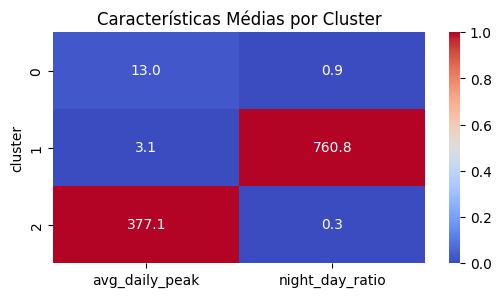

In [58]:
feat_clust2_raw = feat_pca[best_row["Features"].split(",")].copy()
feat_clust2_raw.loc[:, "cluster"] = cluster_labels

cluster_summary_raw = feat_clust2_raw.groupby("cluster").mean()

viz_scaled = (cluster_summary_raw - cluster_summary_raw.min()) / (cluster_summary_raw.max() - cluster_summary_raw.min())

plt.figure(figsize=(6,3))
sns.heatmap(viz_scaled, cmap="coolwarm", annot=cluster_summary_raw.round(1), fmt="", cbar=True)
plt.title("Características Médias por Cluster")
plt.show()

| Cluster | Perfil energético                               | Tipo de instalações                      |
|---------|--------------------------------------------------|--------------------------------------------------------|
| 0       | Baixo consumo, uso diurno e noturno equilibrado  | escolas, parques, fontes, pequenos serviços           |
| 1       | Consumo muito baixo, consumo predominantemente noturno  | Monumento da Avenida D. Manuel II              |
| 2       | Consumo extremamente elevado, consumo predominantemente diurno    | Torre do Lidador / Paços do Concelho |


### DBScan

In [59]:
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
min_samples_values = [3, 5, 7, 9, 10]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(feat_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = np.mean(labels == -1)

        # Silhouette só se houver pelo menos 2 clusters e nem tudo for ruído
        if n_clusters >= 2 and noise_frac < 0.95:
            mask = labels != -1
            sil = silhouette_score(feat_scaled[mask], labels[mask])
            weighted_score = 0.8 * sil + 0.2 * (1 / noise_frac)
        else:
            sil = np.nan
            weighted_score = np.nan

        results.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "Silhouette": sil,
            "Fração de ruído": noise_frac,
            "Média Ponderada": weighted_score
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Média Ponderada", ascending=False)
results_df

eps  min_samples  n_clusters  Silhouette  Fração de ruído  Média Ponderada
10  0.7            3           3    0.503972         0.230769         1.269844
11  0.7            5           3    0.513445         0.263736         1.169090
12  0.7            7           3    0.589680         0.362637         1.023259
13  0.7            9           3    0.642391         0.450549         0.957815
14  0.7           10           3    0.665987         0.472527         0.956045
7   0.5            7           3    0.763967         0.692308         0.900062
6   0.5            5           3    0.730253         0.637363         0.897995
0   0.3            3           4    0.740746         0.747253         0.860244
5   0.5            3           5    0.480167         0.527473         0.763300
1   0.3            5           1         NaN         0.923077              NaN
2   0.3            7           0         NaN         1.000000              NaN
3   0.3            9           0         NaN         1.000000              NaN
4   0.3           10           0         NaN         1.000000              NaN
8   0.5            9           1         NaN         0.846154              NaN
9   0.5           10           1         NaN         0.846154              NaN
15  1.0            3           1         NaN         0.153846              NaN
16  1.0            5           1         NaN         0.153846              NaN
17  1.0            7           1         NaN         0.153846              NaN
18  1.0            9           1         NaN         0.175824              NaN
19  1.0           10           1         NaN         0.175824              NaN
20  1.5            3           1         NaN         0.087912              NaN
21  1.5            5           1         NaN         0.087912              NaN
22  1.5            7           1         NaN         0.109890              NaN
23  1.5            9           1         NaN         0.109890              NaN
24  1.5           10           1         NaN         0.120879              NaN

In [60]:
# best_eps = 0.5
# best_min_samples = 5

best_eps = results_df.iloc[0]["eps"]
best_min_samples = int(results_df.iloc[0]["min_samples"])

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_db = dbscan.fit_predict(feat_scaled)

# Copiar o dataframe de features (sem NaN) e adicionar o cluster DBSCAN
feat_clust_dbs = feat_scaled.copy()
feat_clust_dbs.loc[:, "cluster_dbscan"] = labels_db

# Ver quantos clusters + ruído
print("Labels únicos:", sorted(set(labels_db.tolist())))
print("N.º de clusters (sem ruído):", len(set(labels_db)) - (1 if -1 in labels_db else 0))
print("Percentagem de ruído:", np.mean(labels_db == -1))

Labels únicos: [-1, 0, 1, 2]
N.º de clusters (sem ruído): 3
Percentagem de ruído: 0.23076923076923078


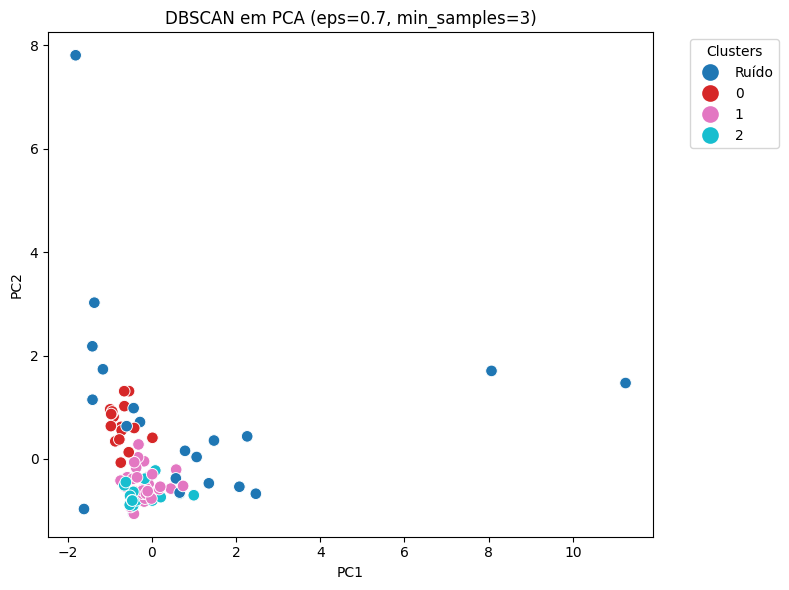

In [61]:
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_scaled)

unique_clusters = np.unique(labels_db)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=labels_db,
    palette=colors.tolist(),
    s=70
)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label="Ruído" if uc == -1 else f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

plt.title(f"DBSCAN em PCA (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

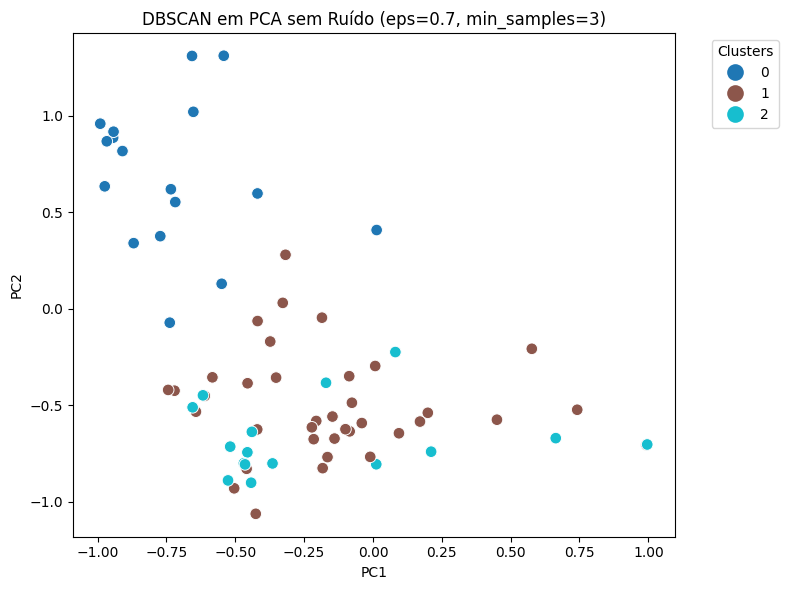

In [62]:
unique_clusters = np.unique(labels_db)[1:]
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=np.where(labels_db == -1, np.nan, labels_db),
    palette=colors.tolist(),
    s=70
)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label="Ruído" if uc == -1 else f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

plt.title(f"DBSCAN em PCA sem Ruído (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [63]:
pca = PCA(n_components=3)
coords = pca.fit_transform(feat_scaled)

coords = coords.T

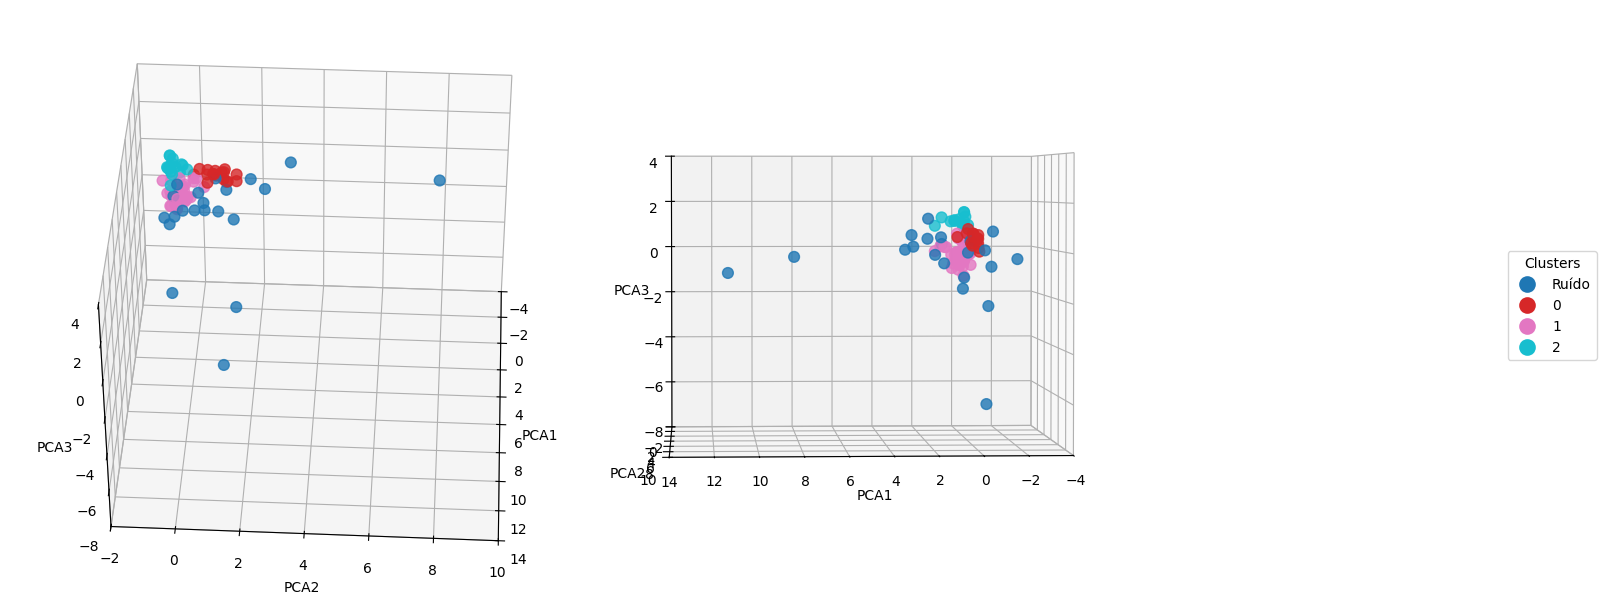

In [64]:
fig = plt.figure(figsize=(20, 10))

# Define the views you want
views = [
    (40, 3),
    (2, 87)
]

unique_clusters = np.unique(labels_db)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

point_colors = [cluster_to_color[c] for c in labels_db]

for i, (elev, azim) in enumerate(views, start=1):
    ax = fig.add_subplot(1, 3, i, projection="3d")

    ax.scatter(
        coords[0],
        coords[1],
        coords[2],
        c=point_colors,
        s=60,
        alpha=0.8
    )

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")

    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_zticks(ax.get_zticks())

    ax.view_init(elev=elev, azim=azim)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label="Ruído" if uc == -1 else f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

fig.legend(handles=handles, loc="center right", title="Clusters")

for ax in fig.axes:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 2, pos.height * 1.3])

plt.show()

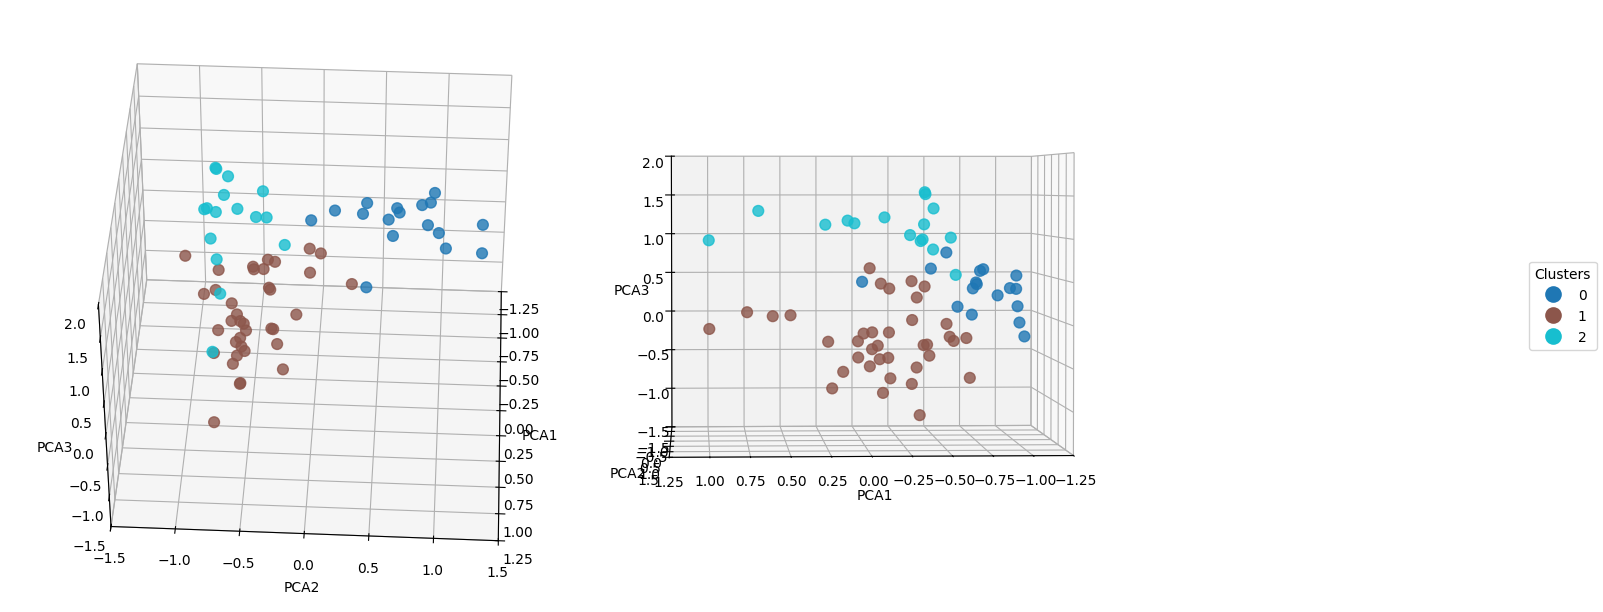

In [65]:
pca = PCA(n_components=3)
coords = pca.fit_transform(feat_scaled)

mask = labels_db != -1
coords_no_noise = coords[mask]
labels_no_noise = labels_db[mask]

unique_clusters = np.unique(labels_no_noise)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

point_colors = [cluster_to_color[c] for c in labels_no_noise]

fig = plt.figure(figsize=(20, 10))
for i, (elev, azim) in enumerate(views, start=1):
    ax = fig.add_subplot(1, 3, i, projection="3d")

    ax.scatter(
        coords_no_noise[:,0],
        coords_no_noise[:,1],
        coords_no_noise[:,2],
        c=point_colors,
        s=60,
        alpha=0.8
    )

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")

    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_zticks(ax.get_zticks())

    ax.view_init(elev=elev, azim=azim)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label=f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

fig.legend(handles=handles, loc="center right", title="Clusters")

for ax in fig.axes:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 2, pos.height * 1.3])

plt.show()

In [66]:
df_compare_dbs = feat_clust_dbs.join(df_compare_pd.set_index("CPE"), on="CPE", how="left")
df_compare_dbs = df_compare_dbs[["Descrição","cluster_dbscan"]]

In [67]:
df_compare_dbs[df_compare_dbs['cluster_dbscan'] == 0]

Descrição  \
CPE                                                                   
PT0002000032936306KX                                         PT0195   
PT0002000032966446CC                                     EB1 PADRÃO   
PT0002000068856952LS                              Parque das Fontes   
PT0002000069803182JW         SISTEMA DE REGA do Monumento PIRÂMIDES   
PT0002000073598156DE                                  LAGO MANINHOS   
PT0002000073717386HC                  Fonte Decorativa de Pedrouços   
PT0002000078233981HJ  Pavilhão Municipal de Águas Santas II - Corim   
PT0002000079901964CJ                                         PT0618   
PT0002000085555547GN                                HORTO Municipal   
PT0002000108315818YN                                  LAGO LAVRADOR   
PT0002000110090564GD              Pavilhão Municipal de Gueifães II   
PT0002000112026362NN     ILUMINAÇÃO DECORATIVA da RUA SIMÃO BOLÍVAR   
PT0002000112171317NK    ILUMINAÇÃO DECORATIVA da RUA NICOLAU NASONI   
PT0002000117822355RM           Complexo Municipal DE SÃO PEDRO FINS   
PT0002000125379984SH          Pavilhão Gimnodesportivo de Pedrouços   
PT0002000131605602FL                                      AG PT0676   
PT0002000133685986TF     ILUMINAÇÃO DECORATIVA RUA CENTRAL SOBREIRO   

                      cluster_dbscan  
CPE                                   
PT0002000032936306KX               0  
PT0002000032966446CC               0  
PT0002000068856952LS               0  
PT0002000069803182JW               0  
PT0002000073598156DE               0  
PT0002000073717386HC               0  
PT0002000078233981HJ               0  
PT0002000079901964CJ               0  
PT0002000085555547GN               0  
PT0002000108315818YN               0  
PT0002000110090564GD               0  
PT0002000112026362NN               0  
PT0002000112171317NK               0  
PT0002000117822355RM               0  
PT0002000125379984SH               0  
PT0002000131605602FL               0  
PT0002000133685986TF               0

In [68]:
df_compare_dbs[df_compare_dbs['cluster_dbscan'] == 1]

Descrição  \
CPE                                                                          
PT0002000032942455NH                       EB1/JI de Gueifães - EDIFÍCIO 2   
PT0002000032968749YT                                          EB1/JI ARCOS   
PT0002000032969229AC                                       EB1/JI FERREIRÓ   
PT0002000032976997LZ                                        EB1/JI PROZELA   
PT0002000032990792KD                  EB1/JI PEDRAS RUBRAS - EDIFÍCIO NOVO   
PT0002000032993611ME               Centro Escolar GUARDA - EDIFÍCIO ANTIGO   
PT0002000033016394FN                             CONSERVATÓRIO MÚSICA Maia   
PT0002000033039837ZH                                                    --   
PT0002000033074862LZ                              Centro Escolar de Mandim   
PT0002000033094187PL                           OFICINAS GERAIS - GABINETES   
PT0002000033171958DG                                             CPCJ Maia   
PT0002000033186037TF                            OFICINAS GERAIS - OFICINAS   
PT0002000033254603ZX                                           EB1/JI PAÇO   
PT0002000065523872AA                                       Fórum Jovem - A   
PT0002000068856655YV                                   Fórum Jovem da Maia   
PT0002000068857099AR                 Campo Municipal de Jogos de Milheirós   
PT0002000068857897ZV                                                    --   
PT0002000068857909SY                         Pavilhão Municipal de Moreira   
PT0002000068859187RL                                   EB1/JI D. Manuel II   
PT0002000068859382XF                                                    --   
PT0002000073231742VK                            Centro Escolar de Moutidos   
PT0002000073481266XH                                          Casa do Alto   
PT0002000075637532JB                       EB1/JI de Gueifães (Edifício I)   
PT0002000078207354XC  Pavilhão Municipal de Águas Santas III - Formigueiro   
PT0002000078294957RQ                                        EB1/JI da Maia   
PT0002000082592498EF                         LOJA JUVENTUDE SÃO PEDRO FINS   
PT0002000100742616GC                                      EB1/JI PORTO BOM   
PT0002000101964938LF                                                    --   
PT0002000107046231FW                              EB1/JI de Santa Cristina   
PT0002000109837807PE                        Pavilhão Municipal de Nogueira   
PT0002000110607652SB                                                    --   
PT0002000115031201VQ                             EB1/JI do Castêlo da Maia   
PT0002000115673389QK                           Centro Escolar Maia-Estação   
PT0002000115700602GW                              Centro Escolar da Gandra   
PT0002000119303492KB                               Centro Escolar da Pícua   
PT0002000120237616VJ                             Centro Escolar de Folgosa   
PT0002000123648159KR                                    EB1/JI de Currrais   

                      cluster_dbscan  
CPE                                   
PT0002000032942455NH               1  
PT0002000032968749YT               1  
PT0002000032969229AC               1  
PT0002000032976997LZ               1  
PT0002000032990792KD               1  
PT0002000032993611ME               1  
PT0002000033016394FN               1  
PT0002000033039837ZH               1  
PT0002000033074862LZ               1  
PT0002000033094187PL               1  
PT0002000033171958DG               1  
PT0002000033186037TF               1  
PT0002000033254603ZX               1  
PT0002000065523872AA               1  
PT0002000068856655YV               1  
PT0002000068857099AR               1  
PT0002000068857897ZV               1  
PT0002000068857909SY               1  
PT0002000068859187RL               1  
PT0002000068859382XF               1  
PT0002000073231742VK               1  
PT0002000073481266XH               1  
PT0002000075637532JB               1  
PT0002000078207354XC               1  
PT000200

In [69]:
df_compare_dbs[df_compare_dbs['cluster_dbscan'] == 2]

Descrição  \
CPE                                                                      
PT0002000053093191SV                                   Fórum Jovem - C   
PT0002000066469574LZ                  POLIDESPORTIVO Municipal Lidador   
PT0002000068856781NM  Torre do Lidador/Paços do Concelho (Servidores?)   
PT0002000068856906VS                                Quinta dos Cónegos   
PT0002000069698702RB                       ARMAZÉNS do BAIRRO SOBREIRO   
PT0002000077394934QY                         Aeródromo de Vilar de Luz   
PT0002000082549706RH    Complexo de Educação Ambiental da Quinta Gruta   
PT0002000084414998AX               Centro DOCUMENTAL JOÃO ÁLVARO ROCHA   
PT0002000085641795MX                         LOJA da JUVENTUDE GEMUNDE   
PT0002000102936404ME                         Parque Urbano de Moutidos   
PT0002000106237165CF                    LOJA JUVENTUDE VILA NOVA TELHA   
PT0002000107172384HT                              Quinta da Caverneira   
PT0002000107332489XW               SEMÁFOROS IGREJA Santa MARIA Avioso   
PT0002000120320157HF  SEMÁFOROS ECOCAMINHO - R CONSELHEIRO COSTA AROSO   
PT0002000123801456QA                       LAGO COOPERATIVA SIDERURGIA   
PT0002000133505542CK                         SEMÁFOROS ALTINO COELHO I   

                      cluster_dbscan  
CPE                                   
PT0002000053093191SV               2  
PT0002000066469574LZ               2  
PT0002000068856781NM               2  
PT0002000068856906VS               2  
PT0002000069698702RB               2  
PT0002000077394934QY               2  
PT0002000082549706RH               2  
PT0002000084414998AX               2  
PT0002000085641795MX               2  
PT0002000102936404ME               2  
PT0002000106237165CF               2  
PT0002000107172384HT               2  
PT0002000107332489XW               2  
PT0002000120320157HF               2  
PT0002000123801456QA               2  
PT0002000133505542CK               2

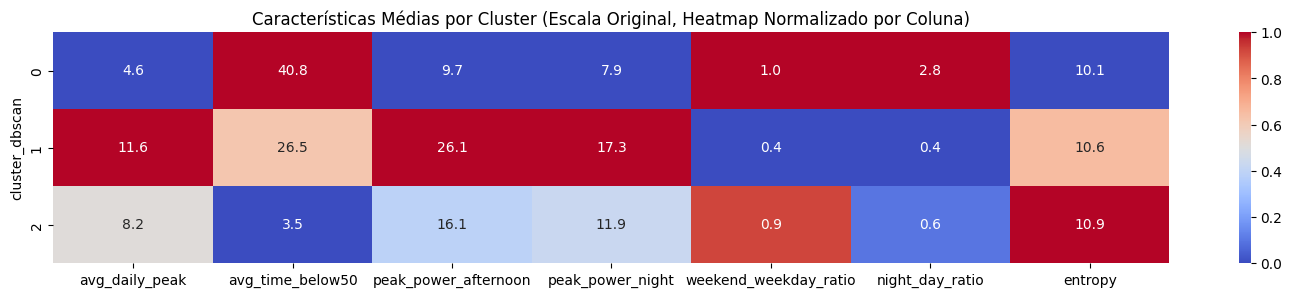

In [70]:
cluster_summary = feat_clust_dbs[df_compare_dbs['cluster_dbscan'] != -1].groupby("cluster_dbscan").mean()

cluster_summary_raw = pd.DataFrame(
    scaler.inverse_transform(cluster_summary),
    index=cluster_summary.index,
    columns=cluster_summary.columns
)

viz_scaled = (cluster_summary_raw - cluster_summary_raw.min()) / (cluster_summary_raw.max() - cluster_summary_raw.min())

plt.figure(figsize=(18,3))
sns.heatmap(viz_scaled, cmap="coolwarm", annot=cluster_summary_raw.round(1), fmt="", cbar=True)
plt.title("Características Médias por Cluster (Escala Original, Heatmap Normalizado por Coluna)")
plt.show()

| Cluster | Perfil energético                               | Tipo de instalações                      |
|---------|--------------------------------------------------|--------------------------------------------------------|
| 0       | Consumo baixo, picos exporádicos de consumo, consumo noturno elevado, equilibrio entre dias úteis e fim de semana | parques, iluminação decorativa, lagos  |
| 1       | Consumo alto, uso intenso durante o dia, pouco consumo ao fim de semana, consumo mais diurno  | escolas, centros escolares, escritórios                   |
| 2       | Consumo moderado, porém constante, equilibrio entre dias úteis e fim de semana       | pavilhões, campos desportivos, armazéns, centros culturais |

## Modelação Supervisionada — Previsão do Consumo Energético

Após a identificação de padrões de consumo através de técnicas de *clustering* não supervisionado, esta fase do projeto tem como objetivo a **previsão do consumo energético da semana seguinte** para os edifícios municipais da Maia.

Foram consideradas duas abordagens complementares:

### 1. Previsão Baseada em Séries Temporais
Nesta abordagem, a previsão é realizada **individualmente para cada uma das 3 CPEs com maior gastos energeticos**, utilizando apenas a evolução temporal da potência ativa. Os dados foram agregados à resolução horária (1h) e divididos temporalmente em **70% para treino** e **30% para teste**.

Foram avaliados 3 modelos de maneira a poder estabelecer uma comparação:
- **Baseline de persistência semanal**
- **SARIMA**
- **LSTM**

### 2. Previsão Semanal Baseada em Features 
Numa segunda abordagem, foi construída uma base de dados semanal com **features por CPE** com o principal objetivo de prever o **consumo médio da semana seguinte**.

Foram avaliados os seguintes modelos de regressão supervisionada:
- **Baseline**: média histórica do conjunto de treino;
- **Random Forest**;
- **XGBoost**, com otimização de hiperparâmetros através do Optuna;
- **MLP (Multi-Layer Perceptron)**.



In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Série temporal — limpeza (15 min) e agregação para 1h
# ------------------------------------------------------------
def get_series_for_cpe(prep_pdf, cpe):
    s = (
        prep_pdf[prep_pdf["CPE"] == cpe]
        .sort_values("tstamp")
        .set_index("tstamp")["PotActiva"]
    )
    # Grelha regular de 15 min + interpolação
    s = s.asfreq("15min").interpolate(limit_direction="both")
    return s

# Split temporal 70/30
def split_series_train_test(s, train_frac=0.7):
    cutoff = int(len(s) * train_frac)
    return s.iloc[:cutoff], s.iloc[cutoff:]

# ------------------------------------------------------------
# Baseline semanal (1h): valor observado 1 semana antes (168h)
# ------------------------------------------------------------
def baseline_week_before_1h(series_1h):
    lag = 24 * 7  # 168 horas = 1 semana
    shifted = series_1h.shift(lag)
    mask = ~shifted.isna()
    return shifted[mask], series_1h[mask]

# ------------------------------------------------------------
# SARIMA/SARIMAX (1h) — previsão de 1 semana
# ------------------------------------------------------------
def run_sarima_for_cpe(prep_pdf, cpe, show_plots=False):
    print(f"\n=== A processar CPE {cpe} ===")

    # 1) Série limpa a 15 min
    s_15m = get_series_for_cpe(prep_pdf, cpe)

    # 2) Agregar para 1h (média horária)
    s_1h = s_15m.resample("1h").mean().interpolate(limit_direction="both")

    # 3) Split 70/30
    train, test = split_series_train_test(s_1h)

    # Prever apenas 1 semana do teste (168 horas)
    horizon = 24 * 7
    test_week = test.iloc[:horizon]

    # --------------------------------------------------------
    # BASELINE (semana anterior)
    # --------------------------------------------------------
    full = pd.concat([train, test])
    y_pred_base, y_true_base = baseline_week_before_1h(full)

    # alinhar baseline com a semana a prever
    y_pred_base = y_pred_base.loc[test_week.index]
    y_true_base = y_true_base.loc[test_week.index]

    mae_base = mean_absolute_error(y_true_base, y_pred_base)
    rmse_base = sqrt(mean_squared_error(y_true_base, y_pred_base))
    print(f"Baseline - MAE={mae_base:.3f}, RMSE={rmse_base:.3f}")

    # --------------------------------------------------------
    # SARIMAX (sazonalidade diária = 24h)
    # --------------------------------------------------------
    model = SARIMAX(
        train,
        order=(1, 0, 1),
        seasonal_order=(1, 1, 1, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    fit = model.fit(disp=False, maxiter=30, method="lbfgs", low_memory=True)

    forecast = fit.get_forecast(steps=horizon).predicted_mean
    forecast.index = test_week.index

    mae_sarima = mean_absolute_error(test_week, forecast)
    rmse_sarima = sqrt(mean_squared_error(test_week, forecast))
    print(f"SARIMA - MAE={mae_sarima:.3f}, RMSE={rmse_sarima:.3f}")

    # --------------------------------------------------------
    # Plot opcional
    # --------------------------------------------------------
    if show_plots:
        plt.figure(figsize=(10, 4))
        plt.plot(test_week.index, test_week.values, label="Real")
        plt.plot(forecast.index, forecast.values, label="SARIMA")
        plt.plot(y_pred_base.index, y_pred_base.values, label="Baseline", alpha=0.6)
        plt.title(f"CPE {cpe} — Previsão da Semana Seguinte (1h)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "CPE": cpe,
        "Baseline MAE": mae_base,
        "Baseline RMSE": rmse_base,
        "SARIMA MAE": mae_sarima,
        "SARIMA RMSE": rmse_sarima
    }



=== A processar CPE PT0002000078441876HB ===
Baseline - MAE=27.574, RMSE=38.028
SARIMA - MAE=58.643, RMSE=76.680


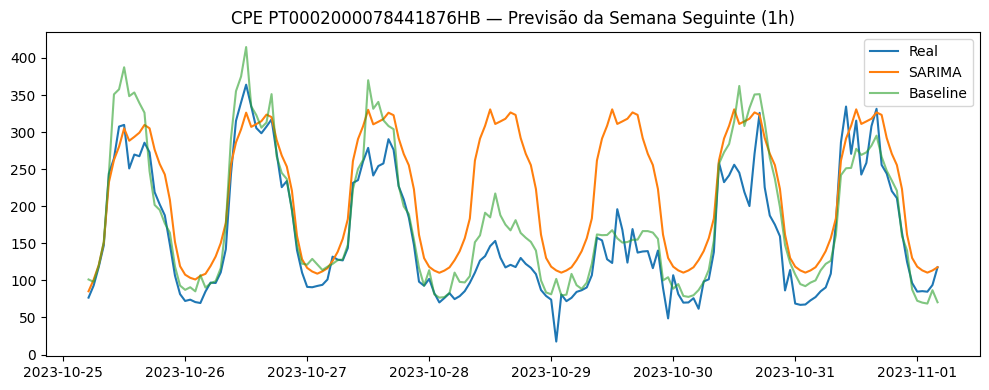


=== A processar CPE PT0002000100113293JT ===
Baseline - MAE=0.250, RMSE=0.373
SARIMA - MAE=7.752, RMSE=8.070


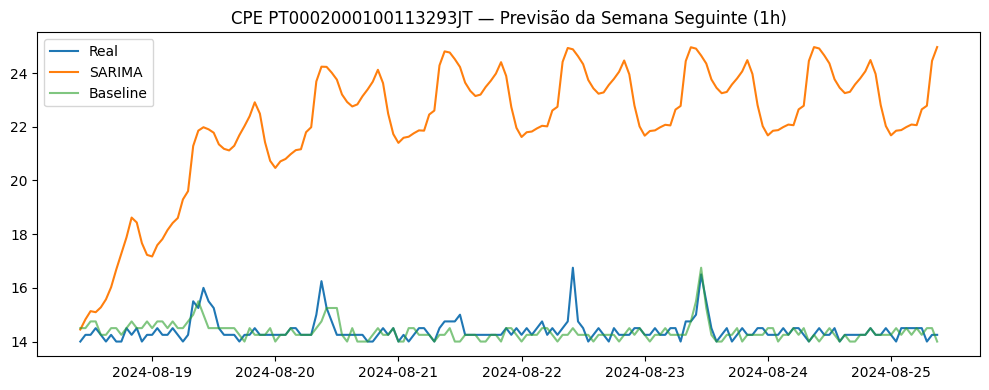


=== A processar CPE PT0002000068856781NM ===
Baseline - MAE=0.438, RMSE=0.624
SARIMA - MAE=1.825, RMSE=1.989


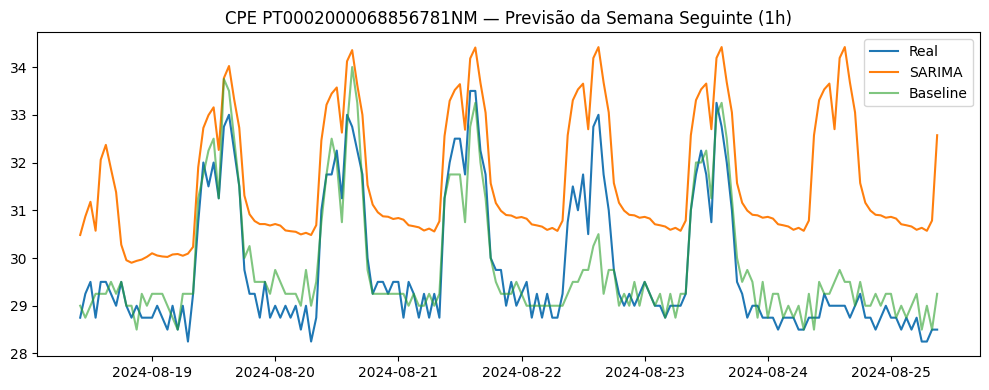

CPE  Baseline MAE  Baseline RMSE  SARIMA MAE  SARIMA RMSE
0  PT0002000078441876HB     27.573661      38.027541   58.643005    76.679984
1  PT0002000100113293JT      0.250000       0.373011    7.752211     8.069938
2  PT0002000068856781NM      0.437500       0.623808    1.824793     1.989331

In [110]:
# EXECUTAR PARA O TOP 3

results = []
for cpe in top3_list:
    results.append(run_sarima_for_cpe(prep_pdf, cpe, show_plots=True))

results_df = pd.DataFrame(results)
results_df

#### **Análise dos Resultados do SARIMA**
Os resultados obtidos com o modelo SARIMA evidenciam comportamentos distintos consoante o perfil de consumo do edifício. Em CPEs com padrões regulares e sazonalidade bem definida, apresenta melhor comportamento no entanto analisando os gráficos é possivel analisar ainda grandes erros na previsão comparando com o baseline que é um modelo bastante mais simples a nivel de complexidade, e ainda assim apresenta muito melhores resultados nas metricas de erro.
O comportamento observado reflete limitações conhecidas deste tipo de modelos, nomeadamente a assunção de relações lineares e de estacionariedade local, tornando-os pouco robustos a padrões complexos ou mudanças abruptas de regime.


### LSTM

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# ------------------------------------------------------------
# Auxiliares
# ------------------------------------------------------------
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def build_lstm(seq_length):
    model = keras.Sequential([
        keras.layers.LSTM(32, return_sequences=True, input_shape=(seq_length, 1)),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(16),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss="mse",
        metrics=["mae"]
    )
    return model

# Inferência acelerada (TensorFlow graph mode)
@tf.function
def lstm_step(model, x):
    return model(x, training=False)

# ------------------------------------------------------------
# Função principal (RÁPIDA)
# ------------------------------------------------------------
def run_lstm_weekly_rolling_fast(
    prep_pdf,
    cpe,
    seq_length=72,          # ↓ mais rápido que 168, ainda informativo
    week_horizon=168,
    max_weeks_test=8,       # ↓ LIMITA o teste (MUITO IMPORTANTE)
    show_plots=True,
    seed=42,
    clip_scaled_pred=False
):
    # Reprodutibilidade
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # 1) Série horária
    s_1h = (
        prep_pdf[prep_pdf["CPE"] == cpe]
        .sort_values("tstamp")
        .set_index("tstamp")["PotActiva"]
        .asfreq("15min").interpolate(limit_direction="both")
        .resample("1h").mean().interpolate()
    )

    # 2) Split 70/30
    cutoff = int(len(s_1h) * 0.7)
    train = s_1h.iloc[:cutoff]
    test  = s_1h.iloc[cutoff:]

    # Limitar teste a N semanas
    test = test.iloc[:max_weeks_test * week_horizon]

    # 3) Scaling
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1,1)).flatten()

    full = pd.concat([train, test])
    full_scaled = scaler.transform(full.values.reshape(-1,1)).flatten()

    train_len = len(train)
    test_len  = len(test)

    # 4) Treino LSTM (one-step no treino)
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = build_lstm(seq_length)

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )

    model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=256,
        callbacks=[early_stop],
        verbose=0
    )

    # ------------------------------------------------------------
    # Rolling weekly (168h)
    # ------------------------------------------------------------
    y_pred_scaled = np.full(test_len, np.nan)

    start = train_len
    pos = 0

    while pos < test_len:
        steps = min(week_horizon, test_len - pos)

        last_seq = full_scaled[start - seq_length : start].copy()
        preds = []

        for _ in range(steps):
            x_in = last_seq.reshape(1, seq_length, 1)
            p = float(lstm_step(model, x_in)[0, 0])

            if clip_scaled_pred:
                p = np.clip(p, 0.0, 1.0)

            preds.append(p)
            last_seq = np.append(last_seq[1:], p)

        y_pred_scaled[pos:pos+steps] = preds

        start += steps
        pos   += steps

    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

    # ------------------------------------------------------------
    # Baseline semanal (semana anterior real)
    # ------------------------------------------------------------
    baseline = np.full(test_len, np.nan)
    week = week_horizon

    prev = train.values[-week:]
    baseline[:min(test_len, week)] = np.tile(prev, int(np.ceil(len(prev)/week)))[:min(test_len, week)]

    k = week
    while k < test_len:
        prev_real = test.values[k-week:k]
        steps = min(week, test_len - k)
        baseline[k:k+steps] = prev_real[:steps]
        k += steps

    # ------------------------------------------------------------
    # Métricas
    # ------------------------------------------------------------
    y_true = test.values
    idx = test.index

    def metrics(a, b):
        return mean_absolute_error(a, b), sqrt(mean_squared_error(a, b))

    mae_all, rmse_all = metrics(y_true, y_pred)
    zoom = min(week, test_len)
    mae_w1, rmse_w1 = metrics(y_true[:zoom], y_pred[:zoom])

    # ------------------------------------------------------------
    # Gráficos
    # ------------------------------------------------------------
    if show_plots:
        plt.figure(figsize=(14,4))
        plt.plot(idx, y_true, label="Real", linewidth=2)
        plt.plot(idx, y_pred, label="LSTM (rolling semanal)", alpha=0.85)
        plt.plot(idx, baseline, label="Baseline", linestyle="--", alpha=0.7)
        plt.title(f"CPE {cpe} — Teste completo (limitado)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(14,4))
        plt.plot(idx[:zoom], y_true[:zoom], label="Real", linewidth=2)
        plt.plot(idx[:zoom], y_pred[:zoom], label="LSTM", alpha=0.85)
        plt.plot(idx[:zoom], baseline[:zoom], label="Baseline", linestyle="--", alpha=0.7)
        plt.title(f"CPE {cpe} — Zoom na 1.ª semana do teste")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "CPE": cpe,
        "seq_length": seq_length,
        "weeks_tested": max_weeks_test,
        "MAE_test": mae_all,
        "RMSE_test": rmse_all,
        "MAE_week1": mae_w1,
        "RMSE_week1": rmse_w1
    }


C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


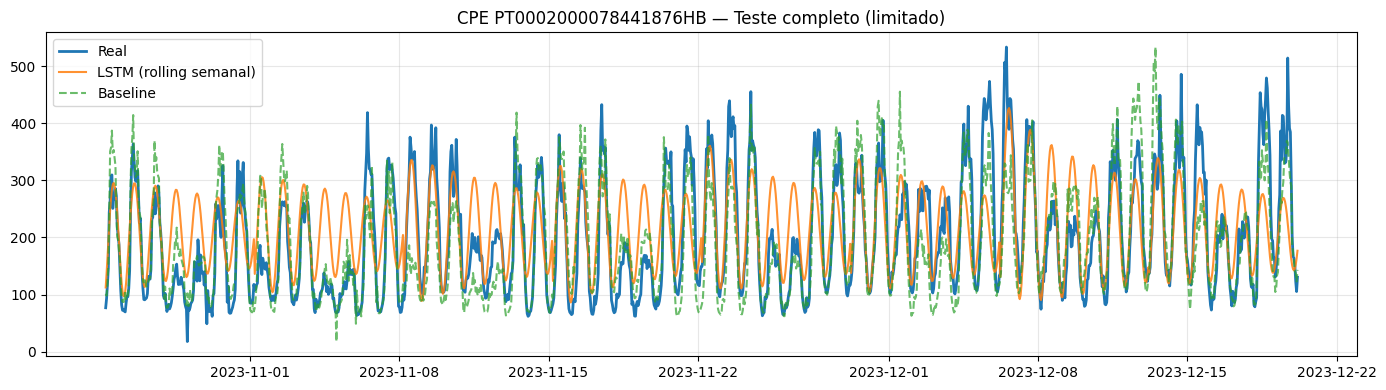

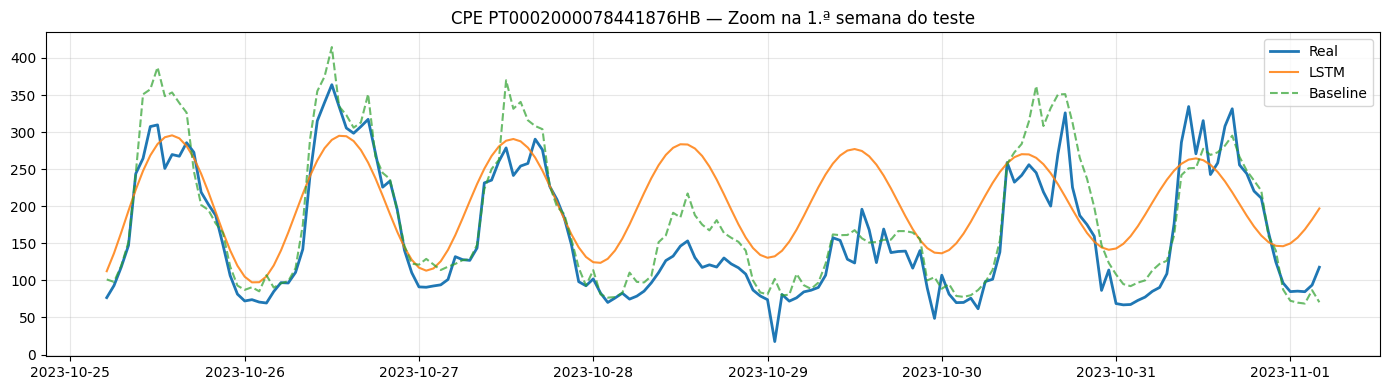

C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [98]:
results = []
for cpe in top3_list:
    r = run_lstm_weekly_rolling_fast(
        prep_pdf,
        cpe,
        seq_length=72,
        max_weeks_test=8,
        show_plots=True
    )
    results.append(r)

results_df = pd.DataFrame(results)
results_df


In [ ]:
def run_sarima_for_cpe_with_predictions(prep_pdf, cpe):
    """
    Retorna as previsões do SARIMA, Baseline e valores reais para a primeira semana
    """
    print(f"\n=== A processar CPE {cpe} ===")
    
    s_15m = get_series_for_cpe(prep_pdf, cpe)
    s_1h = s_15m.resample("1h").mean().interpolate()
    
    train, test = split_series_train_test(s_1h)
    
    horizon = 24 * 7
    test_week = test.iloc[:horizon]
    
    # BASELINE
    full = pd.concat([train, test])
    y_pred_base, y_true_base = baseline_week_before(full)
    y_pred_base = y_pred_base.loc[test_week.index]
    y_true_base = y_true_base.loc[test_week.index]
    
    # SARIMA
    model = SARIMAX(
        train,
        order=(1,0,1),
        seasonal_order=(1,1,1,24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    fit = model.fit(disp=False, maxiter=30, method="lbfgs", low_memory=True)
    forecast = fit.get_forecast(steps=horizon).predicted_mean
    forecast.index = test_week.index
    
    return {
        'real': test_week,
        'baseline': y_pred_base,
        'sarima': forecast,
        'cpe': cpe
    }

# Executar para os 3 CPEs e coletar resultados SARIMA
sarima_results = []
for cpe in top3_list:
    sarima_results.append(run_sarima_for_cpe_with_predictions(prep_pdf, cpe))

# Executar LSTM (já retorna as previsões)
lstm_results = []
for cpe in top3_list:
    r = run_lstm_weekly_rolling_fast(
        prep_pdf,
        cpe,
        seq_length=72,
        max_weeks_test=8,
        show_plots=False  # desligar plots individuais
    )
    lstm_results.append(r)

# Obter previsões LSTM para a primeira semana
def get_lstm_week1_predictions(prep_pdf, cpe, seq_length=72):
    """Retorna previsões LSTM apenas para a primeira semana"""
    np.random.seed(42)
    tf.random.set_seed(42)
    
    s_1h = (
        prep_pdf[prep_pdf["CPE"] == cpe]
        .sort_values("tstamp")
        .set_index("tstamp")["PotActiva"]
        .asfreq("15min").interpolate(limit_direction="both")
        .resample("1h").mean().interpolate()
    )
    
    cutoff = int(len(s_1h) * 0.7)
    train = s_1h.iloc[:cutoff]
    test = s_1h.iloc[cutoff:]
    
    week_horizon = 168
    test = test.iloc[:week_horizon]
    
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1,1)).flatten()
    
    full = pd.concat([train, test])
    full_scaled = scaler.transform(full.values.reshape(-1,1)).flatten()
    
    train_len = len(train)
    
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    model = build_lstm(seq_length)
    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True
    )
    
    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=256,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Previsão rolling para a primeira semana
    y_pred_scaled = np.full(week_horizon, np.nan)
    last_seq = full_scaled[train_len - seq_length : train_len].copy()
    
    for i in range(week_horizon):
        x_in = last_seq.reshape(1, seq_length, 1)
        p = float(model(x_in, training=False)[0, 0])
        y_pred_scaled[i] = p
        last_seq = np.append(last_seq[1:], p)
    
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
    
    return pd.Series(y_pred, index=test.index)

# Coletar previsões LSTM
lstm_predictions = []
for cpe in top3_list:
    lstm_predictions.append({
        'cpe': cpe,
        'lstm': get_lstm_week1_predictions(prep_pdf, cpe)
    })

# PLOTAR TODOS OS MODELOS JUNTOS
map_desc = df_compare.to_pandas().set_index("CPE")["Descrição"].to_dict()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for i, (cpe, ax) in enumerate(zip(top3_list, axes)):
    # Dados do SARIMA
    s = sarima_results[i]
    
    # Dados do LSTM
    lstm_pred = lstm_predictions[i]['lstm']
    
    # Plot
    ax.plot(s['real'].index, s['real'].values, 
            label='Real', linewidth=2.5, color='black')
    
    ax.plot(s['baseline'].index, s['baseline'].values, 
            label='Baseline', linestyle='--', alpha=0.7, linewidth=2)
    
    ax.plot(s['sarima'].index, s['sarima'].values, 
            label='SARIMA', alpha=0.85, linewidth=2)
    
    ax.plot(lstm_pred.index, lstm_pred.values, 
            label='LSTM', alpha=0.85, linewidth=2)
    
    ax.set_title(f"{map_desc.get(cpe, cpe)} - Primeira Semana de Teste", fontsize=12)
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Potência Ativa (kW/h)")
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Comentário aos Resultados das Previsões utilizando series temporais
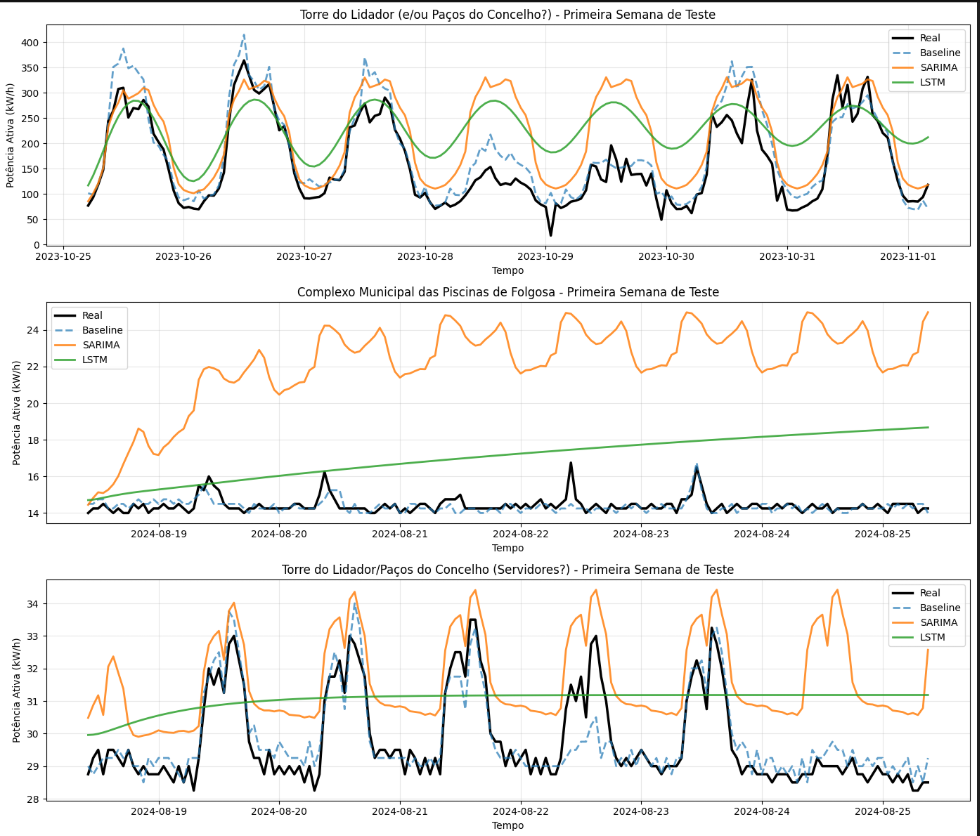



A análise das figuras mostra que o **baseline de persistência semanal** apresenta um desempenho muito competitivo na maioria das CPEs analisadas. Isto deve-se ao facto de o consumo energético apresentar **padrões regulares e repetitivos**.

No caso do **SARIMA**, observa-se que o modelo é capaz de captar a tendência geral do consumo em alguns edifícios, mas apresenta limitações claras. Em determinadas CPEs, o SARIMA tende a **suavizar ligeiramente a série**, falhando a reprodução correta dos picos de consumo. Noutros casos, o modelo revela comportamentos instáveis, com previsões sistematicamente afastadas dos valores reais, o que indica dificuldades em lidar com **mudanças muito abruptas** ou com padrões que não são bem representados por uma estrutura linear.

Relativamente à **LSTM**, os resultados mostram que o modelo consegue acompanhar o nível médio do consumo, mas apresenta previsões demasiado suaves. Em particular, a LSTM **não reproduz adequadamente os picos diários**, subestimando os valores máximos e sobrestimando os mínimos. Este comportamento é mais evidente no zoom da primeira semana de teste e resulta, em grande parte, da natureza recursiva da previsão multi-passo, onde os erros se acumulam ao longo do horizonte temporal.

Em síntese, os resultados indicam que, para edifícios com padrões de consumo estáveis e fortemente sazonais, **modelos simples como o baseline semanal podem ser tão eficazes — ou mesmo mais — do que modelos mais complexos**. Nesta situação os modelos SARIMA e LSTM revelam bastantes limitaçoes.

## **5.2 Previsão Consumo de Potência: Modelos Univariado e Multivariado**



### **5.2.1** Modelo univariado

Nesta primeira abordagem univariada,isto é, só foi utilizada uma feature (weekly_mean) para a previsão da potencia média na semana seguinte.

In [ ]:
def compute_weekly_target(df, time_col="tstamp", power_col="PotActiva"):
    rows = []

    for cpe, g in df.groupby("CPE"):
        g = g.sort_values(time_col).copy()
        iso = g[time_col].dt.isocalendar()
        g["iso_year"] = iso.year.astype(int)
        g["iso_week"] = iso.week.astype(int)

        weekly = (
            g.groupby(["iso_year", "iso_week"])[power_col]
             .mean()
             .rename("weekly_mean")
             .reset_index()
        )

        weekly["target_next"] = weekly["weekly_mean"].shift(-1)
        weekly["CPE"] = cpe

        weekly = weekly.dropna(subset=["target_next"])
        if len(weekly) >= 3:
            rows.append(weekly[["CPE", "iso_year", "iso_week", "weekly_mean", "target_next"]])

    return pd.concat(rows, ignore_index=True)

def temporal_split_weekly(df_week, frac=0.7):
    df_week = df_week.sort_values(["CPE", "iso_year", "iso_week"]).copy()
    out_train, out_test = [], []

    for cpe, g in df_week.groupby("CPE", sort=False):
        cut = int(len(g) * frac)
        out_train.append(g.iloc[:cut])
        out_test.append(g.iloc[cut:])

    return pd.concat(out_train, ignore_index=True), pd.concat(out_test, ignore_index=True)


In [ ]:
df_week = compute_weekly_target(prep_pdf)

train_w, test_w = temporal_split_weekly(df_week, 0.7)

# Conjuntos principais (treino e teste)
X_train = train_w[["weekly_mean"]]
y_train = train_w["target_next"]

X_test  = test_w[["weekly_mean"]]
y_test  = test_w["target_next"]

# Validação temporal (dentro do treino) para tuning e learning curves
train_core, val_w = temporal_split_weekly(train_w, 0.7)

X_core = train_core[["weekly_mean"]]
y_core = train_core["target_next"]

X_val  = val_w[["weekly_mean"]]
y_val  = val_w["target_next"]



RANDOM FOREST:
 MAE: 1.4699435850979876
 RMSE: 4.169628134737909


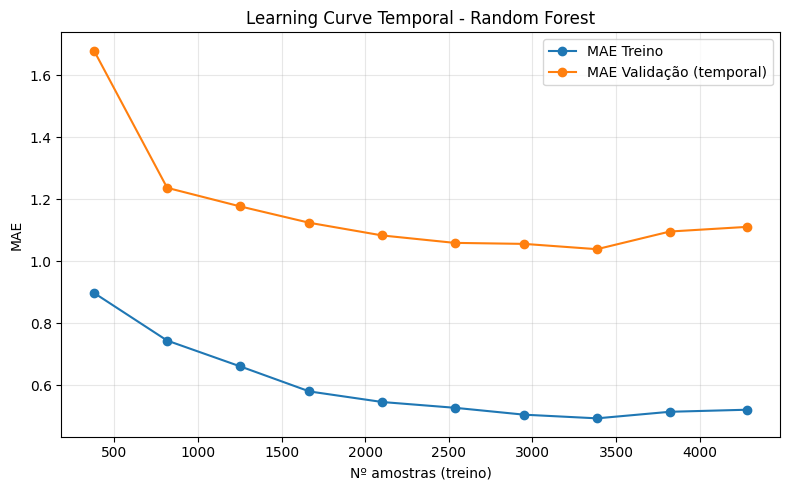

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

mae_rf  = mean_absolute_error(y_test, rf_pred)
rmse_rf = sqrt(mean_squared_error(y_test, rf_pred))

print("RANDOM FOREST:")
print(" MAE:", mae_rf)
print(" RMSE:", rmse_rf)

from sklearn.base import clone
from sklearn.metrics import mean_absolute_error


def head_frac_per_cpe(df, frac):
    parts = []
    for cpe, g in df.groupby("CPE", sort=False):
        g = g.sort_values(["iso_year", "iso_week"])
        cut = max(2, int(len(g) * frac))
        cut = min(cut, len(g))
        if cut >= 2:
            parts.append(g.iloc[:cut])
    return pd.concat(parts, ignore_index=True)

def learning_curve_temporal(df_train_core, df_val, feature_cols, target_col, estimator,
                            fracs=np.linspace(0.1, 1.0, 10)):
    rows = []
    for frac in fracs:
        df_part = head_frac_per_cpe(df_train_core, frac)

        model = clone(estimator)
        model.fit(df_part[feature_cols], df_part[target_col])

        pred_tr  = model.predict(df_part[feature_cols])
        pred_val = model.predict(df_val[feature_cols])

        rows.append({
            "n_train": int(len(df_part)),
            "mae_train": mean_absolute_error(df_part[target_col], pred_tr),
            "mae_val": mean_absolute_error(df_val[target_col], pred_val),
        })
    return pd.DataFrame(rows)

rf_lc_model = RandomForestRegressor(n_estimators=300, random_state=42)

lc_rf = learning_curve_temporal(
    train_core, val_w,
    feature_cols=["weekly_mean"],
    target_col="target_next",
    estimator=rf_lc_model
)

plt.figure(figsize=(8,5))
plt.plot(lc_rf["n_train"], lc_rf["mae_train"], marker="o", label="MAE Treino")
plt.plot(lc_rf["n_train"], lc_rf["mae_val"], marker="o", label="MAE Validação (temporal)")
plt.xlabel("Nº amostras (treino)")
plt.ylabel("MAE")
plt.title("Learning Curve Temporal - Random Forest")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()







In [ ]:
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.4),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),
        "objective": "reg:squarederror",
        "random_state": 42,
    }

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", xgb.XGBRegressor(**params))
    ])

    pipe.fit(X_core, y_core)
    pred_val = pipe.predict(X_val)
    return mean_absolute_error(y_val, pred_val)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
best_params = study.best_params
print("Best parameters:")
print(study.best_params)


C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-23 17:34:14,240] A new study created in memory with name: no-name-e587277a-cd6e-4864-bad6-1599730ca7c0
[I 2025-12-23 17:34:14,671] Trial 0 finished with value: 0.9142697648887963 and parameters: {'n_estimators': 536, 'learning_rate': 0.034247188400733417, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9709389240935034, 'colsample_bytree': 0.6493460557736613, 'gamma': 0.19912391443805766, 'reg_alpha': 0.0005904070480645673, 'reg_lambda': 2.7934221743234344}. Best is trial 0 with value: 0.9142697648887963.
[I 2025-12-23 17:34:14,870] Trial 1 finished with value: 0.9119558456406176 and parameters: {'n_estimators': 499, 'learning_rate': 0.1493526484290528, 'max_depth': 5, 'min_child_weight': 3, 'subsam

Best parameters:
{'n_estimators': 200, 'learning_rate': 0.08164981994905596, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7424167305954962, 'colsample_bytree': 0.9394889748983926, 'gamma': 0.2521426725560472, 'reg_alpha': 0.4715113943777693, 'reg_lambda': 1.1576384291569775}


best_n (early stopping) = 146


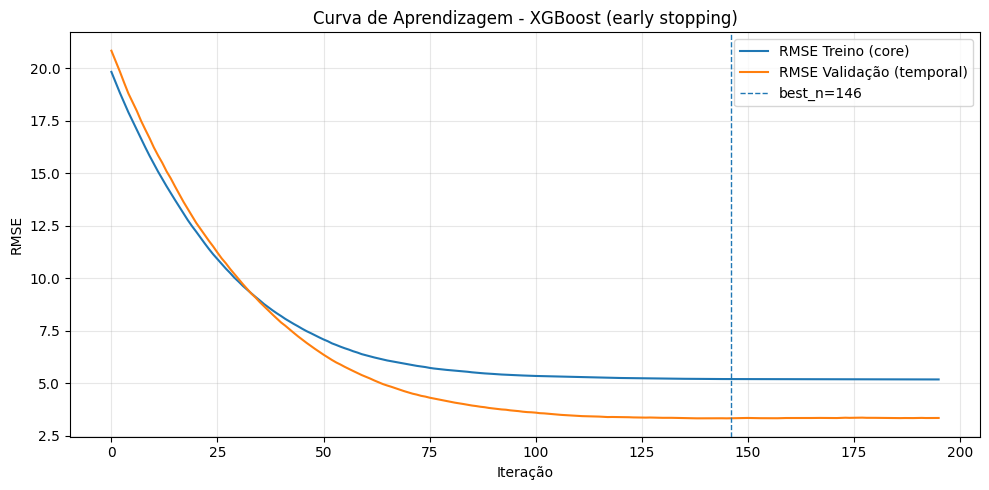


XGBoost FINAL (refit no treino total, avaliado no TESTE):
 MAE: 1.502153789242893
 RMSE: 6.805232852315335
Nº previsões distintas (aprox.): 182


In [ ]:
# ============================
# XGBoost (UNIVARIADO) — correto:
# 1) Treino em CORE + validação temporal (VAL) com early-stopping
# 2) Refit no TREINO TOTAL (X_train) com best_n
# 3) Avaliação no TESTE
# ============================

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

# ---- (A) Parâmetros
# Sugestão: usa os parâmetros do Optuna (best_params) como base,
# mas para early stopping precisas de n_estimators grande.
# Se preferires manter os teus fixos, mete-os em params_base.
params_base = {
    # Se quiseres: substitui este dicionário por {**best_params} (ver abaixo)
    "learning_rate": 0.029801641337800527,
    "max_depth": 5,
    "min_child_weight": 1,
    "subsample": 0.751244620928512,
    "colsample_bytree": 0.9931460997356308,
    "gamma": 0.0000270914940985549,
    "reg_alpha": 0.6430599095486632,
    "reg_lambda": 1.70366115363041,
    "random_state": 42,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}


# ---- (B) Preprocessamento (fit só no CORE)
imp_es = SimpleImputer(strategy="median")
sc_es  = StandardScaler()

Xc = sc_es.fit_transform(imp_es.fit_transform(X_core))
Xv = sc_es.transform(imp_es.transform(X_val))

# ---- (C) Early stopping (NÃO usar teste aqui)
xgb_es = xgb.XGBRegressor(
    **params_base,
    n_estimators=5000,
    early_stopping_rounds=50  
)

xgb_es.fit(
    Xc, y_core,
    eval_set=[(Xc, y_core), (Xv, y_val)],
    verbose=False,
)

best_n = int(xgb_es.best_iteration) + 1
print("best_n (early stopping) =", best_n)

# ---- (D) Curva de aprendizagem (RMSE por iteração) — treino vs validação temporal
res = xgb_es.evals_result()
plt.figure(figsize=(10,5))
plt.plot(res["validation_0"]["rmse"], label="RMSE Treino (core)")
plt.plot(res["validation_1"]["rmse"], label="RMSE Validação (temporal)")
plt.axvline(best_n, linestyle="--", linewidth=1, label=f"best_n={best_n}")
plt.title("Curva de Aprendizagem - XGBoost (early stopping)")
plt.xlabel("Iteração")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---- (E) Refit no TREINO TOTAL (X_train) com best_n
imp_final = SimpleImputer(strategy="median")
sc_final  = StandardScaler()

Xt  = sc_final.fit_transform(imp_final.fit_transform(X_train))
Xte = sc_final.transform(imp_final.transform(X_test))

xgb_final = xgb.XGBRegressor(
    **params_base,
    n_estimators=best_n
)

xgb_final.fit(Xt, y_train)

# ---- (F) Avaliação no TESTE (métricas em escala REAL)
xgb_pred = xgb_final.predict(Xte)

mae_xgb  = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = sqrt(mean_squared_error(y_test, xgb_pred))

print("\nXGBoost FINAL (refit no treino total, avaliado no TESTE):")
print(" MAE:", mae_xgb)
print(" RMSE:", rmse_xgb)

# (Opcional) Diagnóstico rápido: quantos valores distintos o modelo está a prever?
print("Nº previsões distintas (aprox.):", len(np.unique(np.round(xgb_pred, 3))))


C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't conv

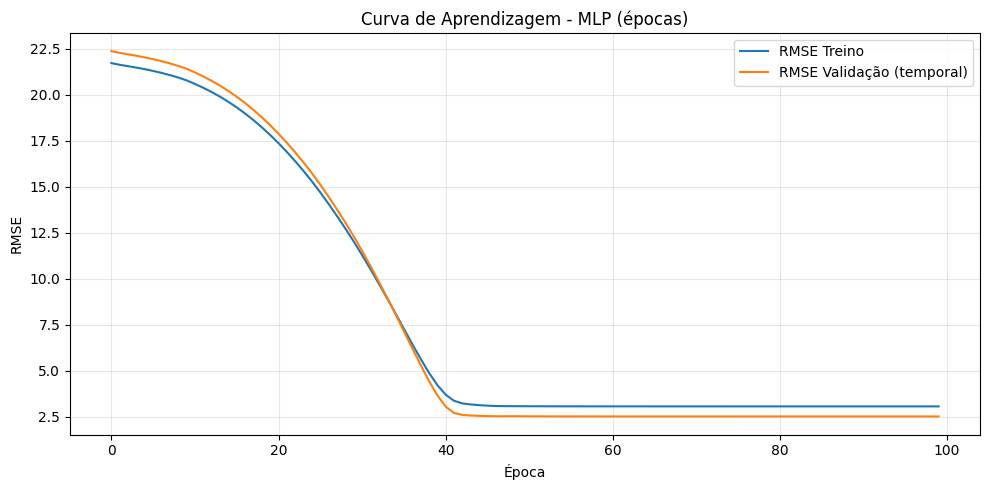


MLP FINAL (avaliado no TESTE):
 MAE: 1.129724367188629
 RMSE: 3.7254313100754306


In [ ]:

# MLP – Curva de Aprendizagem (épocas) + Treino Final

from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt


# LEARNING CURVE 


imputer_lc = SimpleImputer(strategy="median")
scaler_lc = StandardScaler()

Xc = scaler_lc.fit_transform(imputer_lc.fit_transform(X_core))
Xv = scaler_lc.transform(imputer_lc.transform(X_val))

mlp_epoch = MLPRegressor(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    max_iter=1,          # 1 época por iteração
    warm_start=True,
    random_state=42,
    learning_rate_init=0.001
)

n_epochs = 100
train_rmse = []
val_rmse = []

for _ in range(n_epochs):
    mlp_epoch.fit(Xc, y_core)
    pred_tr = mlp_epoch.predict(Xc)
    pred_v  = mlp_epoch.predict(Xv)

    train_rmse.append(np.sqrt(mean_squared_error(y_core, pred_tr)))
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_v)))

plt.figure(figsize=(10,5))
plt.plot(train_rmse, label="RMSE Treino")
plt.plot(val_rmse, label="RMSE Validação (temporal)")
plt.xlabel("Época")
plt.ylabel("RMSE")
plt.title("Curva de Aprendizagem - MLP (épocas)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# TREINO FINAL NO CONJUNTO DE TREINO COMPLETO


imputer_final = SimpleImputer(strategy="median")
scaler_final = StandardScaler()

Xt  = scaler_final.fit_transform(imputer_final.fit_transform(X_train))
Xte = scaler_final.transform(imputer_final.transform(X_test))

mlp_final = MLPRegressor(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    max_iter=2000,
    random_state=42,
    learning_rate_init=0.001
)

mlp_final.fit(Xt, y_train)
mlp_pred = mlp_final.predict(Xte)

#  MÉTRICAS DE ERRO NO TESTE


mae_mlp  = mean_absolute_error(y_test, mlp_pred)
rmse_mlp = np.sqrt(mean_squared_error(y_test, mlp_pred))

print("\nMLP FINAL (avaliado no TESTE):")
print(" MAE:", mae_mlp)
print(" RMSE:", rmse_mlp)


In [ ]:
chk = []
for cpe in df_week["CPE"].unique():
    tr = train_w[train_w["CPE"]==cpe][["iso_year","iso_week"]]
    te = test_w[test_w["CPE"]==cpe][["iso_year","iso_week"]]
    if len(tr) and len(te):
        chk.append(((tr["iso_year"].max(), tr["iso_week"].max()),
                    (te["iso_year"].min(), te["iso_week"].min())))
chk[:5]

[((2024, 51), (2024, 1)),
 ((2025, 52), (2025, 3)),
 ((2024, 49), (2024, 1)),
 ((2025, 52), (2025, 2)),
 ((2024, 49), (2024, 1))]

In [ ]:

# Baseline: persistência semanal (prever semana seguinte = weekly_mean da semana corrente)”
baseline_pred = X_test["weekly_mean"].values
mae_base_mean = mean_absolute_error(y_test, baseline_pred)
rmse_base_mean = sqrt(mean_squared_error(y_test, baseline_pred))


# Tabela de resultados
results = pd.DataFrame({
    "Modelo": [
        "Baseline",
        "Random Forest",
        "XGBoost",
        "MLP"
    ],
    "MAE": [
        mae_base_mean,
        mae_rf,
        mae_xgb,
        mean_absolute_error(y_test, mlp_pred)
    ],
    "RMSE": [
        rmse_base_mean,
        rmse_rf,
        rmse_xgb,
        sqrt(mean_squared_error(y_test, mlp_pred))
    ]
})

results


Modelo       MAE      RMSE
0       Baseline  1.107165  3.729938
1  Random Forest  1.469944  4.169628
2        XGBoost  1.502154  6.805233
3            MLP  1.129724  3.725431

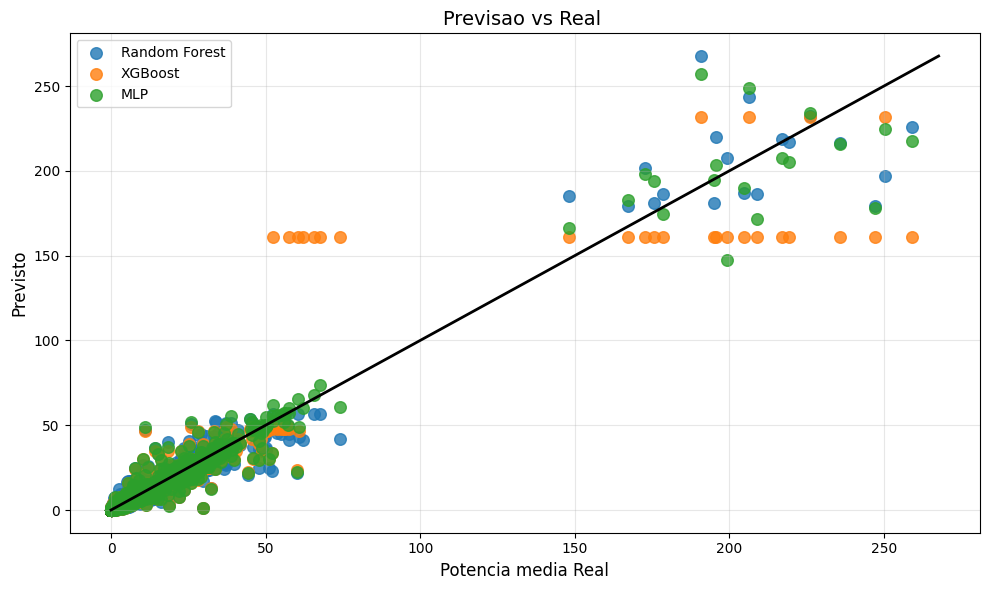

In [ ]:
plt.figure(figsize=(10,6))

min_v = min(y_test.min(), rf_pred.min(), xgb_pred.min(), mlp_pred.min())
max_v = max(y_test.max(), rf_pred.max(), xgb_pred.max(), mlp_pred.max())

plt.plot([min_v, max_v], [min_v, max_v], "k-", linewidth=2)

# Pontos dos modelos
plt.scatter(y_test, rf_pred,  s=70, label="Random Forest", alpha=0.8)
plt.scatter(y_test, xgb_pred, s=70, label="XGBoost",       alpha=0.8)
plt.scatter(y_test, mlp_pred, s=70, label="MLP",           alpha=0.8)

plt.xlabel("Potencia media Real", fontsize=12)
plt.ylabel("Previsto", fontsize=12)
plt.title("Previsao vs Real ", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 5.2.2 — Dataset semanal MULTIVARIADO (por CPE)


def build_weekly_dataset_multivariate(df, time_col="tstamp", power_col="PotActiva"):
    rows = []

    for cpe, g in df.groupby("CPE"):
        g = g.sort_values(time_col).copy()

        iso = g[time_col].dt.isocalendar()
        g["iso_year"] = iso.year.astype(int)
        g["iso_week"] = iso.week.astype(int)
        g["weekday"]  = g[time_col].dt.weekday  # 0=Seg ... 6=Dom

        # Agregados semanais base
        weekly = (
            g.groupby(["iso_year", "iso_week"])[power_col]
             .agg(weekly_mean="mean", weekly_max="max", weekly_std="std")
             .reset_index()
        )

        # Médias weekday vs weekend (podem ficar NaN se semana não tiver amostras weekend/weekday)
        weekday_mean = (
            g[g["weekday"] < 5]
            .groupby(["iso_year", "iso_week"])[power_col]
            .mean()
            .rename("weekday_mean")
        )
        weekend_mean = (
            g[g["weekday"] >= 5]
            .groupby(["iso_year", "iso_week"])[power_col]
            .mean()
            .rename("weekend_mean")
        )

        weekly = weekly.merge(weekday_mean.reset_index(), on=["iso_year","iso_week"], how="left")
        weekly = weekly.merge(weekend_mean.reset_index(), on=["iso_year","iso_week"], how="left")

        # Rácio weekend/weekday
        weekly["weekend_ratio"] = weekly["weekend_mean"] / (weekly["weekday_mean"] + 1e-6)

        # Entropia semanal (sobre valores positivos; se soma=0 → 0)
        def entropy_week(x):
            x = x.values
            x = x[x > 0]
            s = x.sum()
            if s <= 0 or len(x) == 0:
                return 0.0
            p = x / s
            return float(-(p * np.log(p + 1e-9)).sum())

        ent = (
            g.groupby(["iso_year","iso_week"])[power_col]
             .apply(entropy_week)
             .rename("entropy_week")
             .reset_index()
        )

        weekly = weekly.merge(ent, on=["iso_year","iso_week"], how="left")

        # Target: prever média da semana seguinte
        weekly = weekly.sort_values(["iso_year","iso_week"]).reset_index(drop=True)
        weekly["target_next"] = weekly["weekly_mean"].shift(-1)

        weekly["CPE"] = cpe
        weekly = weekly.dropna(subset=["target_next"])

        # Garantir semanas suficientes
        if len(weekly) >= 3:
            rows.append(
                weekly[[
                    "CPE","iso_year","iso_week",
                    "weekly_mean","weekly_max","weekly_std",
                    "weekday_mean","weekend_mean","weekend_ratio",
                    "entropy_week","target_next"
                ]]
            )

    return pd.concat(rows, ignore_index=True)

df_weekly = build_weekly_dataset_multivariate(prep_pdf)
print("Shape df_weekly:", df_weekly.shape)
df_weekly.head()


Shape df_weekly: (8887, 11)


CPE  iso_year  iso_week  weekly_mean  weekly_max  \
0  PT0002000032936306KX      2024         9     1.896404       5.480   
1  PT0002000032936306KX      2024        10     2.787131       5.516   
2  PT0002000032936306KX      2024        11     2.714899       5.524   
3  PT0002000032936306KX      2024        12     2.651565       5.504   
4  PT0002000032936306KX      2024        13     2.548647       5.492   

   weekly_std  weekday_mean  weekend_mean  weekend_ratio  entropy_week  \
0    2.564915      0.000000      2.834729   2.834729e+06      4.627121   
1    2.676819      2.797508      2.761188   9.870164e-01      5.859670   
2    2.677644      2.724992      2.689667   9.870363e-01      5.836289   
3    2.671130      2.663658      2.621333   9.841098e-01      5.813870   
4    2.666688      2.575175      2.480915   9.633962e-01      5.770381   

   target_next  
0     2.787131  
1     2.714899  
2     2.651565  
3     2.548647  
4     2.144835

In [ ]:
# ============================================================
# Split temporal por CPE (igual ao univariado)
# ============================================================

train_w_m, test_w_m = temporal_split_weekly(df_weekly, 0.7)

# treino vs teste
features_m = [
    "weekly_mean","weekly_max","weekly_std",
    "weekday_mean","weekend_mean","weekend_ratio","entropy_week"
]

X_train_m = train_w_m[features_m]
y_train_m = train_w_m["target_next"]

X_test_m  = test_w_m[features_m]
y_test_m  = test_w_m["target_next"]

# validação temporal DENTRO do treino (para tuning e learning curves)
train_core_m, val_w_m = temporal_split_weekly(train_w_m, 0.7)

X_core_m = train_core_m[features_m]
y_core_m = train_core_m["target_next"]

X_val_m  = val_w_m[features_m]
y_val_m  = val_w_m["target_next"]





Baseline (persistência semanal):
 MAE  = 1.1071654522405625
 RMSE = 3.729938109717677

RANDOM FOREST (multivariado):
 MAE: 1.1639408698658318
 RMSE: 3.452941747445885


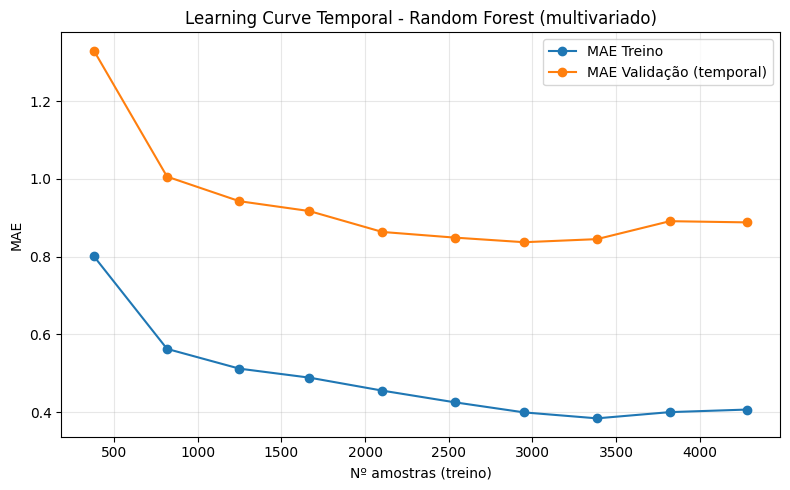

[I 2025-12-23 17:35:30,008] A new study created in memory with name: no-name-a89c91ef-d2a8-4093-bcaa-a0d91ff69329
[I 2025-12-23 17:35:30,413] Trial 0 finished with value: 1.008754419303544 and parameters: {'n_estimators': 1164, 'learning_rate': 0.1312336259815875, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.947187595283765, 'colsample_bytree': 0.9370235069050136, 'gamma': 0.37473334281939497, 'reg_alpha': 0.12229782761184549, 'reg_lambda': 0.6404739143014455}. Best is trial 0 with value: 1.008754419303544.
[I 2025-12-23 17:35:30,676] Trial 1 finished with value: 1.0187648000974927 and parameters: {'n_estimators': 598, 'learning_rate': 0.19992720473406916, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.9422527615289918, 'colsample_bytree': 0.6712738446027353, 'gamma': 0.2071762833970886, 'reg_alpha': 0.9018769214661466, 'reg_lambda': 1.10253191355801}. Best is trial 0 with value: 1.008754419303544.
[I 2025-12-23 17:35:31,027] Trial 2 finished with value: 1.0037079017785

Best params XGB (multivariado): {'n_estimators': 326, 'learning_rate': 0.03880538483456495, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9508437857967819, 'colsample_bytree': 0.964896219024343, 'gamma': 0.3467815850634456, 'reg_alpha': 0.5864558923390127, 'reg_lambda': 0.9148424649928512}


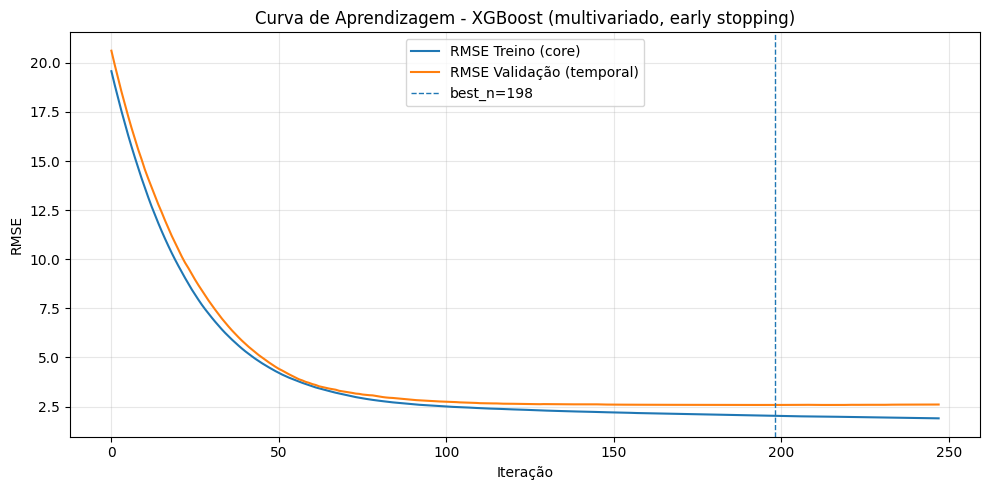


XGBoost FINAL (multivariado, refit treino total, avaliado no TESTE):
 MAE: 1.1897032188312555
 RMSE: 4.024065413767566


C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't conv

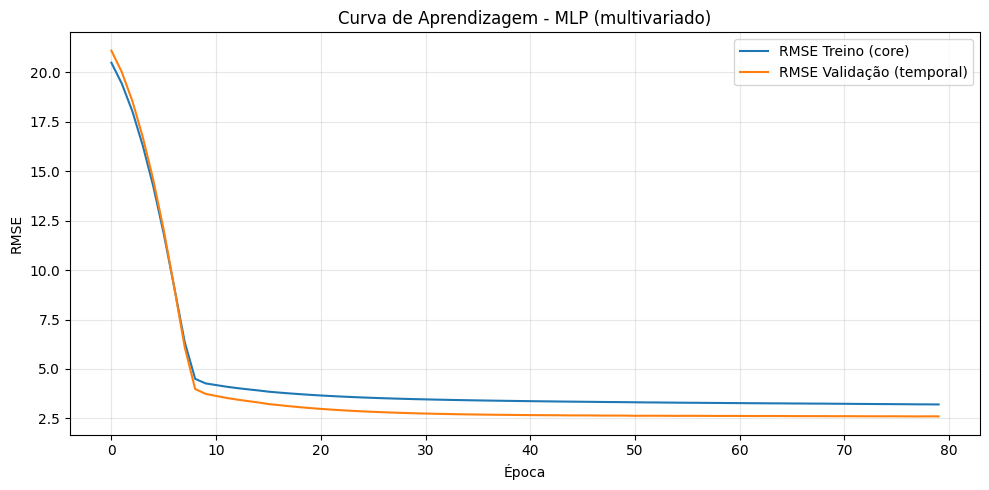


MLP FINAL (multivariado, refit treino total, avaliado no TESTE):
 MAE: 1.1119080111159063
 RMSE: 3.5463979181029486


Modelo       MAE      RMSE
0       Baseline  1.107165  3.729938
1  Random Forest  1.163941  3.452942
2        XGBoost  1.189703  4.024065
3            MLP  1.111908  3.546398

In [ ]:
# ============================================================
# Baseline: persistência semanal
# prever target_next ≈ weekly_mean da semana corrente
# ============================================================

baseline_pred_m = test_w_m["weekly_mean"].values

mae_base_m  = mean_absolute_error(y_test_m, baseline_pred_m)
rmse_base_m = np.sqrt(mean_squared_error(y_test_m, baseline_pred_m))

print("\nBaseline (persistência semanal):")
print(" MAE  =", mae_base_m)
print(" RMSE =", rmse_base_m)

# ============================================================
# Random Forest — treino final no treino total; avaliação no teste
# + learning curve temporal (core vs val)
# ============================================================

rf_m = RandomForestRegressor(n_estimators=300, random_state=42)
rf_m.fit(X_train_m, y_train_m)
rf_pred_m = rf_m.predict(X_test_m)

mae_rf_m  = mean_absolute_error(y_test_m, rf_pred_m)
rmse_rf_m = np.sqrt(mean_squared_error(y_test_m, rf_pred_m))

print("\nRANDOM FOREST (multivariado):")
print(" MAE:", mae_rf_m)
print(" RMSE:", rmse_rf_m)

from sklearn.base import clone

def head_frac_per_cpe(df, frac):
    parts = []
    for cpe, g in df.groupby("CPE", sort=False):
        g = g.sort_values(["iso_year","iso_week"])
        cut = max(2, int(len(g) * frac))
        cut = min(cut, len(g))
        if cut >= 2:
            parts.append(g.iloc[:cut])
    return pd.concat(parts, ignore_index=True)

def learning_curve_temporal(df_train_core, df_val, feature_cols, target_col, estimator,
                            fracs=np.linspace(0.1, 1.0, 10)):
    rows = []
    for frac in fracs:
        df_part = head_frac_per_cpe(df_train_core, frac)

        model = clone(estimator)
        model.fit(df_part[feature_cols], df_part[target_col])

        pred_tr  = model.predict(df_part[feature_cols])
        pred_val = model.predict(df_val[feature_cols])

        rows.append({
            "n_train": int(len(df_part)),
            "mae_train": mean_absolute_error(df_part[target_col], pred_tr),
            "mae_val": mean_absolute_error(df_val[target_col], pred_val),
        })
    return pd.DataFrame(rows)

rf_lc_model_m = RandomForestRegressor(n_estimators=300, random_state=42)

lc_rf_m = learning_curve_temporal(
    train_core_m, val_w_m,
    feature_cols=features_m,
    target_col="target_next",
    estimator=rf_lc_model_m
)

plt.figure(figsize=(8,5))
plt.plot(lc_rf_m["n_train"], lc_rf_m["mae_train"], marker="o", label="MAE Treino")
plt.plot(lc_rf_m["n_train"], lc_rf_m["mae_val"], marker="o", label="MAE Validação (temporal)")
plt.xlabel("Nº amostras (treino)")
plt.ylabel("MAE")
plt.title("Learning Curve Temporal - Random Forest (multivariado)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



# XGBOOST - MODELO

# PREPROCESSAMENTO  
# ============================================================
# XGBoost — tuning em validação temporal (core/val)
# ============================================================

import optuna
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def objective_xgb_m(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.4),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),
        "objective": "reg:squarederror",
        "random_state": 42,
        "eval_metric": "rmse",
    }

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", xgb.XGBRegressor(**params))
    ])

    pipe.fit(X_core_m, y_core_m)
    pred_val = pipe.predict(X_val_m)
    return mean_absolute_error(y_val_m, pred_val)

study_m = optuna.create_study(direction="minimize")
study_m.optimize(objective_xgb_m, n_trials=30)

best_params_m = study_m.best_params
print("Best params XGB (multivariado):", best_params_m)


# ============================================================
# XGBoost — curva de aprendizagem com early stopping (core/val)
# + refit no treino total e avaliação no teste
# ============================================================

# Parâmetros finais (Optuna + fixos)
params_m = {
    **best_params_m,
    "random_state": 42,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}

# (A) Early stopping em core/val (para obter best_n e curva)
imp_es = SimpleImputer(strategy="median")
sc_es  = StandardScaler()

Xc = sc_es.fit_transform(imp_es.fit_transform(X_core_m))
Xv = sc_es.transform(imp_es.transform(X_val_m))

xgb_es = xgb.XGBRegressor(**params_m,
    early_stopping_rounds=50)
xgb_es.fit(
    Xc, y_core_m,
    eval_set=[(Xc, y_core_m), (Xv, y_val_m)],
    verbose=False
)

best_n = int(xgb_es.best_iteration) + 1
res = xgb_es.evals_result()

plt.figure(figsize=(10,5))
plt.plot(res["validation_0"]["rmse"], label="RMSE Treino (core)")
plt.plot(res["validation_1"]["rmse"], label="RMSE Validação (temporal)")
plt.axvline(best_n, linestyle="--", linewidth=1, label=f"best_n={best_n}")
plt.title("Curva de Aprendizagem - XGBoost (multivariado, early stopping)")
plt.xlabel("Iteração")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (B) Refit no TREINO TOTAL (train_w_m) com best_n e avaliação no TESTE
imp_final = SimpleImputer(strategy="median")
sc_final  = StandardScaler()

Xt  = sc_final.fit_transform(imp_final.fit_transform(X_train_m))
Xte = sc_final.transform(imp_final.transform(X_test_m))

xgb_final_m = xgb.XGBRegressor(**{**params_m, "n_estimators": best_n})
xgb_final_m.fit(Xt, y_train_m)

xgb_pred_m = xgb_final_m.predict(Xte)

mae_xgb_m  = mean_absolute_error(y_test_m, xgb_pred_m)
rmse_xgb_m = np.sqrt(mean_squared_error(y_test_m, xgb_pred_m))

print("\nXGBoost FINAL (multivariado, refit treino total, avaliado no TESTE):")
print(" MAE:", mae_xgb_m)
print(" RMSE:", rmse_xgb_m)




# MLP - MODELO

# ============================================================
# MLP — curva de aprendizagem por épocas (core/val)
# + refit treino total e avaliação no teste
# ============================================================

from sklearn.neural_network import MLPRegressor

# (A) learning curve em core/val
imp_lc = SimpleImputer(strategy="median")
sc_lc  = StandardScaler()

Xc = sc_lc.fit_transform(imp_lc.fit_transform(X_core_m))
Xv = sc_lc.transform(imp_lc.transform(X_val_m))

mlp_epoch = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    max_iter=1,
    warm_start=True,
    random_state=42,
    learning_rate_init=0.001
)

n_epochs = 80
train_rmse = []
val_rmse = []

for _ in range(n_epochs):
    mlp_epoch.fit(Xc, y_core_m)
    pred_tr = mlp_epoch.predict(Xc)
    pred_v  = mlp_epoch.predict(Xv)

    train_rmse.append(np.sqrt(mean_squared_error(y_core_m, pred_tr)))
    val_rmse.append(np.sqrt(mean_squared_error(y_val_m, pred_v)))

plt.figure(figsize=(10,5))
plt.plot(train_rmse, label="RMSE Treino (core)")
plt.plot(val_rmse,   label="RMSE Validação (temporal)")
plt.xlabel("Época")
plt.ylabel("RMSE")
plt.title("Curva de Aprendizagem - MLP (multivariado)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (B) refit no treino total e avaliação no teste
imp_final = SimpleImputer(strategy="median")
sc_final  = StandardScaler()

Xt  = sc_final.fit_transform(imp_final.fit_transform(X_train_m))
Xte = sc_final.transform(imp_final.transform(X_test_m))

mlp_final_m = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    max_iter=2000,
    random_state=42,
    learning_rate_init=0.001
)

mlp_final_m.fit(Xt, y_train_m)
mlp_pred_m = mlp_final_m.predict(Xte)

mae_mlp_m  = mean_absolute_error(y_test_m, mlp_pred_m)
rmse_mlp_m = np.sqrt(mean_squared_error(y_test_m, mlp_pred_m))

print("\nMLP FINAL (multivariado, refit treino total, avaliado no TESTE):")
print(" MAE:", mae_mlp_m)
print(" RMSE:", rmse_mlp_m)



# ============================================================
# Tabela final (multivariado) — tudo em escala REAL (não normalizada)
# ============================================================

results_multivar = pd.DataFrame({
    "Modelo": ["Baseline", "Random Forest", "XGBoost", "MLP"],
    "MAE":    [mae_base_m, mae_rf_m, mae_xgb_m, mae_mlp_m],
    "RMSE":   [rmse_base_m, rmse_rf_m, rmse_xgb_m, rmse_mlp_m]
})

results_multivar


Analisando as curvas de aprendizagem, o RMSE de treino e validação desce rapidamente e estabiliza cedo nos diferentes modelos analisados. No XGBoost o erro de treino fica ligeiramente abaixo do de validação, indicando bom ajuste assim como acontece no MLP onde as curvas tambem se aproximam bastante uma da outra que é um indicio de uma boa generalizaçao.
Observando a tabela que apresenta os valores para as duas metricas de erro (MAE e RMSE), verificamos que os três modelos mais complexos conseguem apresentar muito melhores resultados que a Baseline com uma ligeira "vitória" do MLP ainda que pouco expressiva.

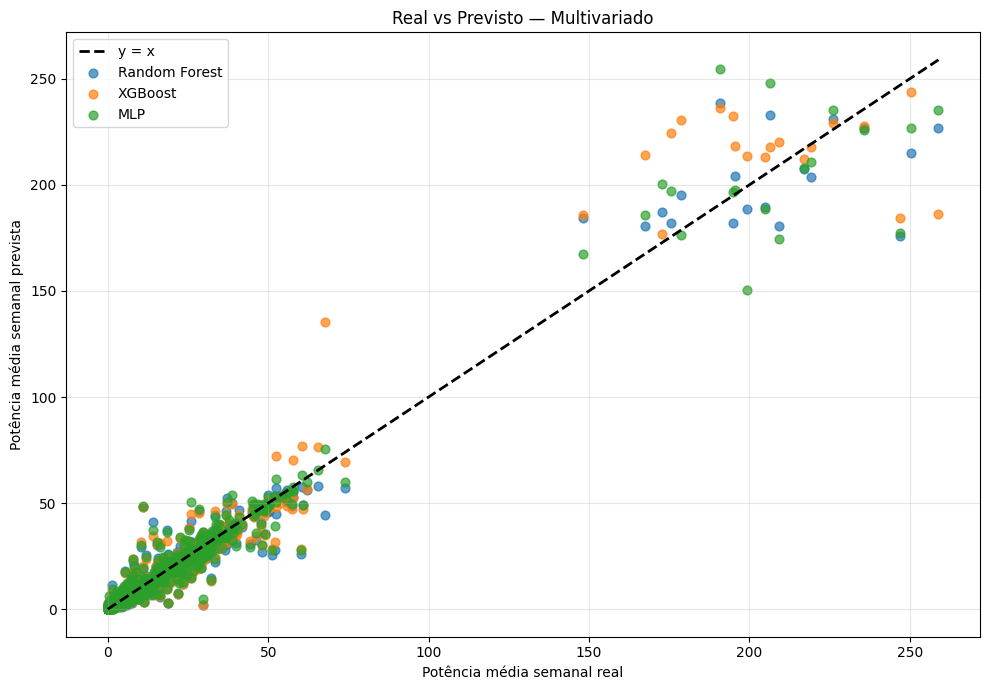

In [ ]:
# ============================================================
# Scatter: Real vs Previsto (multivariado)
# ============================================================

plt.figure(figsize=(10,7))

min_v = min(y_test_m.min(), rf_pred_m.min(), xgb_pred_m.min(), mlp_pred_m.min())
max_v = max(y_test_m.max(), rf_pred_m.max(), xgb_pred_m.max(), mlp_pred_m.max())

plt.plot([min_v, max_v], [min_v, max_v], "k--", linewidth=2, label="y = x")

plt.scatter(y_test_m, rf_pred_m,  s=40, alpha=0.7, label="Random Forest")
plt.scatter(y_test_m, xgb_pred_m, s=40, alpha=0.7, label="XGBoost")
plt.scatter(y_test_m, mlp_pred_m, s=40, alpha=0.7, label="MLP")

plt.xlabel("Potência média semanal real")
plt.ylabel("Potência média semanal prevista")
plt.title("Real vs Previsto — Multivariado")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Análise da relação entre valores reais e previstos (modelos baseados em *features*)

A Figura apresenta a relação entre o **consumo semanal real** e o **consumo semanal previsto** pelos modelos Random Forest, XGBoost e MLP, sendo a linha tracejada (*y = x*) a referência de previsão perfeita.

De forma geral, observa-se que os três modelos apresentam uma **boa capacidade preditiva**, com a maioria dos pontos concentrados próximo da linha de referência, o que indica uma correspondência adequada entre os valores reais e os valores estimados. Este comportamento é particularmente evidente nos intervalos de consumo mais frequentes, onde a dispersão é reduzida.

Para valores de consumo mais elevados, verifica-se um **aumento da dispersão**, demonstrando maior dificuldade por parte dos modelos em prever corretamente semanas com consumos extremos. Ainda assim, os modelos conseguem preservar a tendência global, não se observando desvios sistemáticos graves.

Em síntese, os resultados sugerem que os modelos supervisionados baseados em *features* conseguem capturar eficazmente a relação entre as características semanais e o consumo médio, apresentando um desempenho globalmente consistente.


-----
## Comparação entre o modelo univariado e o modelo multivariado

A comparação entre o modelo univariado e o modelo multivariado apresenta algumas diferenças tanto ao nível da informação utilizada mas não do desempenho obtido como visivel na Figura seguinte.

O **modelo univariado**, baseado exclusivamente na *média semanal do consumo*, capta apenas o nível global de utilização energética. Esta abordagem permite modelar a tendência geral, mas ignora a outras componentes que podem ser beneficas na previsao. 

Por sua vez, o **modelo multivariado** integra um conjunto mais alargado de *features*, incluindo medidas de máximo, desvio-padrão, rácio de fim de semana e entropia semanal. Esta informação adicional permite capturar não apenas o nível médio de consumo, mas também a sua **variabilidade e regularidade**.

Os resultados obtidos confirmam esta diferença conceptual, embora o impacto no desempenho seja **relativamente reduzido**. O modelo multivariado apresenta **valores apenas ligeiramente inferiores de MAE e RMSE** em todos os algoritmos testados, não se observando diferenças substanciais face ao modelo univariado. Este resultado sugere que, para os dados analisados, a média semanal do consumo já concentra uma parte significativa da informação relevante para a previsão.

Em síntese, os resultados indicam que **ambas as abordagens apresentam desempenhos muito próximos**, apesar das diferenças na informação utilizada. O modelo univariado destaca-se pela sua simplicidade e interpretabilidade, enquanto o modelo multivariado beneficia de uma descrição mais rica do comportamento do consumo, ainda que com ganhos reduzidos em termos de erro.



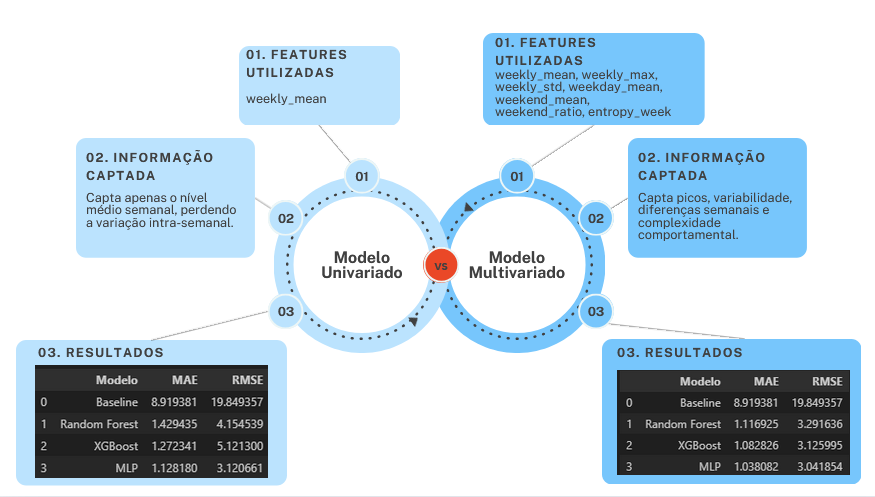